## Ensemble model

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from tqdm import tqdm

class StackedEnsembleModel:
    def __init__(self, base_models, meta_model, n_splits=10, n_repeats=1):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.train_predictions, self.test_predictions = self.get_stacked_base_predictions(X, y, X)

        self.meta_model.fit(self.train_predictions, y)

    def get_stacked_base_predictions(self, X, y, X_test):
        predictions_train = np.zeros((X.shape[0], len(self.base_models)))
        predictions_test = np.zeros((X_test.shape[0], len(self.base_models)))

        rkf = RepeatedKFold(n_splits=self.n_splits, n_repeats=self.n_repeats, random_state=42)

        for i, (model_name, model) in enumerate(tqdm(self.base_models.items(), desc="Training base models")):
            test_fold_predictions = np.zeros((X_test.shape[0], self.n_splits * self.n_repeats))
            for fold, (train_index, val_index) in enumerate(rkf.split(X)):
                X_fold_train, X_fold_val = X[train_index], X[val_index]
                y_fold_train, y_fold_val = y.iloc[train_index], y.iloc[val_index]

                model.fit(X_fold_train, y_fold_train)
                predictions_train[val_index, i] = model.predict_proba(X_fold_val)[:, 1]
                test_fold_predictions[:, fold] = model.predict_proba(X_test)[:, 1]

            predictions_test[:, i] = test_fold_predictions.mean(axis=1)

        return predictions_train, predictions_test

    def predict(self, X):
        base_preds = np.zeros((X.shape[0], len(self.base_models)))
        for i, (model_name, model) in enumerate(self.base_models.items()):
            base_preds[:, i] = model.predict(X)
        return self.meta_model.predict(base_preds)

# 读取数据
file_path = 'all_answer.xlsx'
data = pd.read_excel(file_path)

# 确保没有缺失值
data = data.dropna(subset=[data.columns[0], data.columns[1]])

# 准备特征和目标变量
X_text = data.iloc[:, 0]  # 第一列为文本数据
y = data.iloc[:, 1]  # 第二列为标签

# 文本向量化
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_text)

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化基模型和元模型
base_models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier()
}
meta_model = LogisticRegression()

# 创建集成模型实例
ensemble_model = StackedEnsembleModel(base_models, meta_model)

# 训练模型
ensemble_model.fit(X_train, y_train)

# 预测并评估模型
train_meta_predictions = ensemble_model.predict(X_train)
test_meta_predictions = ensemble_model.predict(X_test)

# 评估指标
train_accuracy = accuracy_score(y_train, train_meta_predictions)
test_accuracy = accuracy_score(y_test, test_meta_predictions)
train_precision = precision_score(y_train, train_meta_predictions)
test_precision = precision_score(y_test, test_meta_predictions)
train_recall = recall_score(y_train, train_meta_predictions)
test_recall = recall_score(y_test, test_meta_predictions)
train_f1 = f1_score(y_train, train_meta_predictions)
test_f1 = f1_score(y_test, test_meta_predictions)
train_roc_auc = roc_auc_score(y_train, train_meta_predictions)
test_roc_auc = roc_auc_score(y_test, test_meta_predictions)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Train F1 Score: {train_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Train ROC AUC: {train_roc_auc:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, test_meta_predictions)
print(f'Confusion Matrix:\n{conf_matrix}')

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, ensemble_model.test_predictions[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 绘制精确率-召回率曲线
precision, recall, _ = precision_recall_curve(y_test, ensemble_model.test_predictions[:, 1])
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig('precision_recall_curve.png', dpi=300)  # 保存图像，设置分辨率为300 DPI
plt.show()

# 保存最终模型和预测结果
data['predicted_score'] = np.nan
data.loc[y_train.index, 'predicted_score'] = train_meta_predictions
data.loc[y_test.index, 'predicted_score'] = test_meta_predictions

output_path = 'stacked_ensemble_predictions.xlsx'
data.to_excel(output_path, index=False)

# 打印结果
print(data)


Training base models:   0%|          | 0/3 [00:00<?, ?it/s]

## tune parameter

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from tqdm import tqdm

class StackedEnsembleModel:
    def __init__(self, base_models, meta_model, n_splits=10, n_repeats=1):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.train_predictions, self.test_predictions = self.get_stacked_base_predictions(X, y, X)

        self.meta_model.fit(self.train_predictions, y)

    def get_stacked_base_predictions(self, X, y, X_test):
        predictions_train = np.zeros((X.shape[0], len(self.base_models)))
        predictions_test = np.zeros((X_test.shape[0], len(self.base_models)))

        rkf = RepeatedKFold(n_splits=self.n_splits, n_repeats=self.n_repeats, random_state=42)

        for i, (model_name, model) in enumerate(tqdm(self.base_models.items(), desc="Training base models")):
            test_fold_predictions = np.zeros((X_test.shape[0], self.n_splits * self.n_repeats))
            for fold, (train_index, val_index) in enumerate(rkf.split(X)):
                X_fold_train, X_fold_val = X[train_index], X[val_index]
                y_fold_train, y_fold_val = y.iloc[train_index], y.iloc[val_index]

                model.fit(X_fold_train, y_fold_train)
                predictions_train[val_index, i] = model.predict_proba(X_fold_val)[:, 1]
                test_fold_predictions[:, fold] = model.predict_proba(X_test)[:, 1]

            predictions_test[:, i] = test_fold_predictions.mean(axis=1)

        return predictions_train, predictions_test

    def predict(self, X):
        base_preds = np.zeros((X.shape[0], len(self.base_models)))
        for i, (model_name, model) in enumerate(self.base_models.items()):
            base_preds[:, i] = model.predict(X)
        return self.meta_model.predict(base_preds)

def tune_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# 读取数据
file_path = 'all_answer.xlsx'
data = pd.read_excel(file_path)

# 确保没有缺失值
data = data.dropna(subset=[data.columns[0], data.columns[1]])

# 准备特征和目标变量
X_text = data.iloc[:, 0]  # 第一列为文本数据
y = data.iloc[:, 1]  # 第二列为标签

# 文本向量化
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_text)

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义超参数网格
knn_param_grid = {
    'n_neighbors': [5, 10, 15],
    'metric': ['euclidean', 'manhattan']
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear']
}

xgb_param_grid = {
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2]
}

meta_param_grid = {
    'C': [0.1, 1, 10]
}

# 调优基模型
tuned_knn = tune_model(KNeighborsClassifier(), knn_param_grid, X_train, y_train)
tuned_svm = tune_model(SVC(probability=True), svm_param_grid, X_train, y_train)
tuned_xgb = tune_model(XGBClassifier(), xgb_param_grid, X_train, y_train)

# 调优元模型
tuned_meta_model = tune_model(LogisticRegression(), meta_param_grid, X_train, y_train)

# 初始化基模型和元模型
base_models = {
    "KNN": tuned_knn,
    "SVM": tuned_svm,
    "XGBoost": tuned_xgb
}
meta_model = tuned_meta_model

# 创建集成模型实例
ensemble_model = StackedEnsembleModel(base_models, meta_model)

# 训练模型
ensemble_model.fit(X_train, y_train)

# 预测并评估模型
train_meta_predictions = ensemble_model.predict(X_train)
test_meta_predictions = ensemble_model.predict(X_test)

# 评估指标
train_accuracy = accuracy_score(y_train, train_meta_predictions)
test_accuracy = accuracy_score(y_test, test_meta_predictions)
train_precision = precision_score(y_train, train_meta_predictions)
test_precision = precision_score(y_test, test_meta_predictions)
train_recall = recall_score(y_train, train_meta_predictions)
test_recall = recall_score(y_test, test_meta_predictions)
train_f1 = f1_score(y_train, train_meta_predictions)
test_f1 = f1_score(y_test, test_meta_predictions)
train_roc_auc = roc_auc_score(y_train, train_meta_predictions)
test_roc_auc = roc_auc_score(y_test, test_meta_predictions)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Train F1 Score: {train_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Train ROC AUC: {train_roc_auc:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, test_meta_predictions)
print(f'Confusion Matrix:\n{conf_matrix}')

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, ensemble_model.test_predictions[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 绘制精确率-召回率曲线
precision, recall, _ = precision_recall_curve(y_test, ensemble_model.test_predictions[:, 1])
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig('precision_recall_curve.png', dpi=300)  # 保存图像，设置分辨率为300 DPI
plt.show()

# 保存最终模型和预测结果
data['predicted_score'] = np.nan
data.loc[y_train.index, 'predicted_score'] = train_meta_predictions
data.loc[y_test.index, 'predicted_score'] = test_meta_predictions

output_path = 'stacked_ensemble_predictions.xlsx'
data.to_excel(output_path, index=False)

# 打印结果
print(data)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...................metric=euclidean, n_neighbors=10; total time=  19.9s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  20.1s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  20.2s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  20.0s
[CV] END ...................metric=euclidean, n_neighbors=10; total time=  20.1s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  20.4s
[CV] END ...................metric=euclidean, n_neighbors=10; total time=  20.5s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  20.7s
[CV] END ....................metric=manhattan, n_neighbors=5; total time=   3.4s
[CV] END ....................metric=manhattan, n_neighbors=5; total time=   3.5s
[CV] END ....................metric=manhattan, n_neighbors=5; total time=   3.3s
[CV] END ....................metric=manhattan, n_

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best parameters for LogisticRegression: {'C': 10}


Training base models: 100%|██████████| 3/3 [06:20<00:00, 126.84s/it]


Train Accuracy: 0.9981
Test Accuracy: 0.9872
Train Precision: 0.9988
Test Precision: 0.9873
Train Recall: 0.9970
Test Recall: 0.9842
Train F1 Score: 0.9979
Test F1 Score: 0.9858
Train ROC AUC: 0.9980
Test ROC AUC: 0.9870
Confusion Matrix:
[[1539   16]
 [  20 1247]]


ValueError: Found input variables with inconsistent numbers of samples: [2822, 11288]

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...................metric=euclidean, n_neighbors=10; total time=  19.9s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  20.1s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  20.2s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  20.0s
[CV] END ...................metric=euclidean, n_neighbors=10; total time=  20.1s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  20.4s
[CV] END ...................metric=euclidean, n_neighbors=10; total time=  20.5s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=  20.7s
[CV] END ....................metric=manhattan, n_neighbors=5; total time=   3.4s
[CV] END ....................metric=manhattan, n_neighbors=5; total time=   3.5s
[CV] END ....................metric=manhattan, n_neighbors=5; total time=   3.3s
[CV] END ....................metric=manhattan, n_neighbors=5; total time=   3.4s
[CV] END ....................metric=manhattan, n_neighbors=5; total time=   3.3s
[CV] END ...................metric=euclidean, n_neighbors=10; total time=  19.8s
[CV] END ...................metric=euclidean, n_neighbors=10; total time=  19.7s
[CV] END ...................metric=euclidean, n_neighbors=15; total time=  19.7s
[CV] END ...................metric=euclidean, n_neighbors=15; total time=  19.6s
[CV] END ...................metric=euclidean, n_neighbors=15; total time=  19.9s
[CV] END ...................metric=euclidean, n_neighbors=15; total time=  19.4s
[CV] END ...................metric=euclidean, n_neighbors=15; total time=  19.9s
[CV] END ...................metric=manhattan, n_neighbors=10; total time=   3.6s
[CV] END ...................metric=manhattan, n_neighbors=10; total time=   3.4s
[CV] END ...................metric=manhattan, n_neighbors=10; total time=   3.4s
[CV] END ...................metric=manhattan, n_neighbors=10; total time=   3.5s
[CV] END ...................metric=manhattan, n_neighbors=15; total time=   3.3s
[CV] END ...................metric=manhattan, n_neighbors=15; total time=   3.4s
[CV] END ...................metric=manhattan, n_neighbors=10; total time=   3.5s
[CV] END ...................metric=manhattan, n_neighbors=15; total time=   3.3s
[CV] END ...................metric=manhattan, n_neighbors=15; total time=   3.0s
[CV] END ...................metric=manhattan, n_neighbors=15; total time=   2.2s
Best parameters for KNeighborsClassifier: {'metric': 'euclidean', 'n_neighbors': 5}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .................................C=1, kernel=linear; total time=  25.2s
[CV] END .................................C=1, kernel=linear; total time=  26.1s
[CV] END .................................C=1, kernel=linear; total time=  26.3s
[CV] END ................................C=10, kernel=linear; total time=  18.4s
[CV] END .................................C=1, kernel=linear; total time=  25.5s
[CV] END .................................C=1, kernel=linear; total time=  25.2s
[CV] END ...............................C=0.1, kernel=linear; total time=  55.4s
[CV] END ...............................C=0.1, kernel=linear; total time=  55.5s
[CV] END ...............................C=0.1, kernel=linear; total time=  55.7s
[CV] END ...............................C=0.1, kernel=linear; total time=  56.0s
[CV] END ...............................C=0.1, kernel=linear; total time=  56.7s
[CV] END ................................C=10, kernel=linear; total time=  14.5s
[CV] END ................................C=10, kernel=linear; total time=  11.7s
[CV] END ................................C=10, kernel=linear; total time=  12.3s
[CV] END ................................C=10, kernel=linear; total time=   9.8s
Best parameters for SVC: {'C': 1, 'kernel': 'linear'}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..............gamma=0, max_depth=3, n_estimators=50; total time=   1.2s
[CV] END ..............gamma=0, max_depth=3, n_estimators=50; total time=   1.3s
[CV] END ..............gamma=0, max_depth=3, n_estimators=50; total time=   1.4s
[CV] END ..............gamma=0, max_depth=3, n_estimators=50; total time=   1.4s
[CV] END ..............gamma=0, max_depth=3, n_estimators=50; total time=   1.4s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=   2.1s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=   2.1s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=   2.1s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=   1.9s
[CV] END .............gamma=0, max_depth=3, n_estimators=100; total time=   2.2s
[CV] END .............gamma=0, max_depth=3, n_estimators=200; total time=   3.7s
[CV] END .............gamma=0, max_depth=3, n_estimators=200; total time=   3.8s
[CV] END .............gamma=0, max_depth=3, n_estimators=200; total time=   3.9s
[CV] END ..............gamma=0, max_depth=6, n_estimators=50; total time=   3.3s
[CV] END .............gamma=0, max_depth=3, n_estimators=200; total time=   3.9s
[CV] END .............gamma=0, max_depth=3, n_estimators=200; total time=   4.0s
[CV] END ..............gamma=0, max_depth=6, n_estimators=50; total time=   3.5s
[CV] END ..............gamma=0, max_depth=6, n_estimators=50; total time=   3.6s
[CV] END ..............gamma=0, max_depth=6, n_estimators=50; total time=   3.7s
[CV] END ..............gamma=0, max_depth=6, n_estimators=50; total time=   4.0s
[CV] END .............gamma=0, max_depth=6, n_estimators=100; total time=   6.6s
[CV] END .............gamma=0, max_depth=6, n_estimators=100; total time=   6.6s
[CV] END .............gamma=0, max_depth=6, n_estimators=100; total time=   6.8s
[CV] END .............gamma=0, max_depth=6, n_estimators=100; total time=   7.0s
[CV] END .............gamma=0, max_depth=6, n_estimators=100; total time=   6.8s
[CV] END .............gamma=0, max_depth=6, n_estimators=200; total time=   9.4s
[CV] END .............gamma=0, max_depth=6, n_estimators=200; total time=   9.2s
[CV] END .............gamma=0, max_depth=6, n_estimators=200; total time=   9.0s
[CV] END ..............gamma=0, max_depth=9, n_estimators=50; total time=   5.5s
[CV] END ..............gamma=0, max_depth=9, n_estimators=50; total time=   5.4s
[CV] END ..............gamma=0, max_depth=9, n_estimators=50; total time=   5.6s
[CV] END .............gamma=0, max_depth=6, n_estimators=200; total time=   8.2s
[CV] END .............gamma=0, max_depth=6, n_estimators=200; total time=   8.3s
[CV] END ..............gamma=0, max_depth=9, n_estimators=50; total time=   6.9s
[CV] END ..............gamma=0, max_depth=9, n_estimators=50; total time=   7.6s
[CV] END .............gamma=0, max_depth=9, n_estimators=100; total time=   9.3s
[CV] END .............gamma=0, max_depth=9, n_estimators=100; total time=   9.5s
[CV] END .............gamma=0, max_depth=9, n_estimators=100; total time=   9.4s
[CV] END .............gamma=0, max_depth=9, n_estimators=100; total time=   9.6s
[CV] END .............gamma=0, max_depth=9, n_estimators=100; total time=   9.1s
[CV] END ............gamma=0.1, max_depth=3, n_estimators=50; total time=   1.9s
[CV] END ............gamma=0.1, max_depth=3, n_estimators=50; total time=   2.1s
[CV] END ............gamma=0.1, max_depth=3, n_estimators=50; total time=   1.9s
[CV] END ............gamma=0.1, max_depth=3, n_estimators=50; total time=   1.9s
[CV] END .............gamma=0, max_depth=9, n_estimators=200; total time=  12.2s
[CV] END ............gamma=0.1, max_depth=3, n_estimators=50; total time=   1.6s
[CV] END ...........gamma=0.1, max_depth=3, n_estimators=100; total time=   2.4s
[CV] END ...........gamma=0.1, max_depth=3, n_estimators=100; total time=   2.7s
[CV] END .............gamma=0, max_depth=9, n_estimators=200; total time=  11.5s
[CV] END ...........gamma=0.1, max_depth=3, n_estimators=100; total time=   2.7s
[CV] END ...........gamma=0.1, max_depth=3, n_estimators=100; total time=   2.7s
[CV] END ...........gamma=0.1, max_depth=3, n_estimators=100; total time=   2.7s
[CV] END .............gamma=0, max_depth=9, n_estimators=200; total time=  11.5s
[CV] END .............gamma=0, max_depth=9, n_estimators=200; total time=  10.8s
[CV] END ...........gamma=0.1, max_depth=3, n_estimators=200; total time=   4.3s
[CV] END ...........gamma=0.1, max_depth=3, n_estimators=200; total time=   4.3s
[CV] END .............gamma=0, max_depth=9, n_estimators=200; total time=  11.6s
[CV] END ...........gamma=0.1, max_depth=3, n_estimators=200; total time=   4.6s
[CV] END ...........gamma=0.1, max_depth=3, n_estimators=200; total time=   4.7s
[CV] END ...........gamma=0.1, max_depth=3, n_estimators=200; total time=   4.9s
[CV] END ............gamma=0.1, max_depth=6, n_estimators=50; total time=   4.5s
[CV] END ............gamma=0.1, max_depth=6, n_estimators=50; total time=   4.7s
[CV] END ............gamma=0.1, max_depth=6, n_estimators=50; total time=   4.5s
[CV] END ............gamma=0.1, max_depth=6, n_estimators=50; total time=   4.3s
[CV] END ............gamma=0.1, max_depth=6, n_estimators=50; total time=   4.1s
[CV] END ...........gamma=0.1, max_depth=6, n_estimators=100; total time=   5.8s
[CV] END ...........gamma=0.1, max_depth=6, n_estimators=100; total time=   5.8s
[CV] END ...........gamma=0.1, max_depth=6, n_estimators=100; total time=   5.3s
[CV] END ...........gamma=0.1, max_depth=6, n_estimators=100; total time=   5.2s
[CV] END ...........gamma=0.1, max_depth=6, n_estimators=100; total time=   5.6s
[CV] END ...........gamma=0.1, max_depth=6, n_estimators=200; total time=   6.6s
[CV] END ...........gamma=0.1, max_depth=6, n_estimators=200; total time=   7.0s
[CV] END ...........gamma=0.1, max_depth=6, n_estimators=200; total time=   6.7s
[CV] END ...........gamma=0.1, max_depth=6, n_estimators=200; total time=   7.0s
[CV] END ............gamma=0.1, max_depth=9, n_estimators=50; total time=   6.3s
[CV] END ...........gamma=0.1, max_depth=6, n_estimators=200; total time=   7.1s
[CV] END ............gamma=0.1, max_depth=9, n_estimators=50; total time=   6.7s
[CV] END ............gamma=0.1, max_depth=9, n_estimators=50; total time=   7.1s
[CV] END ............gamma=0.1, max_depth=9, n_estimators=50; total time=   7.5s
[CV] END ............gamma=0.1, max_depth=9, n_estimators=50; total time=   8.0s
[CV] END ...........gamma=0.1, max_depth=9, n_estimators=100; total time=   9.7s
[CV] END ...........gamma=0.1, max_depth=9, n_estimators=100; total time=  11.6s
[CV] END ...........gamma=0.1, max_depth=9, n_estimators=100; total time=  11.7s
[CV] END ...........gamma=0.1, max_depth=9, n_estimators=100; total time=  12.9s
[CV] END ...........gamma=0.1, max_depth=9, n_estimators=100; total time=  12.9s
[CV] END ............gamma=0.2, max_depth=3, n_estimators=50; total time=   3.9s
[CV] END ............gamma=0.2, max_depth=3, n_estimators=50; total time=   3.6s
[CV] END ............gamma=0.2, max_depth=3, n_estimators=50; total time=   4.0s
[CV] END ...........gamma=0.1, max_depth=9, n_estimators=200; total time=  15.2s
[CV] END ............gamma=0.2, max_depth=3, n_estimators=50; total time=   4.6s
[CV] END ............gamma=0.2, max_depth=3, n_estimators=50; total time=   4.3s
[CV] END ...........gamma=0.1, max_depth=9, n_estimators=200; total time=  16.4s
[CV] END ...........gamma=0.1, max_depth=9, n_estimators=200; total time=  17.0s
[CV] END ...........gamma=0.2, max_depth=3, n_estimators=100; total time=   4.7s
[CV] END ...........gamma=0.2, max_depth=3, n_estimators=100; total time=   4.4s
[CV] END ...........gamma=0.2, max_depth=3, n_estimators=100; total time=   3.1s
[CV] END ...........gamma=0.1, max_depth=9, n_estimators=200; total time=  16.4s
[CV] END ...........gamma=0.2, max_depth=3, n_estimators=100; total time=   3.3s
[CV] END ...........gamma=0.2, max_depth=3, n_estimators=100; total time=   3.7s
[CV] END ...........gamma=0.1, max_depth=9, n_estimators=200; total time=  15.1s
[CV] END ...........gamma=0.2, max_depth=3, n_estimators=200; total time=   6.1s
[CV] END ...........gamma=0.2, max_depth=3, n_estimators=200; total time=   6.0s
[CV] END ...........gamma=0.2, max_depth=3, n_estimators=200; total time=   6.1s
[CV] END ............gamma=0.2, max_depth=6, n_estimators=50; total time=   4.9s
[CV] END ...........gamma=0.2, max_depth=3, n_estimators=200; total time=   6.3s
[CV] END ...........gamma=0.2, max_depth=3, n_estimators=200; total time=   6.5s
[CV] END ............gamma=0.2, max_depth=6, n_estimators=50; total time=   6.4s
[CV] END ............gamma=0.2, max_depth=6, n_estimators=50; total time=   6.5s
[CV] END ............gamma=0.2, max_depth=6, n_estimators=50; total time=   8.2s
[CV] END ............gamma=0.2, max_depth=6, n_estimators=50; total time=   9.5s
[CV] END ...........gamma=0.2, max_depth=6, n_estimators=100; total time=  11.2s
[CV] END ...........gamma=0.2, max_depth=6, n_estimators=100; total time=  11.6s
[CV] END ...........gamma=0.2, max_depth=6, n_estimators=100; total time=  10.8s
[CV] END ...........gamma=0.2, max_depth=6, n_estimators=100; total time=  11.1s
[CV] END ...........gamma=0.2, max_depth=6, n_estimators=100; total time=  10.5s
[CV] END ...........gamma=0.2, max_depth=6, n_estimators=200; total time=  11.8s
[CV] END ...........gamma=0.2, max_depth=6, n_estimators=200; total time=  11.2s
[CV] END ...........gamma=0.2, max_depth=6, n_estimators=200; total time=  10.8s
[CV] END ...........gamma=0.2, max_depth=6, n_estimators=200; total time=  11.2s
[CV] END ...........gamma=0.2, max_depth=6, n_estimators=200; total time=  10.4s
[CV] END ............gamma=0.2, max_depth=9, n_estimators=50; total time=  11.6s
[CV] END ............gamma=0.2, max_depth=9, n_estimators=50; total time=  11.9s
[CV] END ............gamma=0.2, max_depth=9, n_estimators=50; total time=  12.2s
[CV] END ............gamma=0.2, max_depth=9, n_estimators=50; total time=  12.7s
[CV] END ............gamma=0.2, max_depth=9, n_estimators=50; total time=  12.2s
[CV] END ...........gamma=0.2, max_depth=9, n_estimators=100; total time=  12.8s
[CV] END ...........gamma=0.2, max_depth=9, n_estimators=100; total time=  14.1s
[CV] END ...........gamma=0.2, max_depth=9, n_estimators=100; total time=  13.9s
[CV] END ...........gamma=0.2, max_depth=9, n_estimators=100; total time=  12.8s
[CV] END ...........gamma=0.2, max_depth=9, n_estimators=100; total time=  12.9s
[CV] END ...........gamma=0.2, max_depth=9, n_estimators=200; total time=  11.7s
[CV] END ...........gamma=0.2, max_depth=9, n_estimators=200; total time=   9.6s
[CV] END ...........gamma=0.2, max_depth=9, n_estimators=200; total time=   7.9s
[CV] END ...........gamma=0.2, max_depth=9, n_estimators=200; total time=   6.3s
[CV] END ...........gamma=0.2, max_depth=9, n_estimators=200; total time=   3.7s
Best parameters for XGBClassifier: {'gamma': 0.2, 'max_depth': 3, 'n_estimators': 200}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END ..............................................C=0.1; total time=   0.1s
[CV] END ................................................C=1; total time=   0.2s
[CV] END ................................................C=1; total time=   0.2s
[CV] END ................................................C=1; total time=   0.2s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ...............................................C=10; total time=   0.2s
[CV] END ...............................................C=10; total time=   0.2s
[CV] END ...............................................C=10; total time=   0.2s
[CV] END ...............................................C=10; total time=   0.2s
[CV] END ...............................................C=10; total time=   0.2s
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Best parameters for LogisticRegression: {'C': 10}
Training base models: 100%|██████████| 3/3 [06:20<00:00, 126.84s/it]
Train Accuracy: 0.9981
Test Accuracy: 0.9872
Train Precision: 0.9988
Test Precision: 0.9873
Train Recall: 0.9970
Test Recall: 0.9842
Train F1 Score: 0.9979
Test F1 Score: 0.9858
Train ROC AUC: 0.9980
Test ROC AUC: 0.9870
Confusion Matrix:
[[1539   16]
 [  20 1247]]

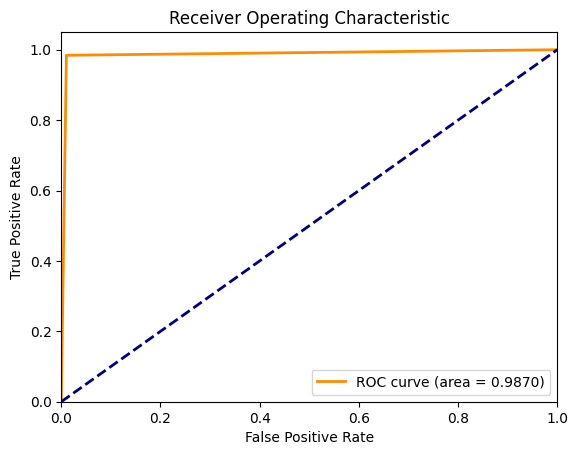

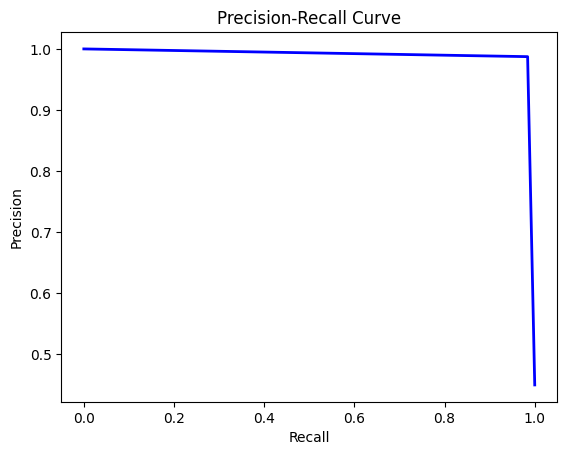

                                           Merged_Column  label  \
0      1. Pick up toothbrush and turn on the tap to w...      1   
1      ```\n1. Get toothbrush and toothpaste from the...      1   
2      1. Pick up a toothbrush.\n2. Apply toothpaste ...      1   
3      1. Set up toothbrush, toothpaste, and a cup of...      1   
4      1. Pick up toothbrush and apply toothpaste.\n2...      1   
...                                                  ...    ...   
14132  The first line should include the user's size ...      0   
14133  Take the bowl out of the cabinet. Take the cer...      0   
14134  The user will receive a large blue shirt with ...      0   
14135  1. Get the required materials: paper, pen, env...      0   
14136  Feeding a pet Input: Pour food  Output: Food i...      0   

       predicted_score  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4                  1.0  
...                ...  
14132              0

In [5]:
# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, ensemble_model.predict(X_test))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 绘制精确率-召回率曲线
precision, recall, _ = precision_recall_curve(y_test, ensemble_model.predict(X_test))
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig('precision_recall_curve.png', dpi=300)  # 保存图像，设置分辨率为300 DPI
plt.show()

# 保存最终模型和预测结果
data['predicted_score'] = np.nan
data.loc[y_train.index, 'predicted_score'] = train_meta_predictions
data.loc[y_test.index, 'predicted_score'] = test_meta_predictions

output_path = 'stacked_ensemble_predictions.xlsx'
data.to_excel(output_path, index=False)

# 打印结果
print(data)

## after tune

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from tqdm import tqdm

class StackedEnsembleModel:
    def __init__(self, base_models, meta_model, n_splits=10, n_repeats=1):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.train_predictions, self.test_predictions = self.get_stacked_base_predictions(X, y, X)

        self.meta_model.fit(self.train_predictions, y)

    def get_stacked_base_predictions(self, X, y, X_test):
        predictions_train = np.zeros((X.shape[0], len(self.base_models)))
        predictions_test = np.zeros((X_test.shape[0], len(self.base_models)))

        rkf = RepeatedKFold(n_splits=self.n_splits, n_repeats=self.n_repeats, random_state=42)

        for i, (model_name, model) in enumerate(tqdm(self.base_models.items(), desc="Training base models")):
            test_fold_predictions = np.zeros((X_test.shape[0], self.n_splits * self.n_repeats))
            for fold, (train_index, val_index) in enumerate(rkf.split(X)):
                X_fold_train, X_fold_val = X[train_index], X[val_index]
                y_fold_train, y_fold_val = y.iloc[train_index], y.iloc[val_index]

                model.fit(X_fold_train, y_fold_train)
                predictions_train[val_index, i] = model.predict_proba(X_fold_val)[:, 1]
                test_fold_predictions[:, fold] = model.predict_proba(X_test)[:, 1]

            predictions_test[:, i] = test_fold_predictions.mean(axis=1)

        return predictions_train, predictions_test

    def predict(self, X):
        base_preds = np.zeros((X.shape[0], len(self.base_models)))
        for i, (model_name, model) in enumerate(self.base_models.items()):
            base_preds[:, i] = model.predict(X)
        return self.meta_model.predict(base_preds)


# 读取数据
file_path = 'all_answer.xlsx'
data = pd.read_excel(file_path)

# 确保没有缺失值
data = data.dropna(subset=[data.columns[0], data.columns[1]])

# 准备特征和目标变量
X_text = data.iloc[:, 0]  # 第一列为文本数据
y = data.iloc[:, 1]  # 第二列为标签

# 文本向量化
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_text)

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化基模型和元模型
base_models = {
    "KNN": KNeighborsClassifier(n_neighbors=5,metric='euclidean'),
    "SVM": SVC(kernel='linear',C=1,probability=True),
    # "XGBoost": XGBClassifier(max_depth=3,n_estimators=200,gamma=0.2),
    # "XGBoost": XGBClassifier(max_depth=3,n_estimators=200,gamma=0.2),
    "XGBoost": XGBClassifier(max_depth=3,n_estimators=200,gamma=0.2)
}
meta_model = LogisticRegression(C=1) # C=10

# 创建集成模型实例
ensemble_model = StackedEnsembleModel(base_models, meta_model)

# 训练模型
ensemble_model.fit(X_train, y_train)

# 预测并评估模型
train_meta_predictions = ensemble_model.predict(X_train)
test_meta_predictions = ensemble_model.predict(X_test)

# 评估指标
train_accuracy = accuracy_score(y_train, train_meta_predictions)
test_accuracy = accuracy_score(y_test, test_meta_predictions)
train_precision = precision_score(y_train, train_meta_predictions)
test_precision = precision_score(y_test, test_meta_predictions)
train_recall = recall_score(y_train, train_meta_predictions)
test_recall = recall_score(y_test, test_meta_predictions)
train_f1 = f1_score(y_train, train_meta_predictions)
test_f1 = f1_score(y_test, test_meta_predictions)
train_roc_auc = roc_auc_score(y_train, train_meta_predictions)
test_roc_auc = roc_auc_score(y_test, test_meta_predictions)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Train F1 Score: {train_f1:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Train ROC AUC: {train_roc_auc:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, test_meta_predictions)
print(f'Confusion Matrix:\n{conf_matrix}')

# # 绘制ROC曲线
# fpr, tpr, _ = roc_curve(y_test, ensemble_model.test_predictions[:, 1])
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % test_roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# # 绘制精确率-召回率曲线
# precision, recall, _ = precision_recall_curve(y_test, ensemble_model.test_predictions[:, 1])
# plt.figure()
# plt.plot(recall, precision, color='b', lw=2)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# # plt.savefig('precision_recall_curve.png', dpi=300)  # 保存图像，设置分辨率为300 DPI
# plt.show()

# # 保存最终模型和预测结果
# data['predicted_score'] = np.nan
# data.loc[y_train.index, 'predicted_score'] = train_meta_predictions
# data.loc[y_test.index, 'predicted_score'] = test_meta_predictions

# output_path = 'stacked_ensemble_predictions.xlsx'
# data.to_excel(output_path, index=False)

# 打印结果
# print(data)


Training base models: 100%|██████████| 3/3 [06:12<00:00, 124.10s/it]


Train Accuracy: 0.9959
Test Accuracy: 0.9897
Train Precision: 0.9941
Test Precision: 0.9928
Train Recall: 0.9968
Test Recall: 0.9842
Train F1 Score: 0.9954
Test F1 Score: 0.9885
Train ROC AUC: 0.9960
Test ROC AUC: 0.9892
Confusion Matrix:
[[1546    9]
 [  20 1247]]


In [2]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.4 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=8a827530266ca47e55440f7ad820e80a23a0ed6005ece5427a8261cd70ce88e1
  Stored in directory: /Users/liuzifeng/Library/Caches/pip/wheels/ec/68/a9/de7d374ecb6f53462ce0eec8326fbab91b6228c82e67428d0d
Successfully built eli5

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import shap
import scipy.sparse

# 将 X_train 和 X_test 转换为密集矩阵
# X_train_dense = X_train.toarray()
# X_test_dense = X_test.toarray()

# 使用 shap.sample 函数来减少背景数据样本量
background_data = shap.sample(X_train, 10)

# 创建 KernelExplainer 对象
explainer = shap.KernelExplainer(ensemble_model.predict,background_data)  # 使用部分训练数据作为背景数据 , X_train_dense[:50]
 
# 计算 SHAP 值
shap_values = explainer.shap_values(X_test)

# 绘制 SHAP 值的汇总图
shap.summary_plot(shap_values, X_test, max_display=7)
shap.plots.waterfall(shap_values[0])


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/2822 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:1037: UserWarning: Unknown data type: <class 'scipy.sparse._lil.lil_matrix'>, trying to convert it to csr_matrix
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:1037: UserWarning: Unknown data type: <class 'scipy.sparse._lil.lil_matrix'>, trying to convert it to csr_matrix
  warnings.warn(
  0%|          | 1/2822 [13:30<635:07:56, 810.52s/it]/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:1037: UserWarning: Unknown data type: <class 'scipy.sparse._lil.lil_matrix'>, trying to convert it to csr_matrix
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:1037: UserWarning: Unknown data t

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap
from sklearn.feature_extraction.text import TfidfVectorizer

# 读取数据
file_path = 'all_answer.xlsx'
data = pd.read_excel(file_path)

# 确保没有缺失值
data = data.dropna(subset=[data.columns[0], data.columns[1]])

# 准备特征和目标变量
X_text = data.iloc[:, 0]  # 第一列为文本数据
y = data.iloc[:, 1]  # 第二列为标签

# 文本向量化
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_text)

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 定义模型
single_models = {
    "KNN": KNeighborsClassifier(n_neighbors=5,metric='euclidean'),
    "SVM": SVC(kernel='linear',C=1,probability=True),
    "XGBoost": XGBClassifier(max_depth=3,n_estimators=200,gamma=0.2),
    # "Logistic Regression": LogisticRegression(C=10),
    "Bagging": BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42),
    "AdaBoost": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
}

single_results = {}

# 使用单个模型进行训练和评估
for model_name, model in single_models.items():
    # 使用5折交叉验证
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    train_predictions = np.zeros(X_train.shape[0])
    test_predictions = np.zeros(X_test.shape[0])
    test_prob_predictions = np.zeros(X_test.shape[0])

    for train_fold_index, val_index in kf.split(X_train):
        X_fold_train, X_fold_val = X_train[train_fold_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_fold_index], y_train.iloc[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        train_predictions[val_index] = model.predict(X_fold_val)
        test_predictions += model.predict(X_test) / kf.get_n_splits()
        if hasattr(model, "predict_proba"):
            test_prob_predictions += model.predict_proba(X_test)[:, 1] / kf.get_n_splits()
        else:
            test_prob_predictions += model.decision_function(X_test) / kf.get_n_splits()

    # 评估指标
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions.round())
    train_precision = precision_score(y_train, train_predictions)
    test_precision = precision_score(y_test, test_predictions.round())
    train_recall = recall_score(y_train, train_predictions)
    test_recall = recall_score(y_test, test_predictions.round())
    train_f1 = f1_score(y_train, train_predictions)
    test_f1 = f1_score(y_test, test_predictions.round())
    train_roc_auc = roc_auc_score(y_train, train_predictions)
    test_roc_auc = roc_auc_score(y_test, test_prob_predictions)

    print(f'Model: {model_name}')
    print(f'Train Accuracy: {train_accuracy:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Train Precision: {train_precision:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Train Recall: {train_recall:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Train F1 Score: {train_f1:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print(f'Train ROC AUC: {train_roc_auc:.4f}')
    print(f'Test ROC AUC: {test_roc_auc:.4f}')

    # 混淆矩阵
    conf_matrix = confusion_matrix(y_test, test_predictions.round())
    print(f'Confusion Matrix:\n{conf_matrix}')

    # 保存结果
    single_results[model_name] = {
        "train_predictions": train_predictions,
        "test_predictions": test_predictions,
        "test_prob_predictions": test_prob_predictions
    }

# 绘制多个模型的PR曲线
# plt.figure(figsize=(10, 8))
# for model_name, result in single_results.items():
#     precision, recall, _ = precision_recall_curve(y_test, result["test_prob_predictions"])
#     plt.plot(recall, precision, lw=2, label=f'{model_name} (AUC = {roc_auc_score(y_test, result["test_prob_predictions"]):.4f})')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.savefig('precision_recall_curve_all_models.png', dpi=300)  # 保存图像，设置分辨率为300 DPI
# plt.show()

# 保存最终模型和预测结果
# for model_name, result in single_results.items():
#     data['predicted_score'] = np.nan
#     data.loc[train_index, 'predicted_score'] = result["train_predictions"]
#     data.loc[test_index, 'predicted_score'] = result["test_predictions"]

#     output_path = f'{model_name}_predictions.xlsx'
#     data.to_excel(output_path, index=False)

#     print(f'Results saved to {output_path}')


Model: KNN
Train Accuracy: 0.9423
Test Accuracy: 0.9376
Train Precision: 0.9380
Test Precision: 0.9475
Train Recall: 0.9322
Test Recall: 0.9116
Train F1 Score: 0.9351
Test F1 Score: 0.9292
Train ROC AUC: 0.9413
Test ROC AUC: 0.9630
Confusion Matrix:
[[1491   64]
 [ 112 1155]]
Model: SVM
Train Accuracy: 0.9872
Test Accuracy: 0.9848
Train Precision: 0.9838
Test Precision: 0.9826
Train Recall: 0.9877
Test Recall: 0.9834
Train F1 Score: 0.9857
Test F1 Score: 0.9830
Train ROC AUC: 0.9873
Test ROC AUC: 0.9990
Confusion Matrix:
[[1533   22]
 [  21 1246]]
Model: XGBoost
Train Accuracy: 0.9887
Test Accuracy: 0.9890
Train Precision: 0.9890
Test Precision: 0.9889
Train Recall: 0.9855
Test Recall: 0.9866
Train F1 Score: 0.9873
Test F1 Score: 0.9878
Train ROC AUC: 0.9884
Test ROC AUC: 0.9995
Confusion Matrix:
[[1541   14]
 [  17 1250]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-p

Model: Bagging
Train Accuracy: 0.9688
Test Accuracy: 0.9780
Train Precision: 0.9688
Test Precision: 0.9824
Train Recall: 0.9611
Test Recall: 0.9684
Train F1 Score: 0.9649
Test F1 Score: 0.9754
Train ROC AUC: 0.9681
Test ROC AUC: 0.9975
Confusion Matrix:
[[1533   22]
 [  40 1227]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-p

Model: AdaBoost
Train Accuracy: 0.9597
Test Accuracy: 0.9745
Train Precision: 0.9531
Test Precision: 0.9761
Train Recall: 0.9567
Test Recall: 0.9669
Train F1 Score: 0.9549
Test F1 Score: 0.9715
Train ROC AUC: 0.9594
Test ROC AUC: 0.9913
Confusion Matrix:
[[1525   30]
 [  42 1225]]


![alt text](image.png)

Train Accuracy: 0.9981
Test Accuracy: 0.9872
Train Precision: 0.9988
Test Precision: 0.9873
Train Recall: 0.9970
Test Recall: 0.9842
Train F1 Score: 0.9979
Test F1 Score: 0.9858
Train ROC AUC: 0.9980
Test ROC AUC: 0.9870
Confusion Matrix:
[[1539   16]
 [  20 1247]]

 

 Model: KNN
Train Accuracy: 0.9392
Test Accuracy: 0.9337
Train Precision: 0.9357
Test Precision: 0.9419
Train Recall: 0.9275
Test Recall: 0.9084
Train F1 Score: 0.9316
Test F1 Score: 0.9249
Train ROC AUC: 0.9381
Test ROC AUC: 0.9626
Confusion Matrix:
[[1484   71]
 [ 116 1151]]
Model: SVM
Train Accuracy: 0.9871
Test Accuracy: 0.9851
Train Precision: 0.9838
Test Precision: 0.9827
Train Recall: 0.9873
Test Recall: 0.9842
Train F1 Score: 0.9855
Test F1 Score: 0.9834
Train ROC AUC: 0.9871
Test ROC AUC: 0.9989
Confusion Matrix:
[[1533   22]
 [  20 1247]]
Model: XGBoost
Train Accuracy: 0.9881
Test Accuracy: 0.9894
Train Precision: 0.9884
Test Precision: 0.9882
Train Recall: 0.9849
Test Recall: 0.9882
Train F1 Score: 0.9867
Test F1 Score: 0.9882
Train ROC AUC: 0.9878
Test ROC AUC: 0.9995
Confusion Matrix:
[[1540   15]
 [  15 1252]]
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Model: Logistic Regression
Train Accuracy: 0.9859
Test Accuracy: 0.9837
Train Precision: 0.9843
Test Precision: 0.9826
Train Recall: 0.9841
Test Recall: 0.9811
Train F1 Score: 0.9842
Test F1 Score: 0.9818
Train ROC AUC: 0.9857
Test ROC AUC: 0.9989
Confusion Matrix:
[[1533   22]
 [  24 1243]]
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
Model: Bagging
Train Accuracy: 0.9693
Test Accuracy: 0.9755
Train Precision: 0.9701
Test Precision: 0.9831
Train Recall: 0.9609
Test Recall: 0.9621
Train F1 Score: 0.9655
Test F1 Score: 0.9725
Train ROC AUC: 0.9685
Test ROC AUC: 0.9978
Confusion Matrix:
[[1534   21]
 [  48 1219]]
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
Model: AdaBoost
Train Accuracy: 0.9585
Test Accuracy: 0.9724
Train Precision: 0.9546
Test Precision: 0.9722
Train Recall: 0.9523
Test Recall: 0.9661
Train F1 Score: 0.9535
Test F1 Score: 0.9691
Train ROC AUC: 0.9579
Test ROC AUC: 0.9910
Confusion Matrix:
[[1520   35]
 [  43 1224]]

9019


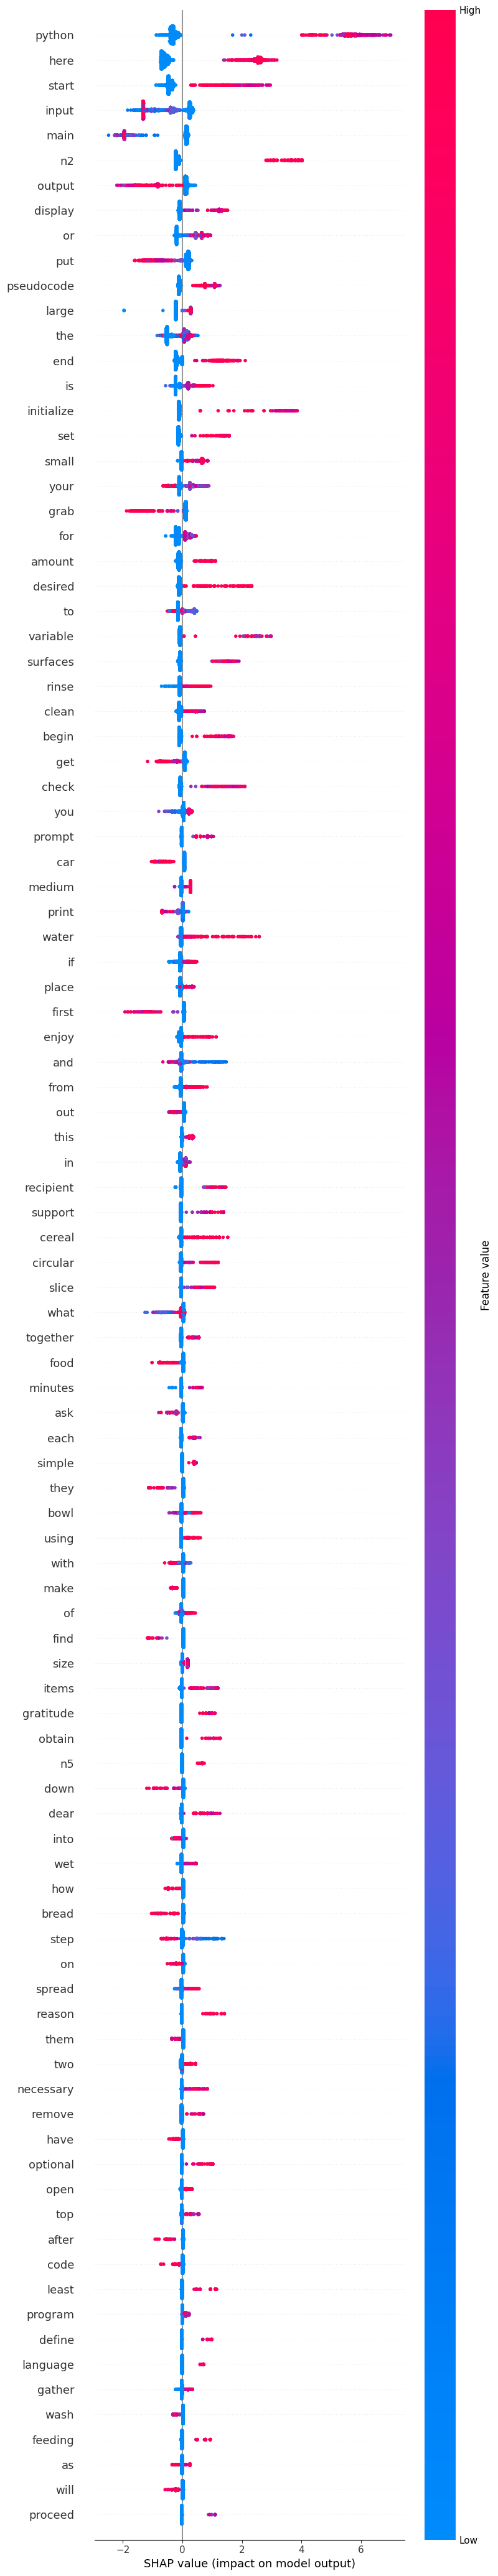

1. Start the water tap and wet your toothbrush
2. Apply toothpaste to the bristles of the toothbrush
3. Put the toothbrush in your mouth and brush your teeth in a circular motion for at least two minutes
4. Rinse your mouth with water after brushing
5. Use dental floss to clean between your teeth if necessary

Note: This is a simplified version of pseudocode and may not be suitable for implementation in a computer program.


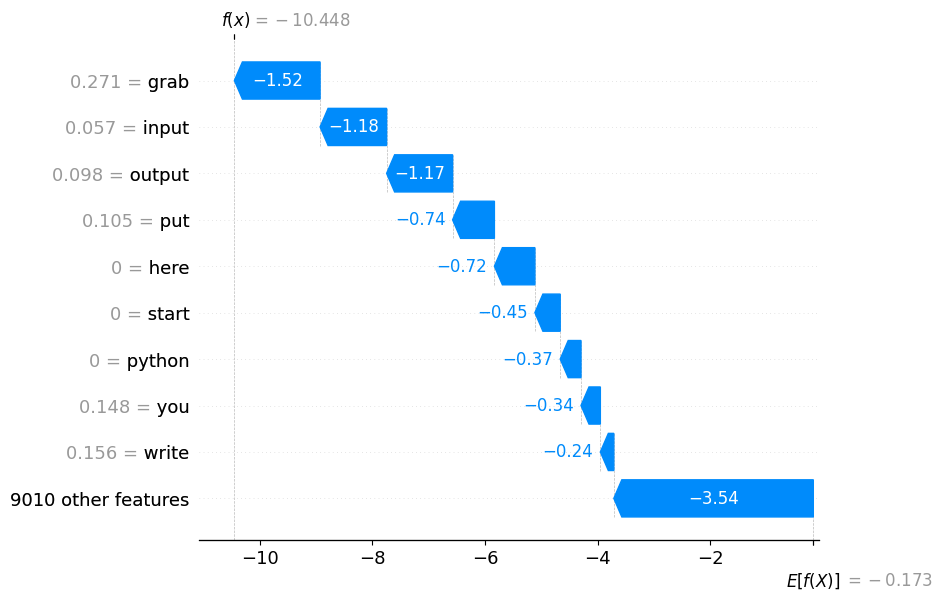

In [4]:
import shap
import scipy.sparse
import xgboost

# 使用 XGBoost 模型的解释器
explainer = shap.TreeExplainer(single_models['XGBoost'])

# 计算 SHAP 值
shap_values = explainer.shap_values(X_test)

# 获取特征名称
feature_names = vectorizer.get_feature_names_out()
print(len(feature_names))

# 绘制 SHAP 值的汇总图
shap.summary_plot(shap_values, X_test.toarray(), feature_names=feature_names, max_display=100)

# 创建 SHAP Explanation 对象
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test.toarray(),
    feature_names=feature_names
)
print(X_text.tolist()[70])
# 绘制 SHAP 值的瀑布图
shap.plots.waterfall(shap_explanation[70])

# visualize all the training set predictions
# shap.plots.force(shap_explanation[:500])
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values[:, "python"], color=shap_values)

41

Original content of incorrectly classified sample 6 (index 7300 in the original dataset):
Sensors will detect if there is a car in the washing area, if yes continue, if no then don't start and wait for a car to enter if yes, begin moving cleaning equipment towards car currently in the washing area and stop the car from moving. Create function CleanCar Spray car with cleaner Use scrubs and brushes on car after 10 seconds Spray car with water once finished scrubbing Repeat CleanCar Pull equipment away from the car Allow car to exit.


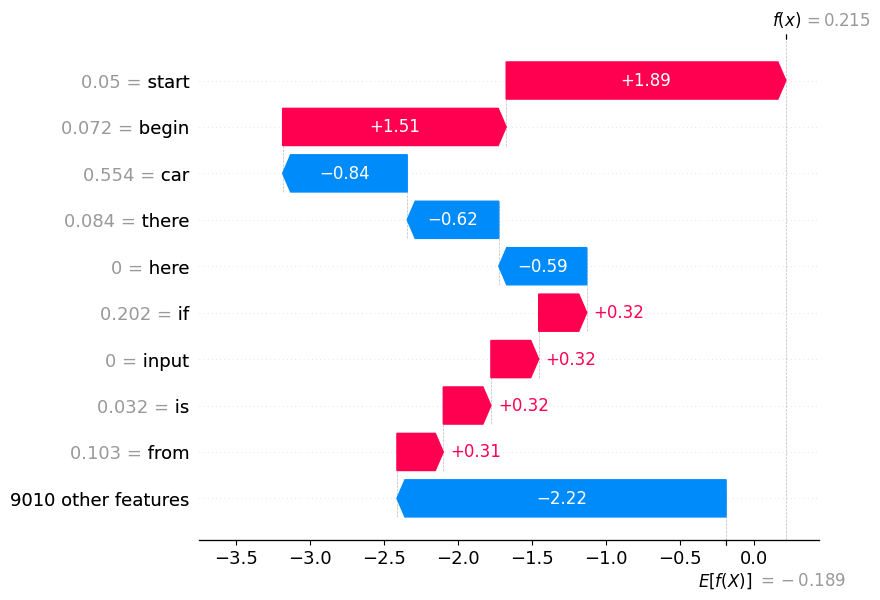


Original content of incorrectly classified sample 17 (index 7482 in the original dataset):
Pick up your toothbrush and toothpaste Wet the top of the toothbrush with water Apply toothpaste onto the top of the toothbrush Brush your teeth in circular motions for about 2 minutes. Spit out the excess toothpaste Rinse your mouth with water


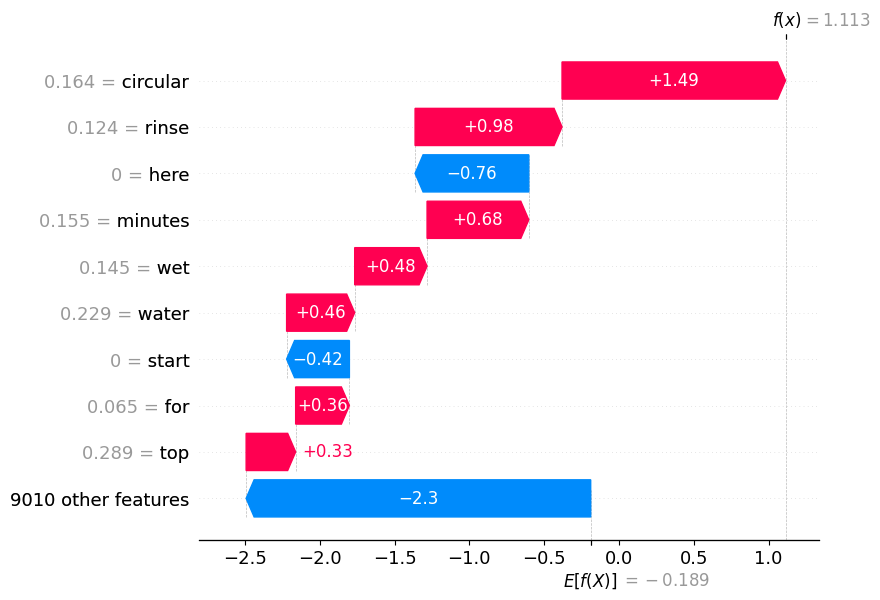


Original content of incorrectly classified sample 124 (index 3187 in the original dataset):
1. Start
2. Get_Bowl
    - Open cupboard
    - Take out 'Bowl'
3. Get_Cereal
    - Open pantry 
    - Take out 'Cereal Box'
    - Open 'Cereal Box'
    - Pour 'Cereal' into 'Bowl' until it's half full
    - Close 'Cereal Box'
4. Get_Milk
    - Open fridge
    - Take out 'Milk'
    - Open 'Milk'
    - Pour 'Milk' into 'Bowl' until 'Cereal' is covered with 'Milk'
    - Close 'Milk'
5. Get_Spoon
    - Open drawer
    - Take out '


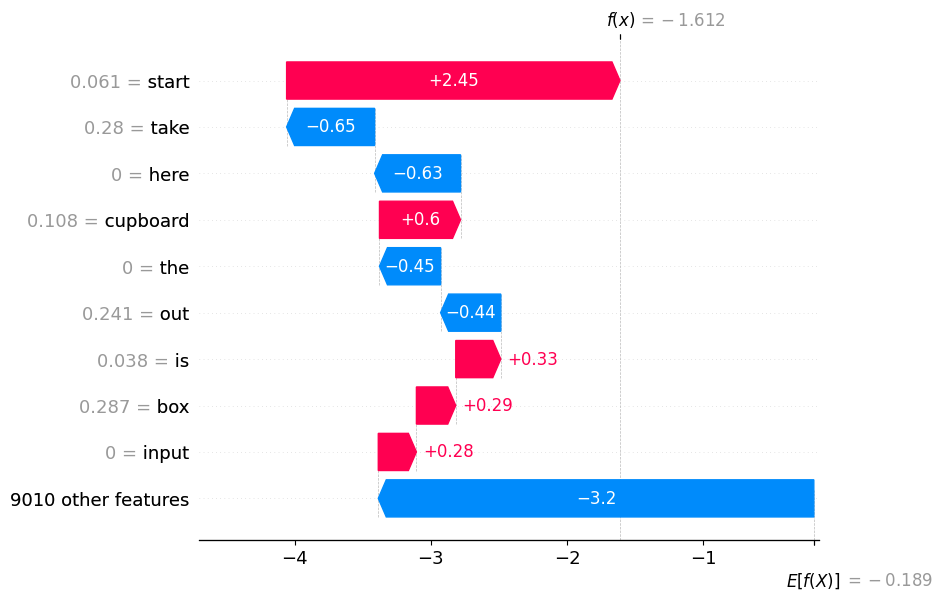


Original content of incorrectly classified sample 164 (index 9919 in the original dataset):
Ask user for his favourite team Ask user if they support this team for quality or for your city?   if the reason equals quality then print some support for the team print this is the best team for their quality. else if reason equals city ask user for their city print some support for the team print this is the heart of the selected city


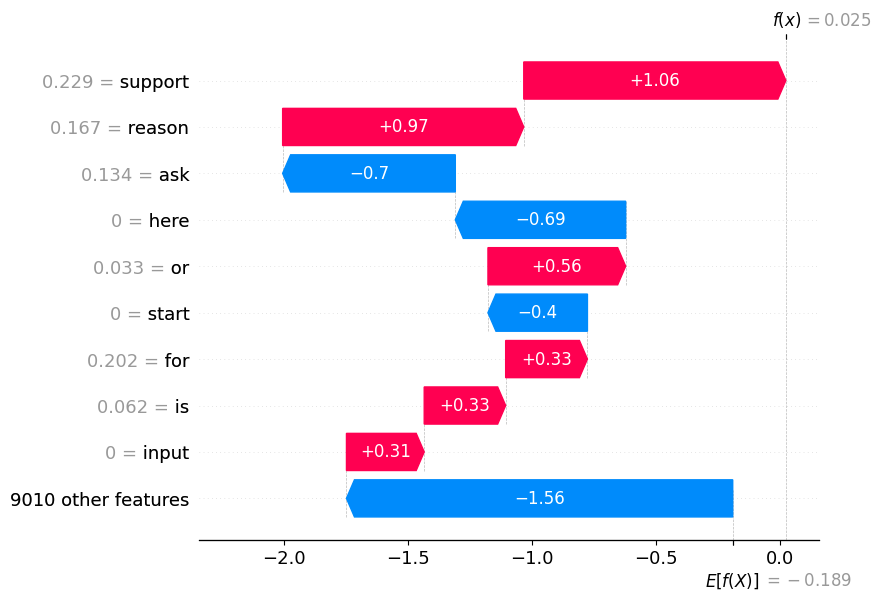


Original content of incorrectly classified sample 186 (index 290 in the original dataset):
```
1. Get a trash bag
2. Pick up any trash or garbage from the floor and put it in the trash bag
3. Put away any items that are out of place in their proper locations
4. Make the bed (if necessary)
5. Sweep or vacuum the floor
```


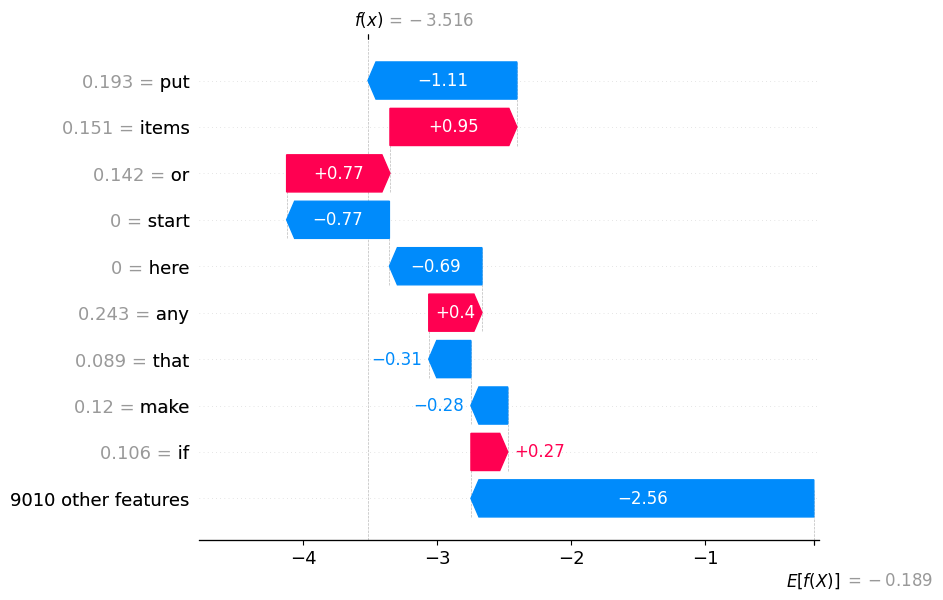


Original content of incorrectly classified sample 403 (index 2310 in the original dataset):
1. START
2. CREATE a list of tasks which includes 'Collect dirty laundry', 'Collect dishes', 'Put away objects', 'Dust', and 'Vacuum'.
3. FOR each task in the list:
   - IF task is 'Collect dirty laundry' THEN:
       - COLLECT all dirty clothes and put them in the laundry basket. 
   - ELSE IF task is 'Collect dishes' THEN:
       - COLLECT all dishes and put them in the kitchen sink.
   - ELSE IF task is 'Put away objects' THEN:
       - PICK up each object not in its proper place.
       - FIND the object's proper location and PLACE the object there.
   - ELSE IF task is 'Dust' THEN:


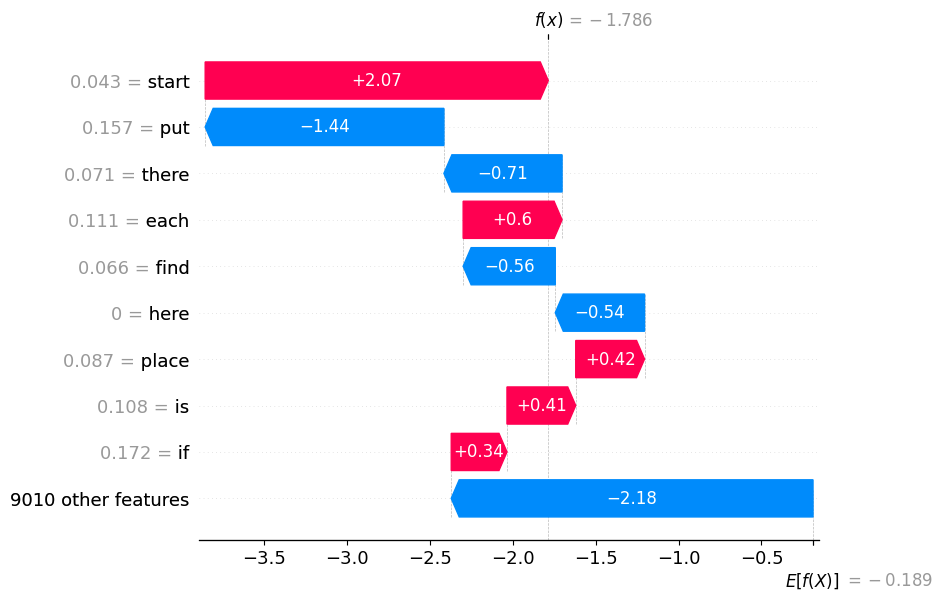


Original content of incorrectly classified sample 607 (index 7969 in the original dataset):
if gameday is today: aquire and wear team shirt wear as much team colors  as possible if you have face paint: put on face paint go to grocery store acquire chips, guacamole, bean dip, etc while paying for items, talk loudly and excited about how your team is going to win it today if you see someone wearing the same team colors as you: cheer loudly until they see you and acknowledge your shared excitement go home invite friends over to watch "the big game" set out snacks turn on TV to the "big game"'s channel at least 2 hours before the game is scheduled to start. #enjoy


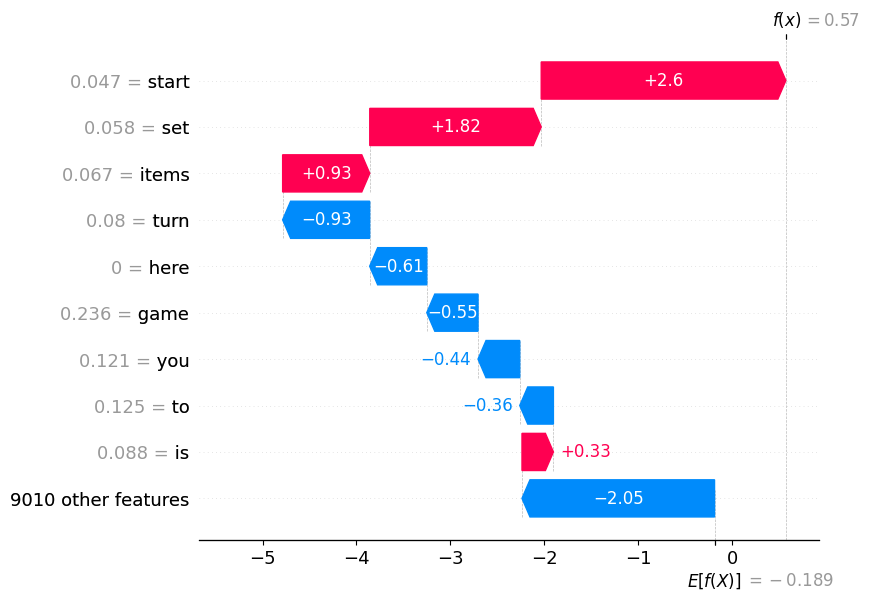


Original content of incorrectly classified sample 655 (index 10892 in the original dataset):
Enter comment explaining program shows how to show off your support for your favorite team Set Parameters for teams that include if-elif options for type of sport, team name and team home Direct user to choose his or her favorite team Direct user to choose his or her favorite place to support their team - such as home, local bar or stadium Print summary of inputs within one code line referring to user as his or her chosen team  print preset set of options based on the team they chose to allow them to compare their methods to the most commonly accessible ways to show spirit End program code


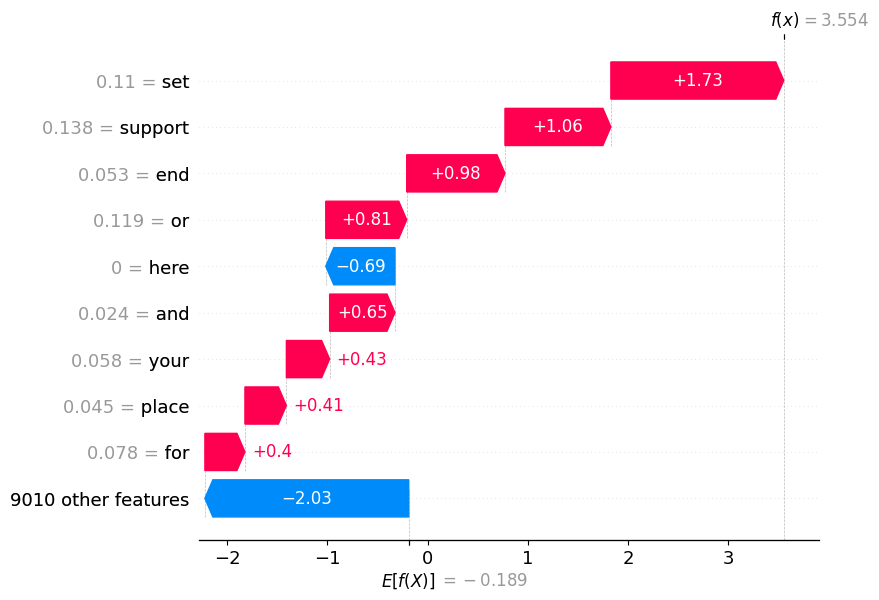


Original content of incorrectly classified sample 666 (index 1061 in the original dataset):
```
1. Pour cereal into bowl
2. Pour milk into bowl
3. Use spoon to stir cereal and milk together
4. Eat the cereal from the bowl using the spoon
5. Optionally, add toppings such as fruits or nuts
```


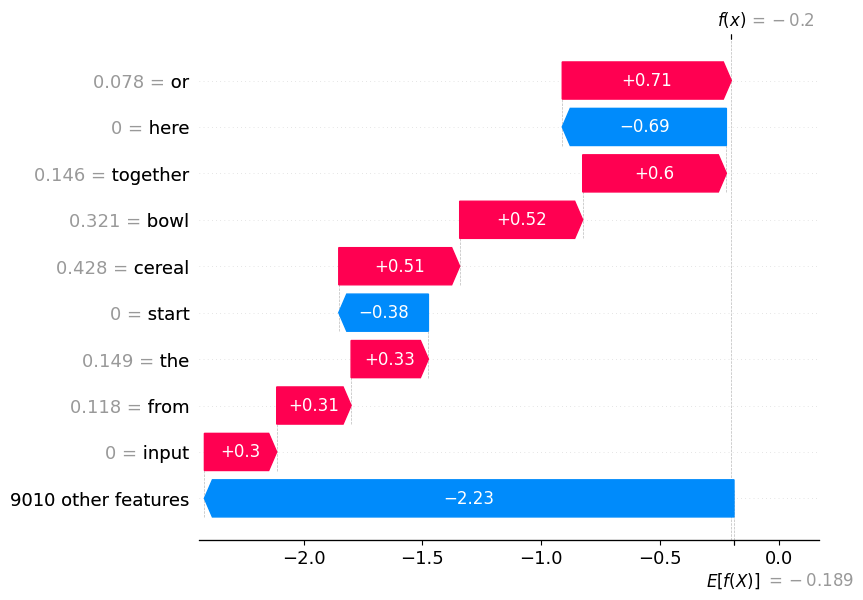


Original content of incorrectly classified sample 682 (index 3891 in the original dataset):
In what language should I write the basic outline for the program?


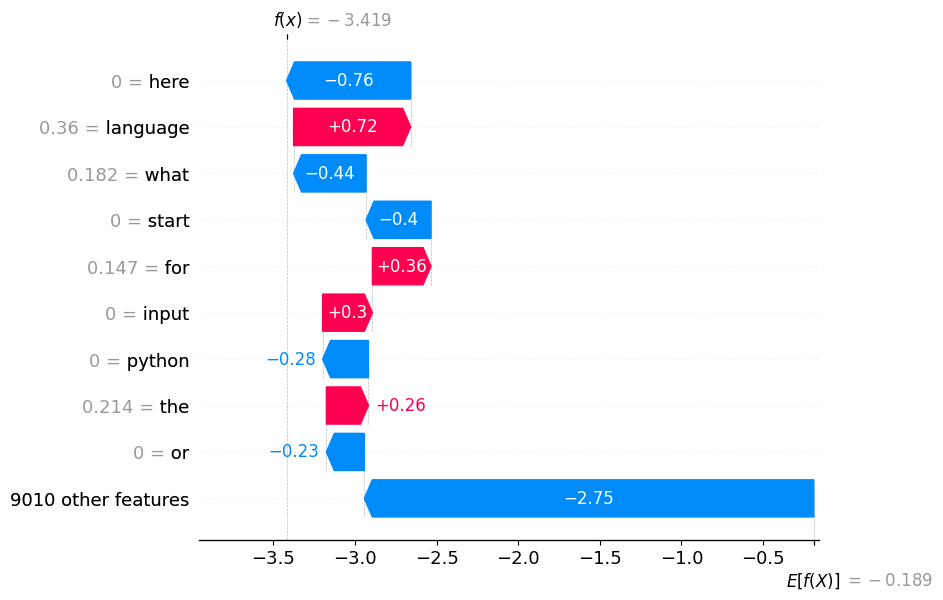


Original content of incorrectly classified sample 702 (index 3532 in the original dataset):
1. Start
2. Get a bowl and an ice cream scoop
3. Open the freezer and get out the ice cream tub.
4. With the ice cream scoop, dig into the ice cream tub and take out one or more scoops according to your preference  
5. Put the ice cream scoops into the bowl
6. Optional: Add toppings like syrup, whipped cream, cherries, sprinkles etc if you want 
7. Grab a spoon 
8. End


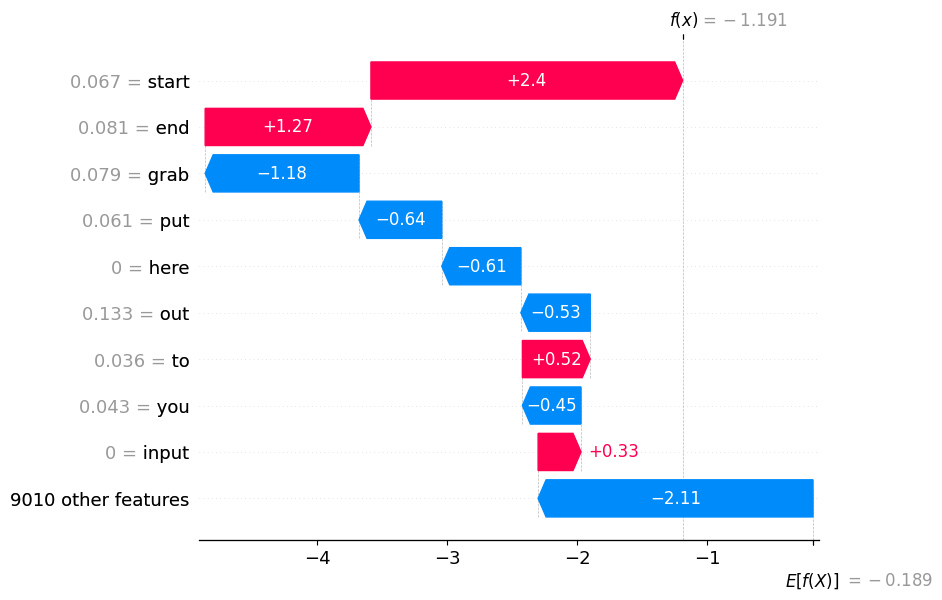


Original content of incorrectly classified sample 713 (index 977 in the original dataset):
1. Start the water flow
2. Wet the car thoroughly
3. Apply car washing soap to the entire surface of the car
4. Scrub the car using a sponge or mitt
5. Rinse off all the soap and dirt from the car


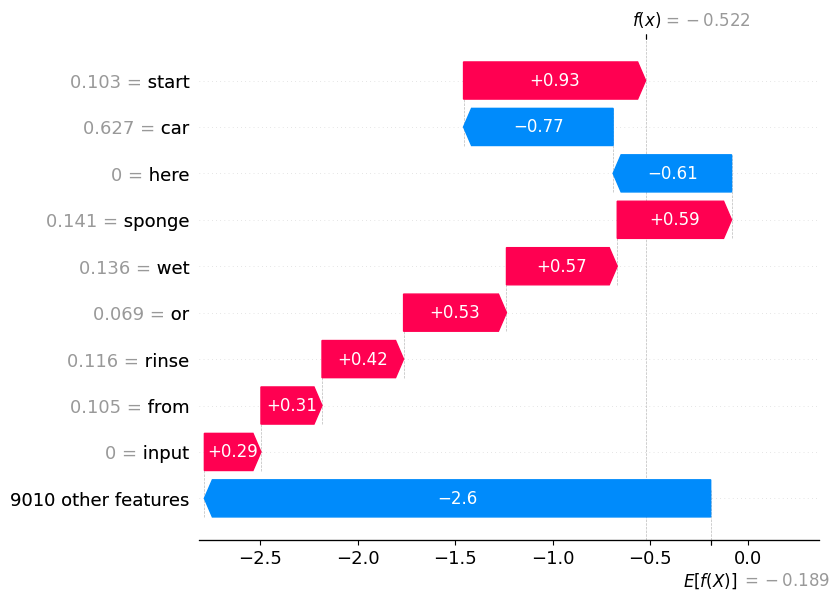


Original content of incorrectly classified sample 768 (index 11897 in the original dataset):
Input:  Create a class for thank-you notes. Output:  A class for thank-you notes will be created. Input:  Using the class, create an object and assign it to a variable. Output:  An object will be created using the class and it will then be assigned to a variable. Input:  Ask the user the name of the person he or she is sending the thank-you note to. Output:  An input function asking the user to type the name of the recipient will be assigned to a variable. Input:  Change the name of the thank-you note object to the name that the user gave. Output:  The thank-you note name will be changed to the name that the user gave. Input:  Display the thank-you note Output:  One print statement will display the thank-you note object.


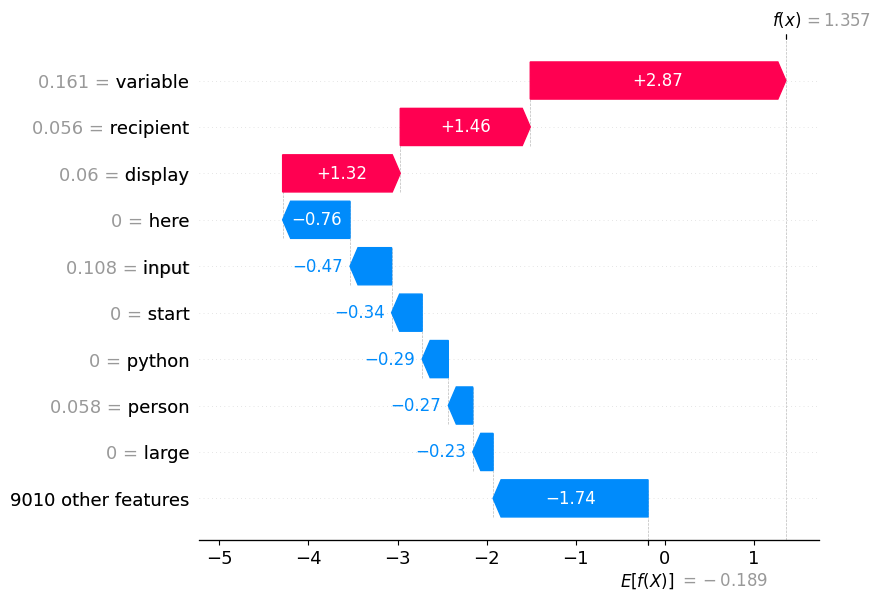


Original content of incorrectly classified sample 916 (index 2909 in the original dataset):
1. Begin 
    1.1 GatherIngredients: Get two slices of bread, one jar of peanut butter, one jar of jelly and one knife.

2. Process 
    2.1 MakePBJ:Open the jar of peanut butter
    2.2 UseKnife: Scoop out enough peanut butter with the knife to cover one side of one slice of bread in a thin layer 
    2.3 ApplyPeanutButter: Spread the peanut butter on bread
    2.4 RepeatSteps : Repeat steps 2.1 through 2.3 for jelly, applying it to the other slice of bread 
    2.5 CombineBreadSlices: Press the two slices of bread


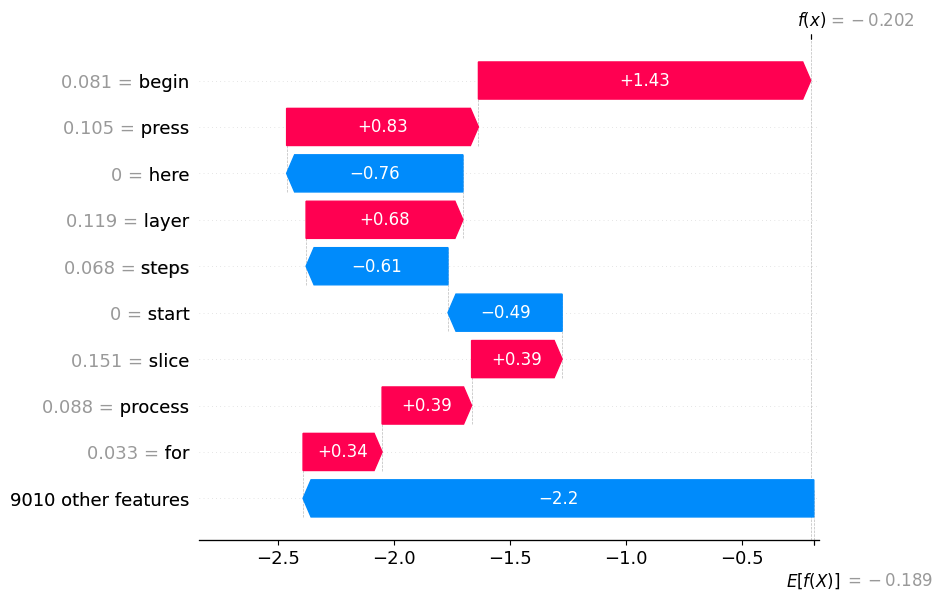


Original content of incorrectly classified sample 1015 (index 2796 in the original dataset):
1. Begin_Pet_Feeding_Process

2. Prepare_Pet_Food
   2.1. Identify the type of food the pet eats
   2.2. Get the correct amount of food needed for the pet

3. Feed_Pet
   3.1. Locate the pet
   3.2. Place the food into the pet's dish
   3.3. Ensure the pet starts eating

4. Cleanup_After_Feeding
   4.1. Store any leftover/unused pet food
   4.2. Clean any spills or mess made during the feeding

5. End_Pet_Feeding_Process


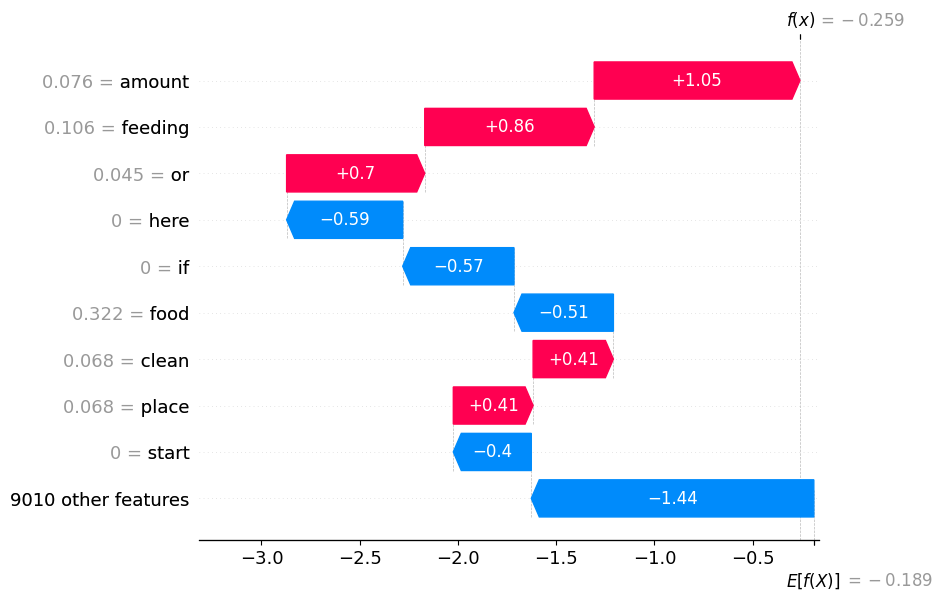


Original content of incorrectly classified sample 1045 (index 41 in the original dataset):
1. Get your toothbrush and toothpaste.
2. Squeeze a pea-sized amount of toothpaste onto the toothbrush.
3. Wet the toothbrush with water.
4. Brush your teeth in a circular motion, making sure to brush each tooth and the gum line.
5. Rinse your mouth with water and spit out the toothpaste.


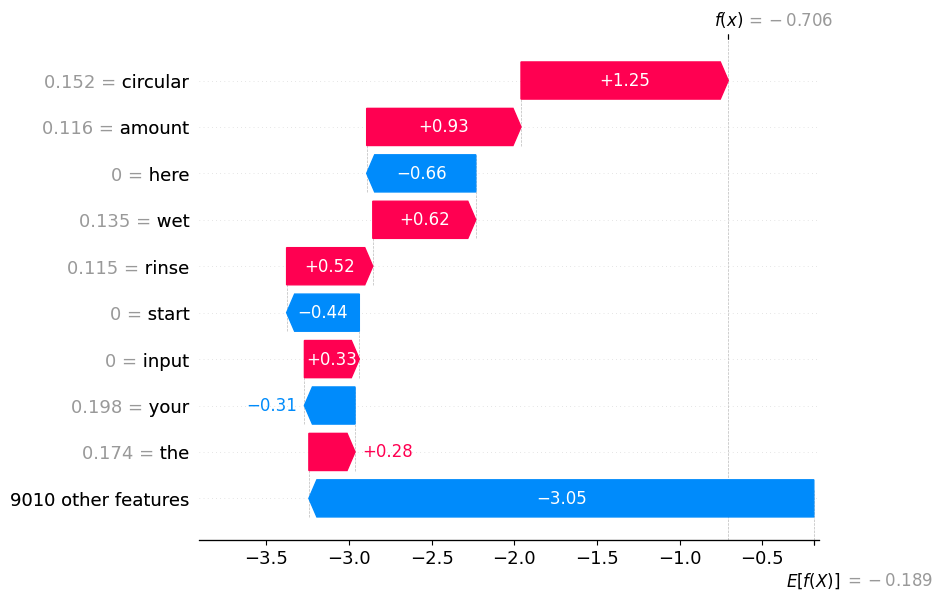


Original content of incorrectly classified sample 1137 (index 3015 in the original dataset):
1. Start
2. Gather all necessary supplies: bucket with soap and water, sponge, hose, drying cloth.
3. Wet the car completely using the hose
    3.1. Begin from the top and move downwards to ensure all dirt is moved off the car.
4. Soap up the sponge and wash the car
    4.1. Start from the top of the car and move downwards.
    4.2. In circular motions, spread the soap over the car.
5. Rinse the soap off the car using the hose
    5.1. Start from the top of the car and move downwards to ensure all soap is removed.
6. Use the drying cloth to dry the car


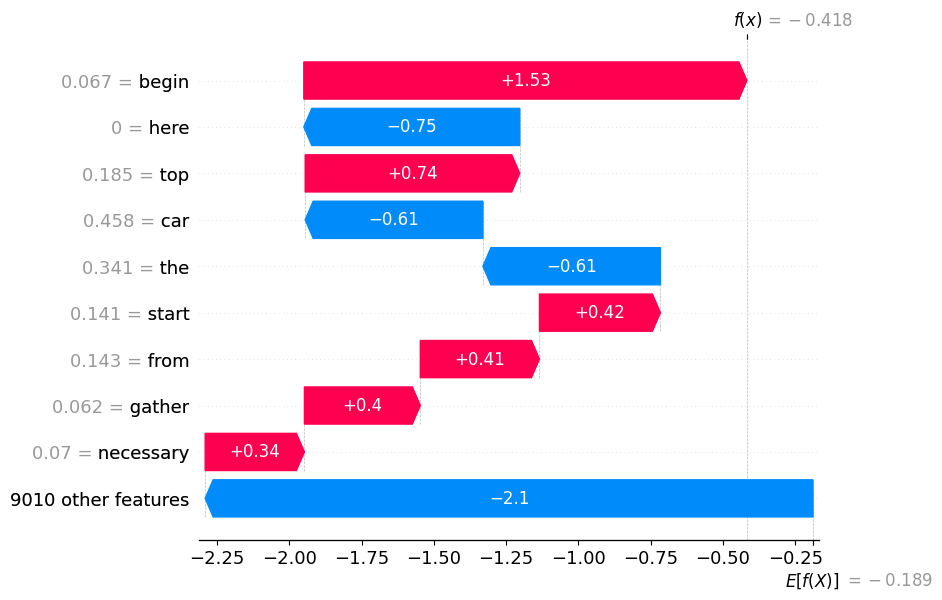


Original content of incorrectly classified sample 1207 (index 10471 in the original dataset):
1. Startup 2. Prepare for cleaning the vehicle, you can do this by getting a bucket and filling it with water and soap, make sure to also have a sponge within the mix. 3. Start by using the water hose to rinse down your vehicle starting from the roof. You'll start by taking your sponge that is soaked in soap and you'll begin rubbing the top of the car, rubbing hard to try to remove any dirt or grime on the room, then finish with a clean rinse from the hose. 4. Start focusing the water hoses stream on the car's exterior body. Use the hose to spray down any dirt or wet marks on the body of the car. 5. Begin washing the tires. Take your sponge and run hard on the tires removing any grime or dirt on the rim or wheel itself.  6. Drying your vehicle. You do this by taking a clean rag and rubbing and wiping away all wet spots on the car making it dry.


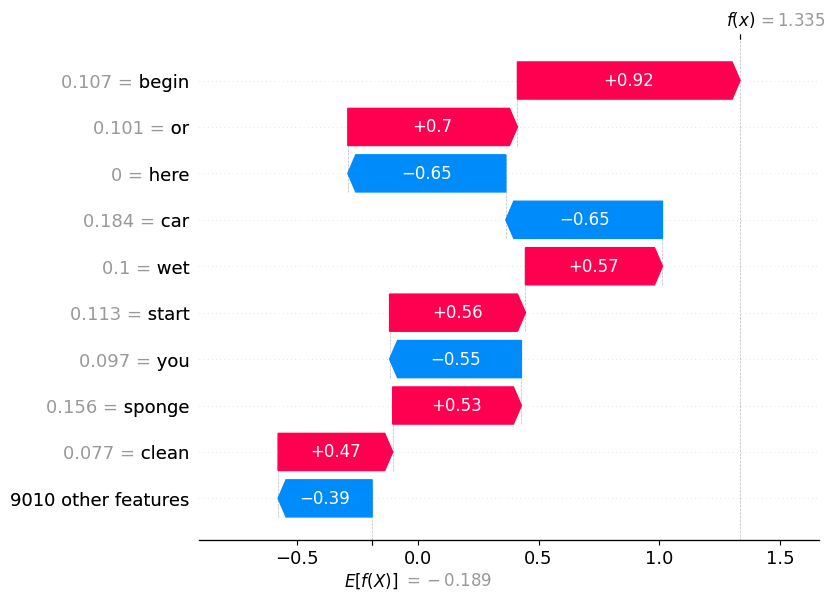


Original content of incorrectly classified sample 1213 (index 8064 in the original dataset):
PROMPT for person's name GET person's name DISPLAY greet and person's name DISPLAY introduction on how to feed a pet DISPLAY the proper utilities for pet food  why you should clean the utilities and how to  the recommended food for a dog and cat  the recommended amount of times to feed the food you should not feed to your pet Purpose: Prompt the user to provide their name, so that the computer can give a proper introduction to the "lesson" by greeting them and explaining the purpose of the program. Then, introduce the topic of the program, "How to Feed your Pet," with a prologue. Then, print at least 5 things that the user should know regarding feeding their pet.


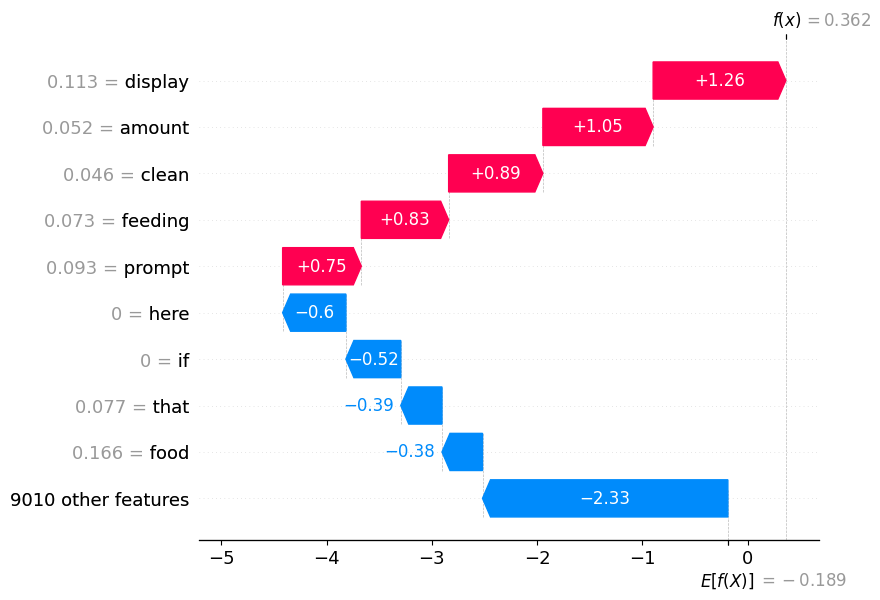


Original content of incorrectly classified sample 1233 (index 13985 in the original dataset):
1:check if food bowl is full 2:if food bowl is empty, have it continue if full, stop here 3:Grab dog food 4:fill bowl with dog food 5:call dog over for food


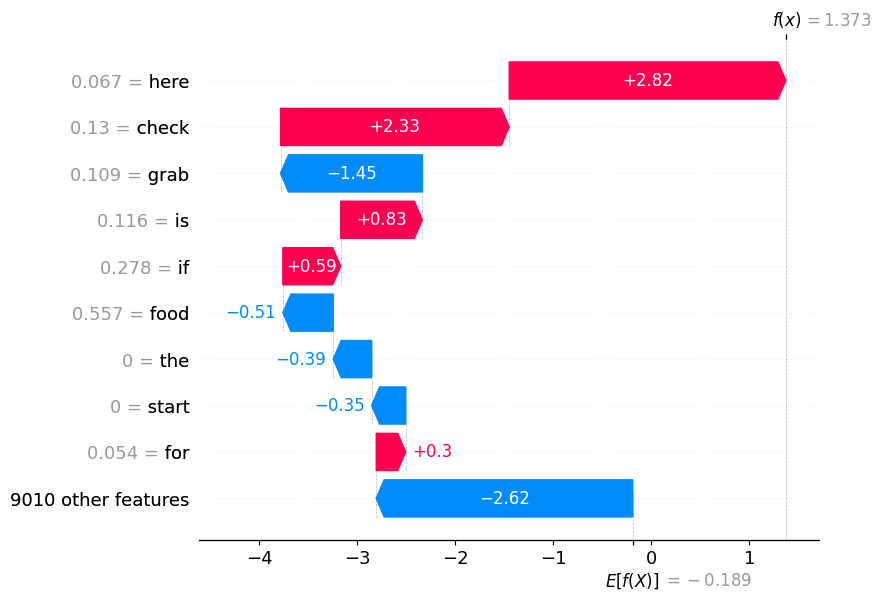


Original content of incorrectly classified sample 1251 (index 7093 in the original dataset):
1. Define the recipient and the occasion for the thank-you note. 2. Write a personalized opening expressing your gratitude and appreciation. 3. Mention specific reasons why you are grateful and how the recipient's actions or gifts have helped you. 4. Write a concluding sentence expressing gratitude and a willingness to keep in touch. 5. Sign off with a polite and personalized closing and your name.


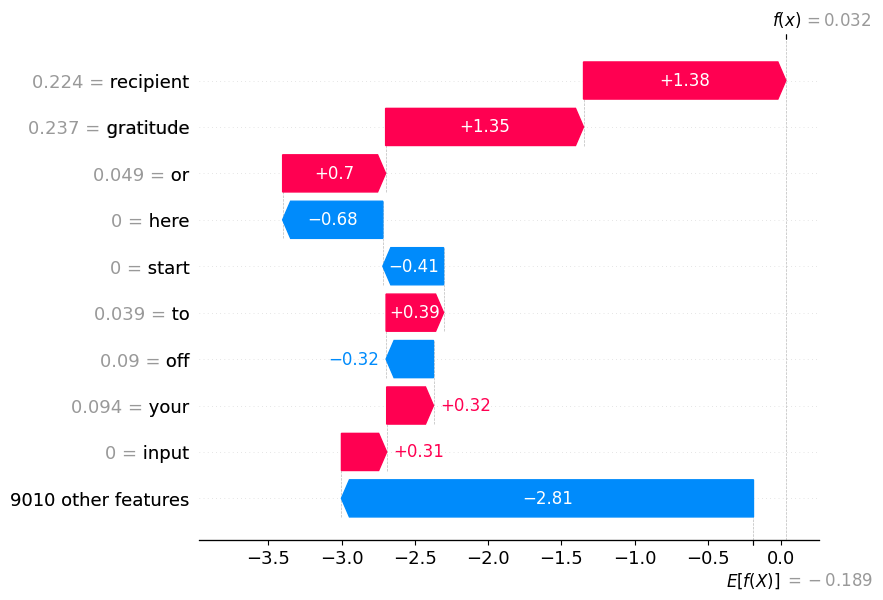


Original content of incorrectly classified sample 1321 (index 2595 in the original dataset):
1. BEGIN
2. DECLARE favoriteTeam as string
3. INPUT favoriteTeam
4. OUTPUT "Hooray for " + favoriteTeam + "!"
5. OUTPUT "Showing team spirit for " + favoriteTeam + " by wearing team jersey!"
6. OUTPUT "Shout out a cheer: Go " + favoriteTeam +"!"
7. OUTPUT "Show team colors, paint face in " + favoriteTeam + "'s colors!"
8. OUTPUT "Share team spirit on social media with hashtag #" + favoriteTeam
9. END


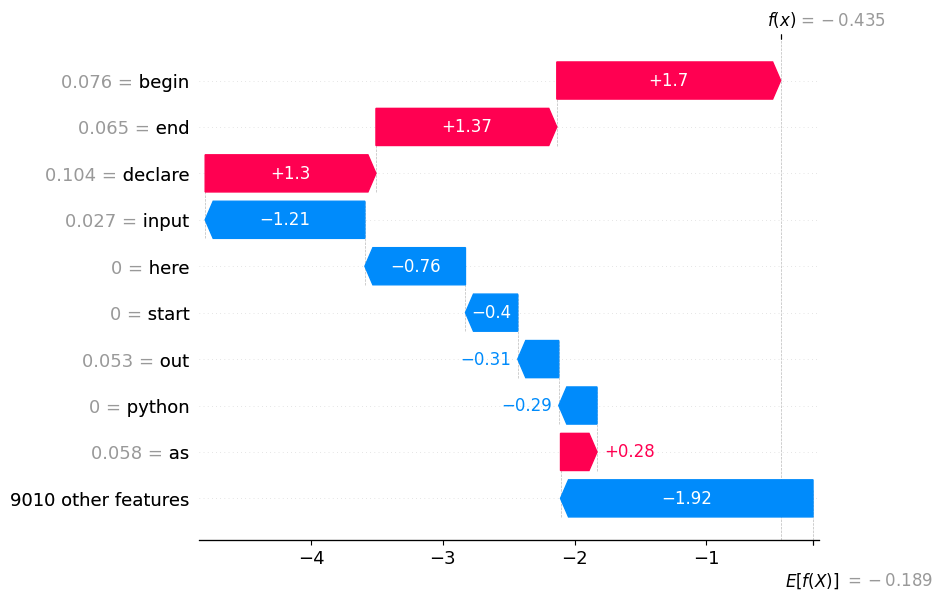


Original content of incorrectly classified sample 1414 (index 8629 in the original dataset):
1. Get your toothbrush, toothpaste, and a cup of water  2. Open the toothpaste and apply a small amount to the toothbrush  3. Wet the toothbrush with water  4. Brush teeth in circular motion for 2 minutes, making sure to reach all areas  5. Rinse mouth and toothbrush with water


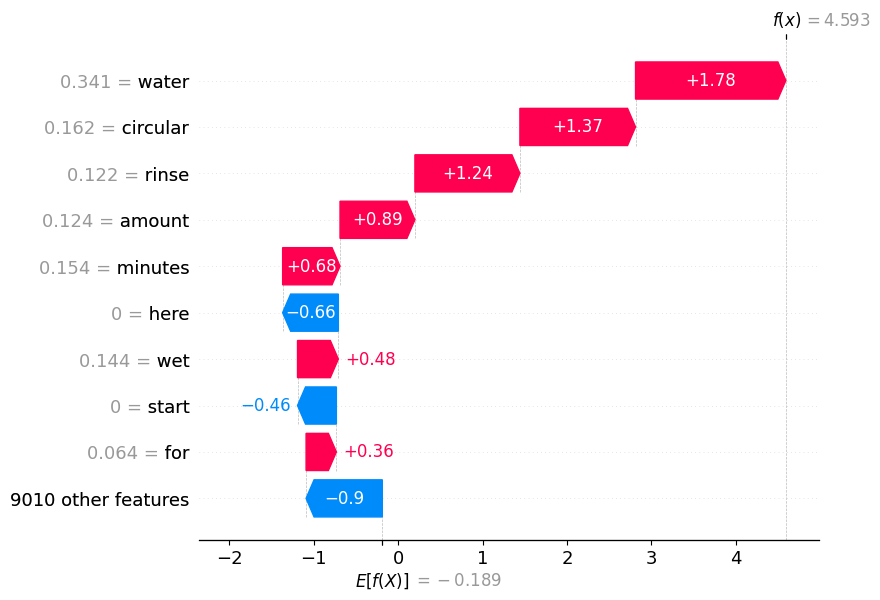


Original content of incorrectly classified sample 1521 (index 7417 in the original dataset):
Input: Tell User to make their toothbrush slightly wet with water. Tell User to open their toothpaste cap. Tell User to squeeze out enough toothpaste to cover the toothbrush bristles. Tell User to start brushing their front teeth with the bristles of the toothbrush with moderate force and speed. Tell User to work their way to the inner surfaces and chewing surfaces of their teeth.  Tell User to spit out the toothpaste foam and rinse mouth with water. Output: print a set of instructions to tell user how to brush teeth and clean their mouth


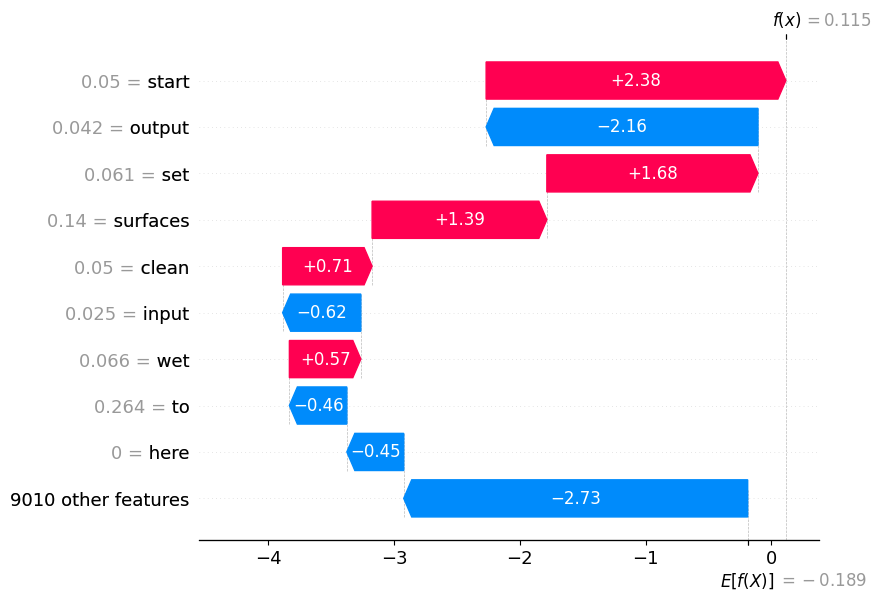


Original content of incorrectly classified sample 1650 (index 3461 in the original dataset):
1. Start:
2. Print "Dear [Recipient's Name],"
3. Print "I hope this message finds you well."
4. Print "I am deeply thankful for [specific thing recipient did for you or gift they gave you]. Your kindness and generosity mean a lot to me."
5. Print "Thank you once again for your thoughtful gesture."
6. Print "Sincerely, [Your name]"
7. End.


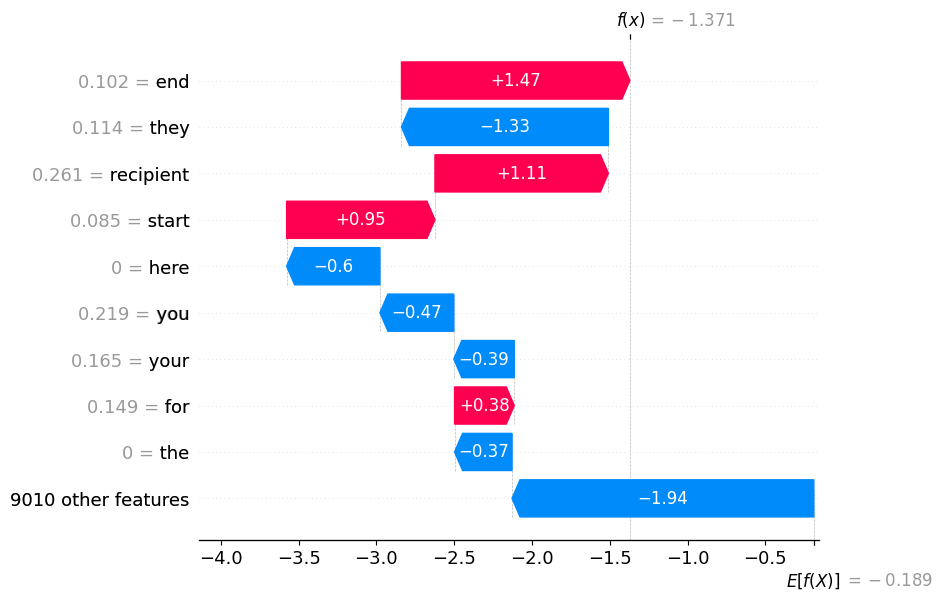


Original content of incorrectly classified sample 1691 (index 8410 in the original dataset):
Initialize: walk into your bathroom and inspect your teeth in the mirror. Inputs: after inspecting your teeth in the mirror, get a toothpaste bottle and an actual toothpaste from a cabinet in the bathroom.  Action: Remove the cover of the toothpaste and squeeze some toothpaste out of it to be 'pasted' upon the tooth portion of the toothbrush.  Process: gently place the toothbrush along the margins and surface of your teeth, with the toothpaste coming into contact with it, and move the toothbrush in a manner such that it is moving from one side of your teeth to the other, covering each tooth completely.  Result: Properly spit out the toothpaste from your mouth after a good deal of toothbrushing, and then gargle your mouth to spit out any remaining contents inside of the mouth, and finally look at your teeth in the mirror to see how clean it is!


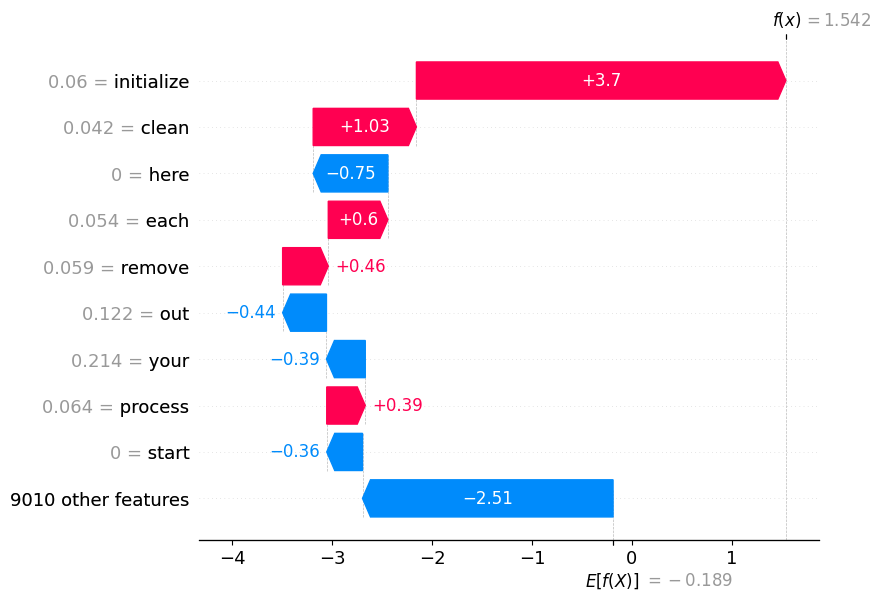


Original content of incorrectly classified sample 1730 (index 2984 in the original dataset):
1. Begin
2. Fetch and lay out the needed ingredients: bread, peanut butter, and jelly.
3. Spread a layer of peanut butter on one side of the first slice of bread, utilizing a knife.
    3.1 Pick up knife
    3.2 Dip knife into peanut butter jar
    3.3 Use knife to spread peanut butter on one side of a slice of bread
4. Spread a layer of jelly on one side of the second slice of bread, utilizing the same knife.
    4.1 Clean the knife
    4.2 Dip knife into jelly jar
    4.3 Use knife to spread jelly on one side of the other slice of bread
5. Place


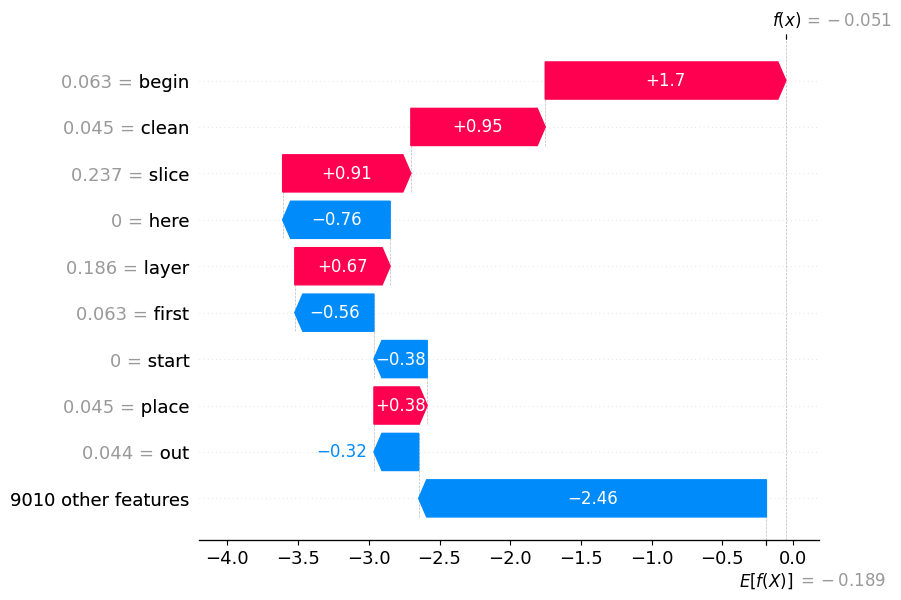


Original content of incorrectly classified sample 1818 (index 10624 in the original dataset):
Define MAIN function:         Set a variable drawersClean to false         Set a variable sheetsClean to false         Set drawersDone to 0         Set sheetsDone to 0         Get input for the total # of sheets on the bed, set it to sheetNum         Get input for the total # of drawers in the room's cabinets, set it to drawerNum         Vacuum the floor         Create a while loop to repeat until drawersClean is true                  Clean out a drawer in one of the cabinets                  Add 1 to drawersDone                  If drawersDone equals to drawerNum then                              Set drawersClean to true          Create a while loop to repeat until sheetsClean is true                  Put a sheet on the bed and tuck it in'                  Add 1 to sheetsDone                  If drawersDone equals to sheetNum then                              Set sheetsClean to true Execute 

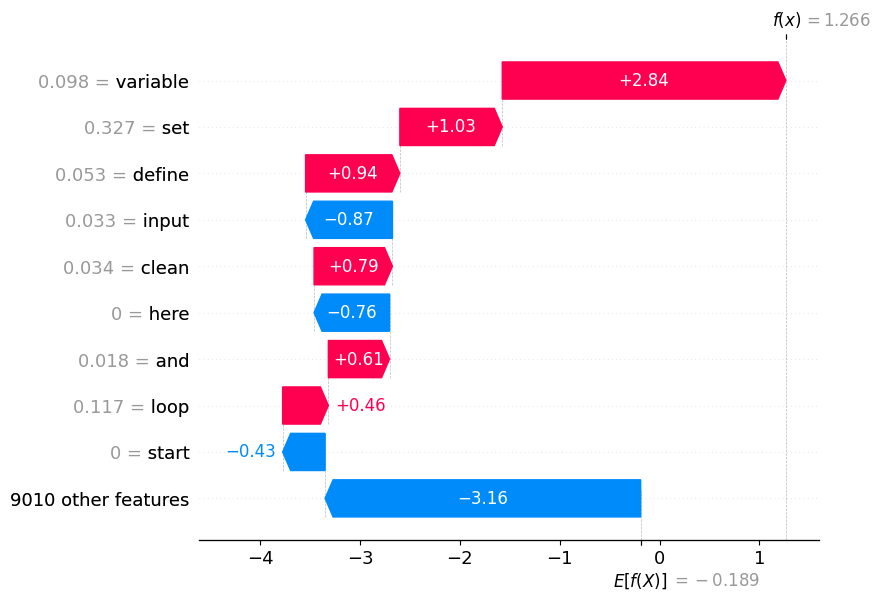


Original content of incorrectly classified sample 1902 (index 3146 in the original dataset):
Pseudocode:

1. START
2. GET bowl
3. GET cereal
4. POUR cereal into bowl
5. GET milk
6. POUR milk into bowl with cereal
7. GET spoon
8. EAT cereal
9. END


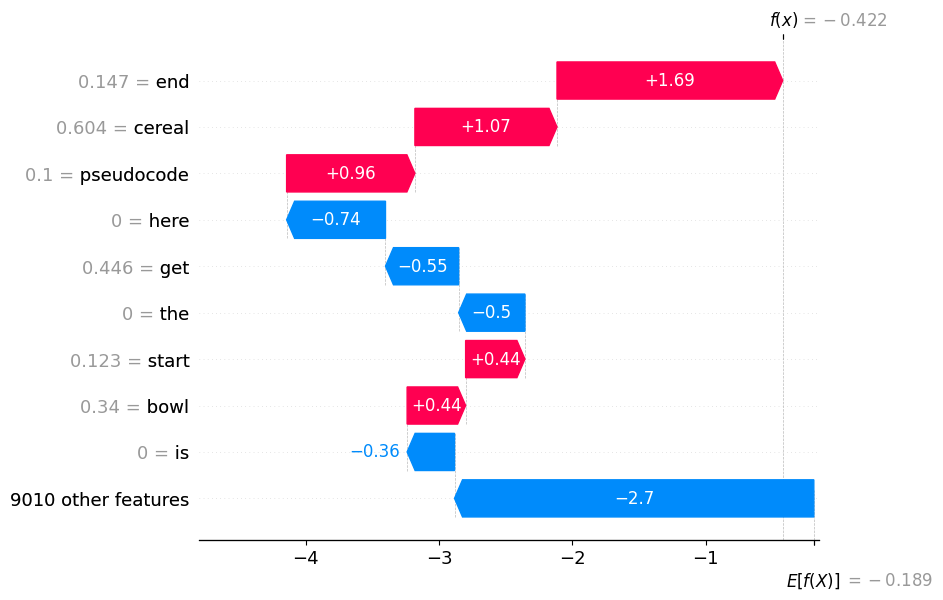


Original content of incorrectly classified sample 1960 (index 447 in the original dataset):
1. Check the upcoming game schedule for the favorite team.
2. Design and create team spirit gear or accessories such as jerseys, hats, flags, or face paint.
3. Organize a watch party with friends and family to cheer on the team.
4. Create and share social media posts with encouraging messages and support for the team.
5. Attend the game in person or virtually, actively participate in cheers and chants, and show unwavering support throughout the game.


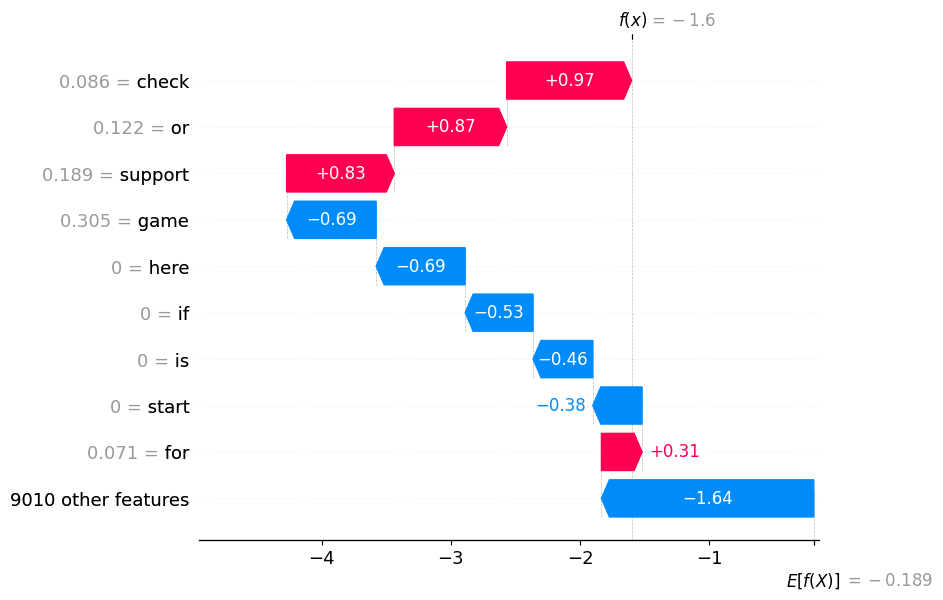


Original content of incorrectly classified sample 2035 (index 1488 in the original dataset):
1. Set the bowl on the counter.
2. Take the ice cream out of the freezer.
3. Scoop the desired amount of ice cream into the bowl.
4. Put the ice cream back in the freezer.
5. Enjoy your bowl of ice cream!


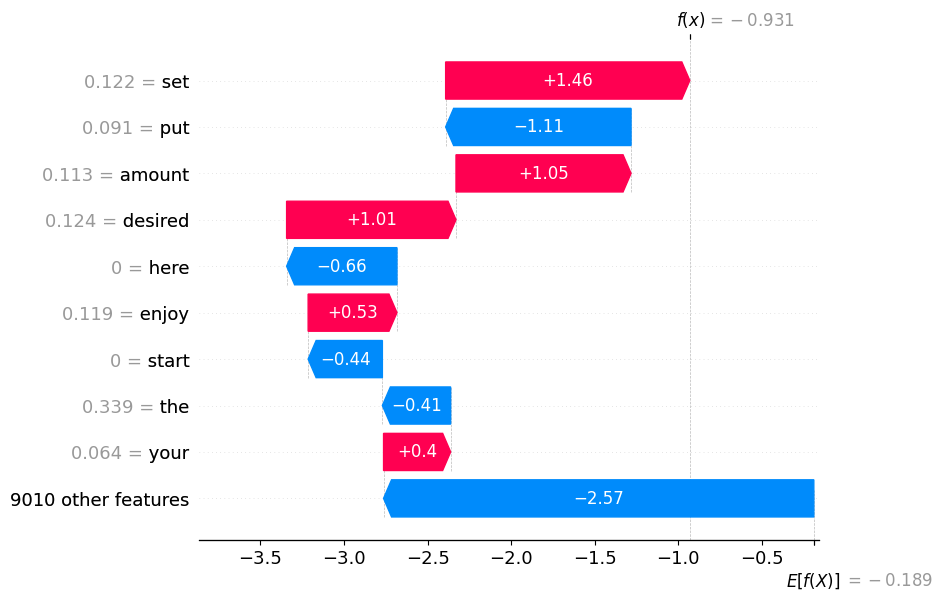


Original content of incorrectly classified sample 2114 (index 967 in the original dataset):
1. Fill up a bucket with water and mix in car wash soap.
2. Wet the car with a hose to loosen dirt and debris.
3. Use a sponge or wash mitt to scrub the car's exterior, starting from the top and working your way down.
4. Rinse off the soap and dirt with a hose.
5. Dry the car using a microfiber towel to prevent water spots and streaks.


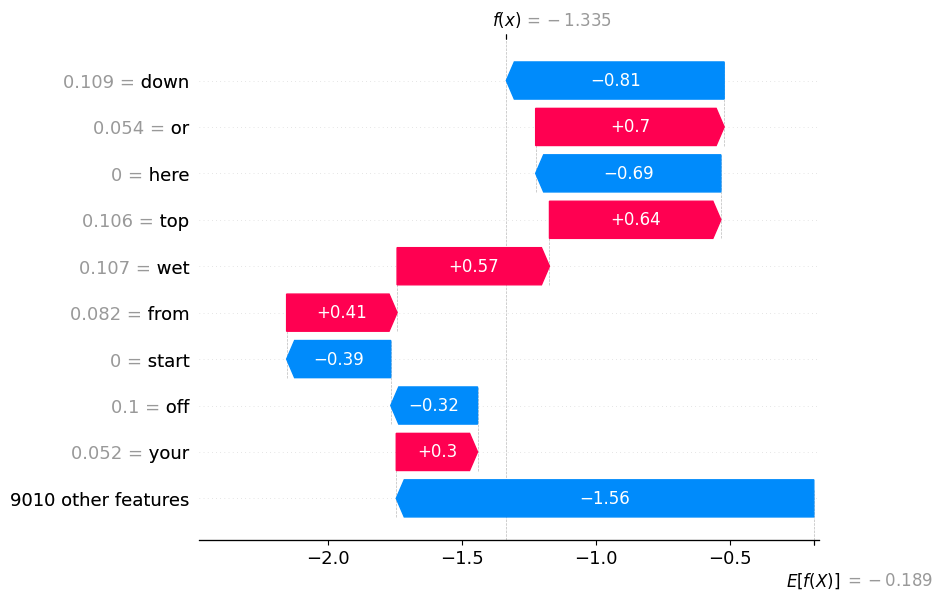


Original content of incorrectly classified sample 2124 (index 59 in the original dataset):
1. Pick up toothbrush and apply toothpaste
2. Wet the toothbrush under running water
3. Brush teeth in a circular motion for 2 minutes
4. Rinse mouth with water and spit out the toothpaste
5. Clean toothbrush and put it back in its place


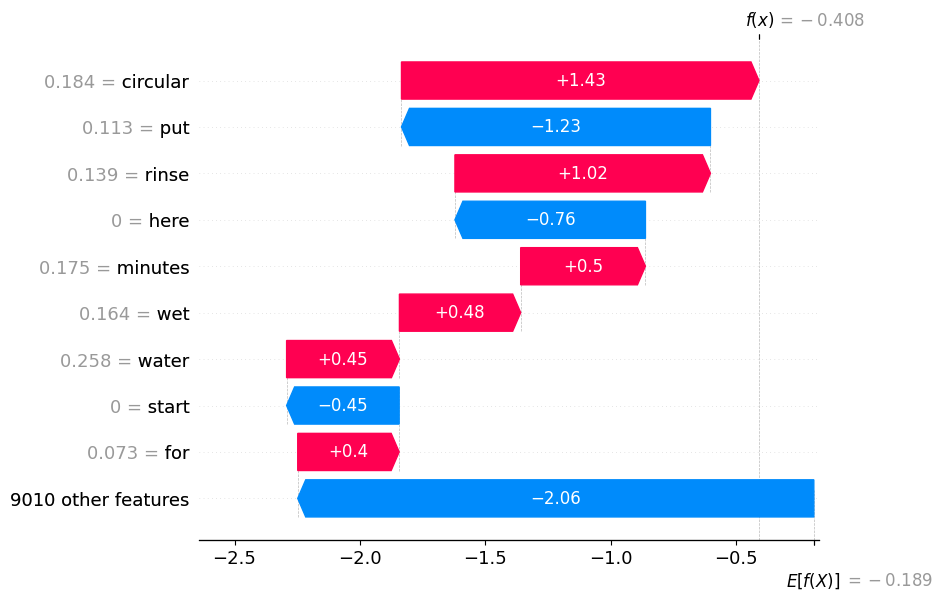


Original content of incorrectly classified sample 2168 (index 12271 in the original dataset):
Pseudocode to Clean My Room: Part One, Organization: 1. Assess the room  2. Begin organizing the messiness of the room Part Two Begin Cleaning: 3. Pick up objects and place them in the correct places 4. Do any laundry or extra cleaning necessary  5. Vacuum the room


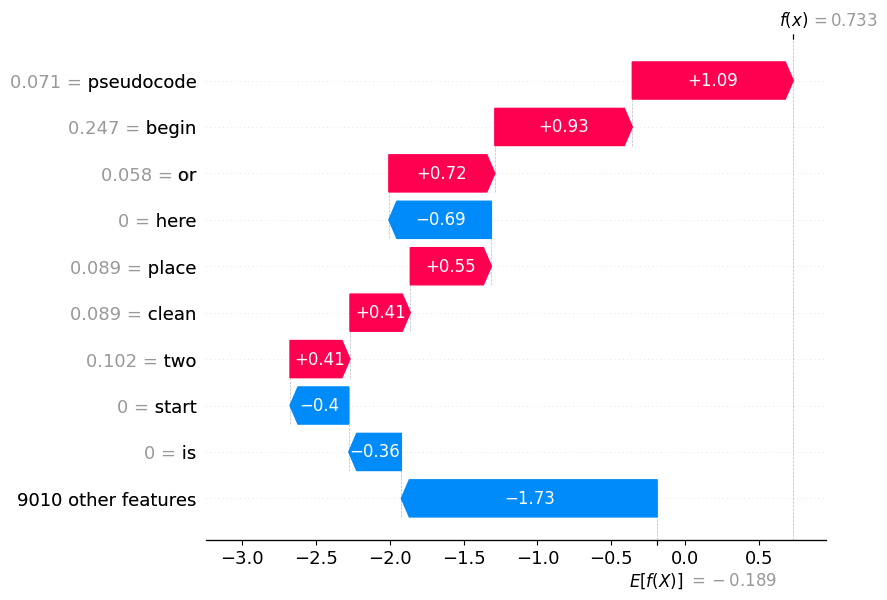


Original content of incorrectly classified sample 2186 (index 6572 in the original dataset):
Prepare a bowl and spoon  Assemble cereal, milk, and optional toppings from the pantry/fridge Pour the desired amount of cereal  Optional: Add toppings  Pour the desired amount of milk over cereal and toppings  Place spoon in bowl


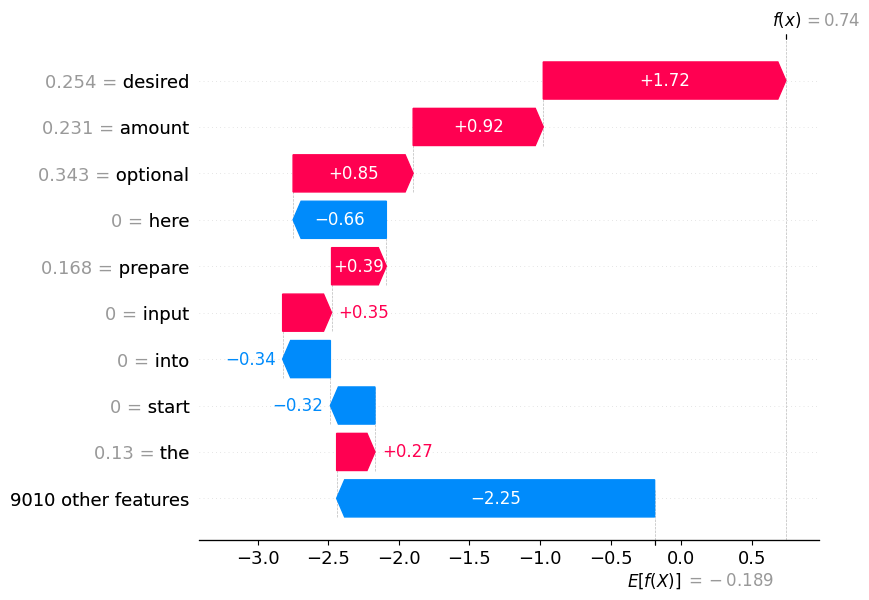


Original content of incorrectly classified sample 2235 (index 2992 in the original dataset):
1. Start
2. GatherIngredients: Bread, Peanut Butter, Jelly, Knife
3. Take two pieces of bread from the Bread packet.
4. Apply Peanut Butter on one side of one piece of Bread, using Knife.
5. Apply Jelly on one side of the second piece of Bread, using Knife.
6. Place the Peanut Buttered side of the first piece on the Jellied side of the second piece, forming the sandwich.
7. End.


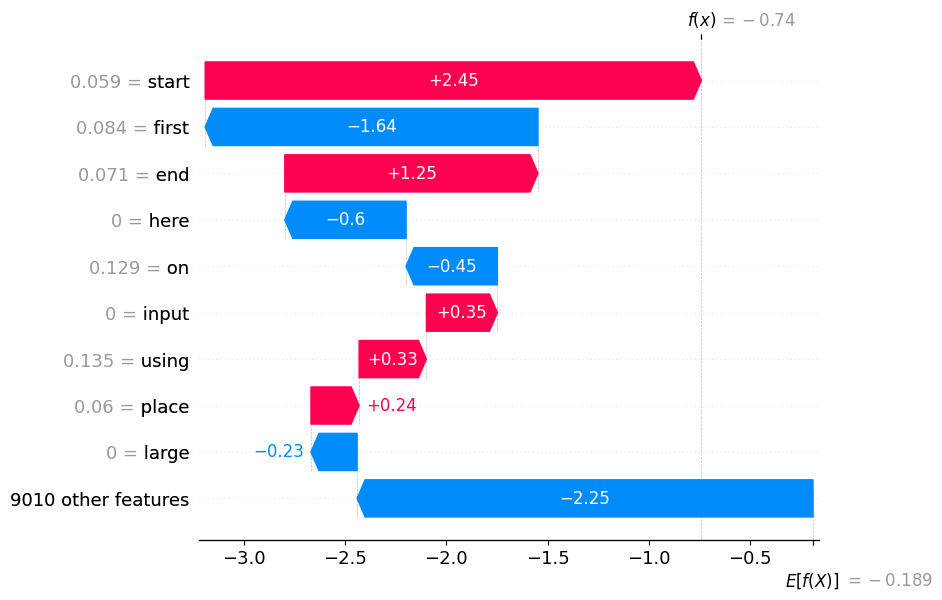


Original content of incorrectly classified sample 2345 (index 11427 in the original dataset):
Start print: Step one rinse off all sides of the car with hose print: Step two apply soapy water to all sides of the car. print: step three rinse the car with water print: step four repeat steps one-three until the car is sparkling clean print: step five dry off the car with a towel and a quick ride around the block End


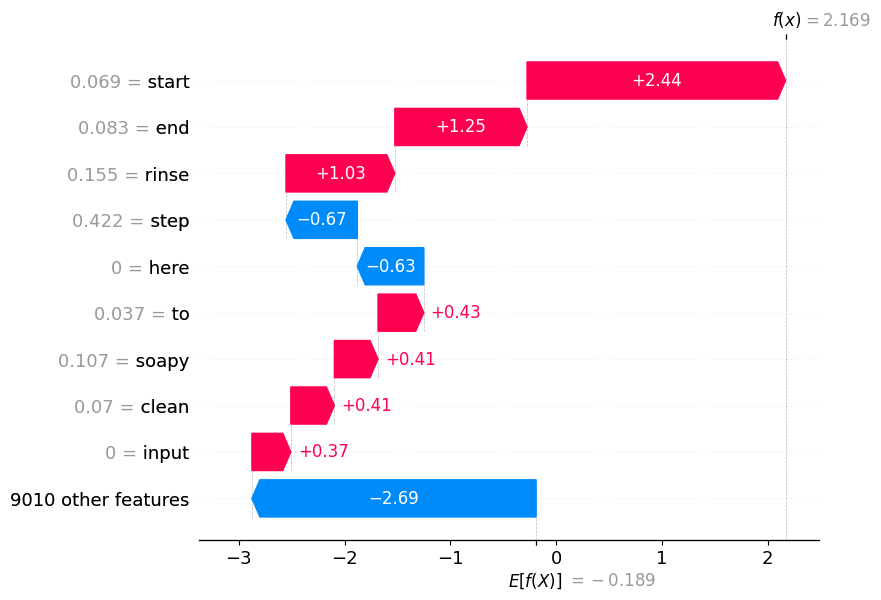


Original content of incorrectly classified sample 2403 (index 1496 in the original dataset):
1. Obtain a bowl and a scoop of ice cream.
2. Place the scoop of ice cream into the bowl.
3. Optionally, add any desired toppings (e.g. chocolate sauce, sprinkles).
4. Grab a spoon.
5. Enjoy your bowl of ice cream!


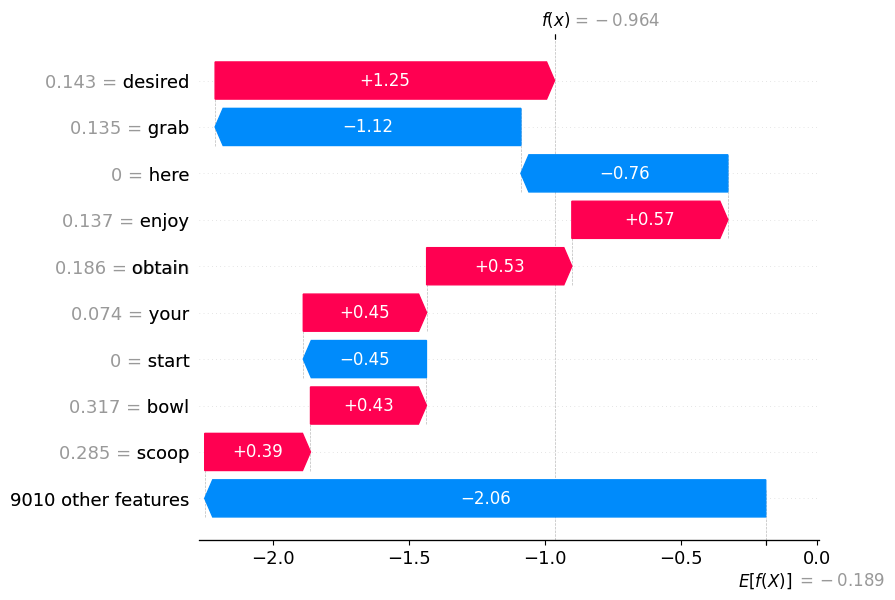


Original content of incorrectly classified sample 2484 (index 11292 in the original dataset):
Inputs: Teeth, toothbrush, toothpaste, water Pick up toothbrush Wet toothbrush with water Pick up toothpaste Open toothpaste Squeeze to apply pea-sized amount of toothpaste to toothbrush Close toothpaste Put toothpaste down Expose teeth by opening mouth Bring toothbrush to mouth Scrub teeth using toothbrush Continue for two minutes Remove toothbrush from mouth Spit out suds and toothpaste from mouth Rinse toothbrush with water Put toothbrush down Rinse teeth with water Close mouth Outputs: Clean Teeth


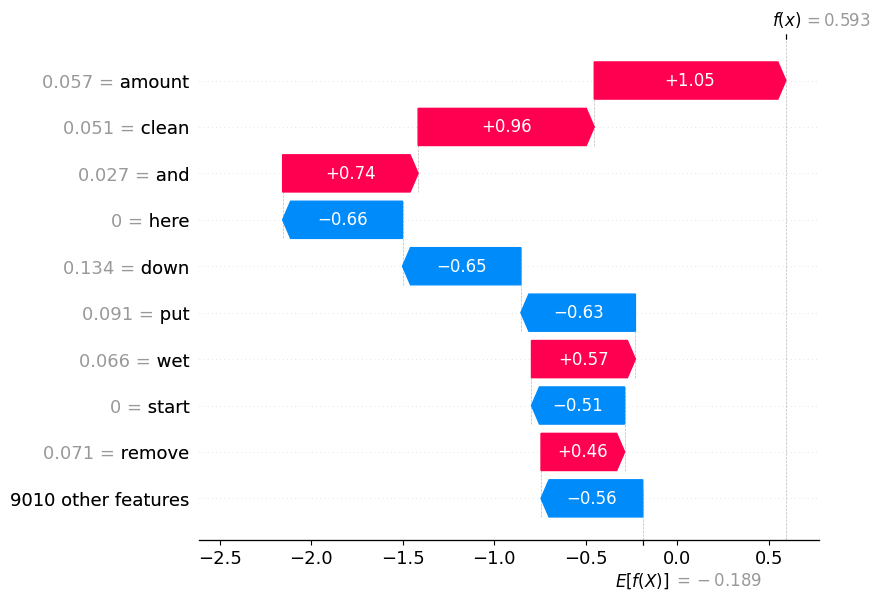


Original content of incorrectly classified sample 2614 (index 4176 in the original dataset):
As an AI Text Model, I can't write complete code in interactive IDEs that require cognitive services with mouse-clicks/keyboard manipulation. But, I can certainly provide Java and Python code snippets that could help you implement the same.

```Java
import java.util.Scanner;

public class TShirtOrder {
    public static void main(String[] args) {
        Scanner input = new Scanner(System.in);

        System.out.println("Enter shirt size (small, medium, large, or extra-large):");
        String size = input.nextLine();

        System.out.println("Enter shirt color (blue, green, red, or yellow):");
        String color = input.nextLine();

        System.out.println("Enter shirt design (chevron, solid, or stripes


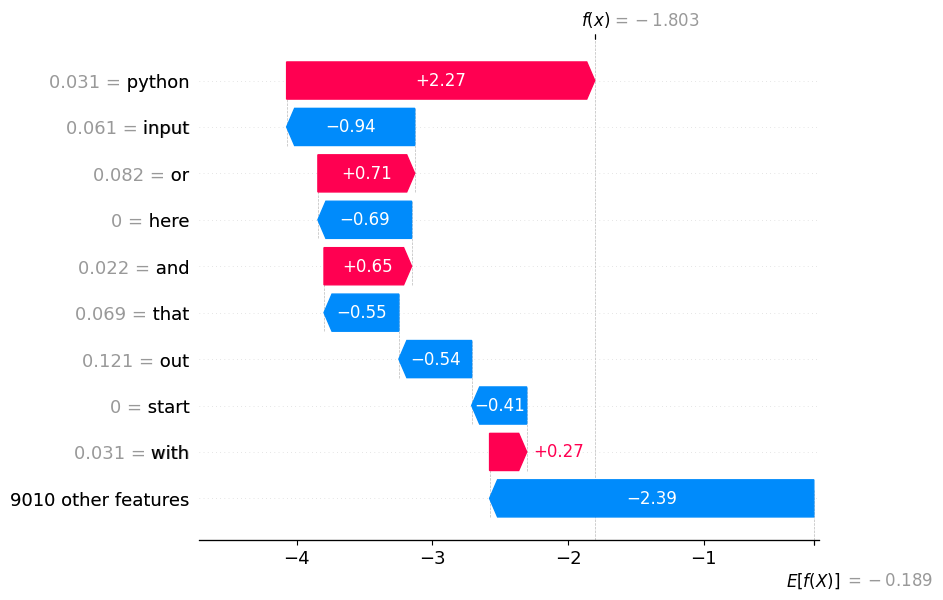


Original content of incorrectly classified sample 2640 (index 7346 in the original dataset):
Obtain all necessary supplies, such as a bucket, soap, sponge, and hose. Rinse the car with the hose to remove any dirt or debris. Fill the bucket with soapy water and use the sponge to wash the car, working from top to bottom. Rinse the soap off the car with the hose. Dry the car with a clean towel or cloth.


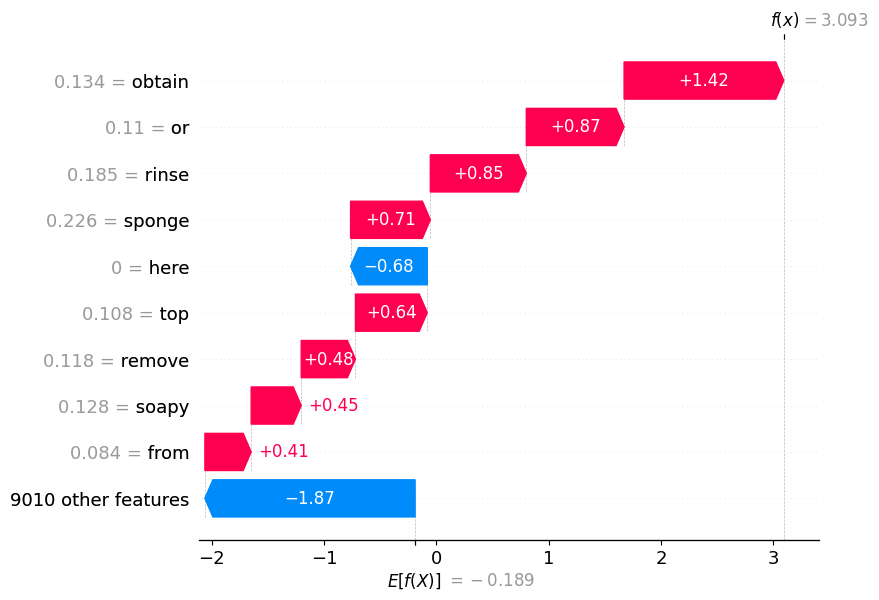

In [72]:
import shap
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 读取数据
file_path = 'all_answer.xlsx'
data = pd.read_excel(file_path)

# 确保没有缺失值
data = data.dropna(subset=[data.columns[0], data.columns[1]])

# 准备特征和目标变量
X_text = data.iloc[:, 0]  # 第一列为文本数据
y = data.iloc[:, 1]  # 第二列为标签

# 保留原始文本
original_texts = X_text.tolist()

# 文本向量化
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_text)

# 分割训练集和测试集，同时保留原始文本和索引
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, list(range(len(original_texts))), test_size=0.2, random_state=42)

# 初始化并训练 XGBoost 模型
xgb_model = single_models['XGBoost']
# 如果模型已经训练好，可以跳过训练步骤
# xgb_model.fit(X_train, y_train)

# 使用 XGBoost 模型进行预测
y_pred = xgb_model.predict(X_test)

# 找出错误分类的样本索引
incorrect_indices = [i for i in range(len(y_test)) if y_test.iloc[i] != y_pred[i]]

# 使用 XGBoost 模型的解释器
explainer = shap.TreeExplainer(xgb_model)

# 计算 SHAP 值
shap_values = explainer.shap_values(X_test)

# 获取特征名称
feature_names = vectorizer.get_feature_names_out()

# 创建 SHAP Explanation 对象
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test.toarray(),
    feature_names=feature_names
)
print(len(incorrect_indices))
# 输出错误分类样本的信息并绘制 SHAP 瀑布图
for sample_index in incorrect_indices:
    original_index = test_indices[sample_index]
    print(f"\nOriginal content of incorrectly classified sample {sample_index} (index {original_index} in the original dataset):")
    print(original_texts[original_index])
    
    # 提取并输出特征名称及其对应的 SHAP 值
    # print("\nFeatures and their corresponding SHAP values:")
    # shap_values_sample = shap_explanation.values[sample_index]
    # for feature_name, shap_value in zip(feature_names, shap_values_sample):
    #     if shap_value != 0:
    #         print(f"{feature_name}: {shap_value}")

    # 绘制 SHAP 值的瀑布图
    shap.plots.waterfall(shap_explanation[sample_index])


# 那些高风险的学生


Original content of incorrectly classified sample 6 (index 7300 in the original dataset):
Sensors will detect if there is a car in the washing area, if yes continue, if no then don't start and wait for a car to enter if yes, begin moving cleaning equipment towards car currently in the washing area and stop the car from moving. Create function CleanCar Spray car with cleaner Use scrubs and brushes on car after 10 seconds Spray car with water once finished scrubbing Repeat CleanCar Pull equipment away from the car Allow car to exit.


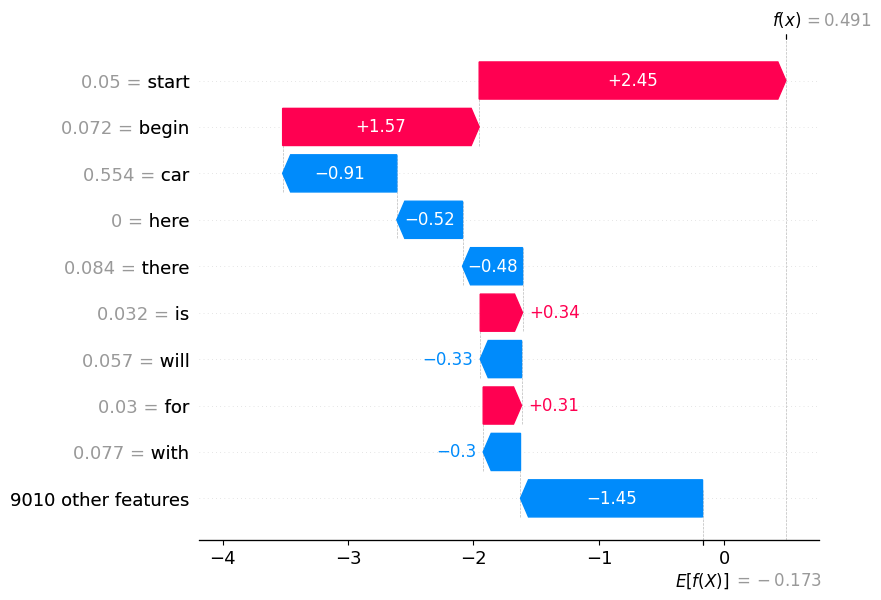

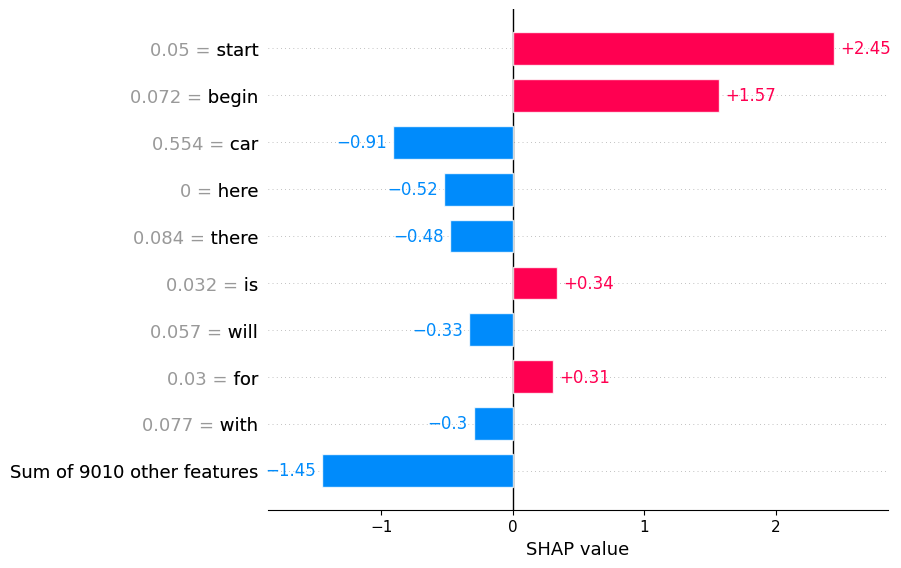


Original content of incorrectly classified sample 288 (index 7924 in the original dataset):
Start     Buy cereal and milk from the store     Get bowl     Pour cereal into a bowl     Pour milk into the bowl on top of the cereal     Get spoon     Eat cereal End


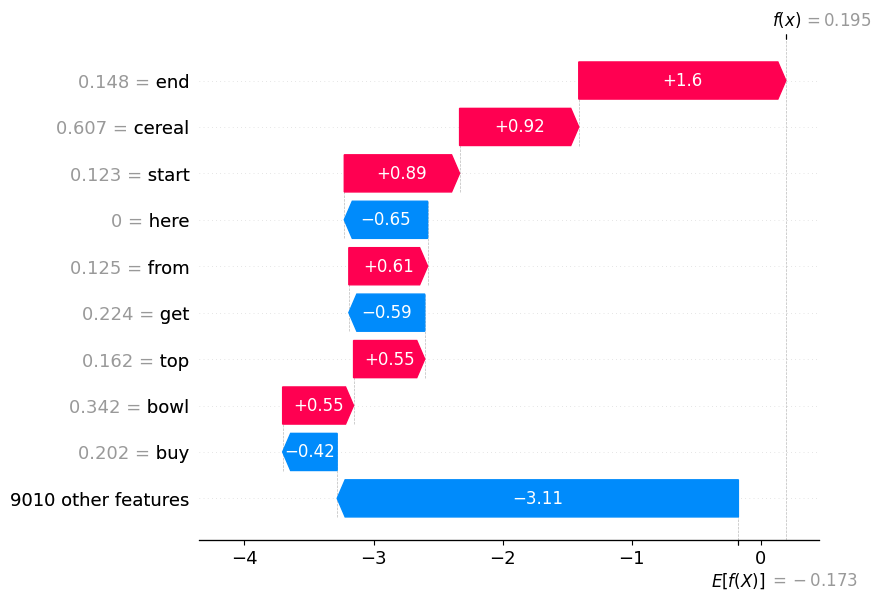

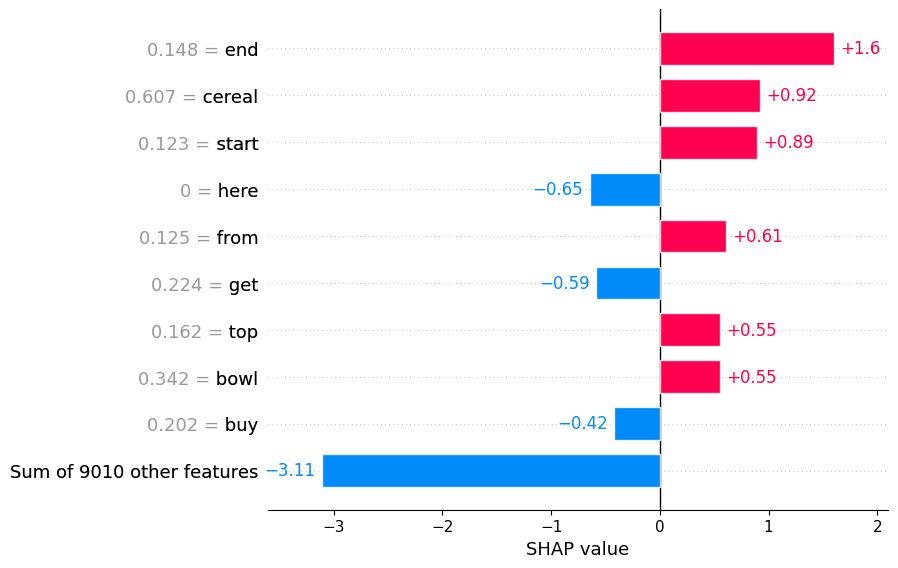


Original content of incorrectly classified sample 607 (index 7969 in the original dataset):
if gameday is today: aquire and wear team shirt wear as much team colors  as possible if you have face paint: put on face paint go to grocery store acquire chips, guacamole, bean dip, etc while paying for items, talk loudly and excited about how your team is going to win it today if you see someone wearing the same team colors as you: cheer loudly until they see you and acknowledge your shared excitement go home invite friends over to watch "the big game" set out snacks turn on TV to the "big game"'s channel at least 2 hours before the game is scheduled to start. #enjoy


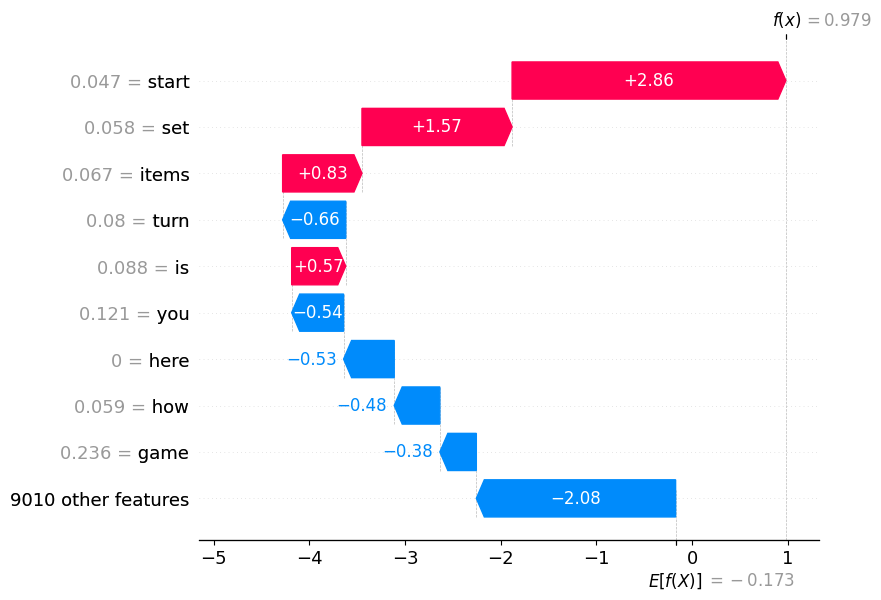

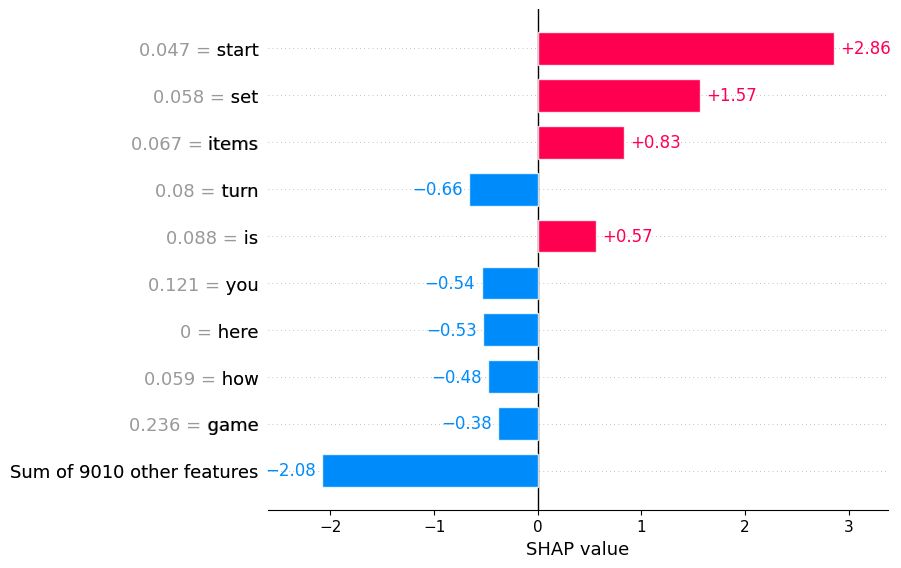


Original content of incorrectly classified sample 655 (index 10892 in the original dataset):
Enter comment explaining program shows how to show off your support for your favorite team Set Parameters for teams that include if-elif options for type of sport, team name and team home Direct user to choose his or her favorite team Direct user to choose his or her favorite place to support their team - such as home, local bar or stadium Print summary of inputs within one code line referring to user as his or her chosen team  print preset set of options based on the team they chose to allow them to compare their methods to the most commonly accessible ways to show spirit End program code


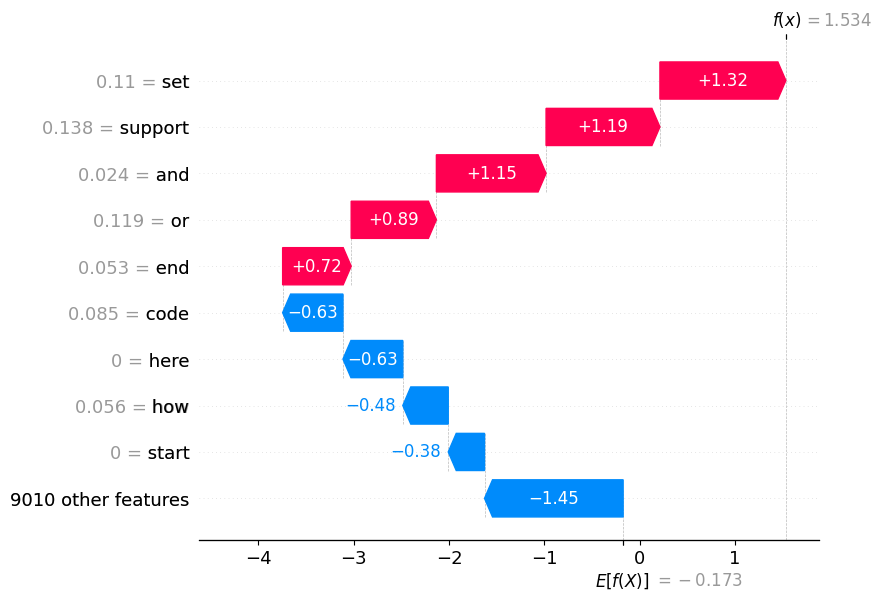

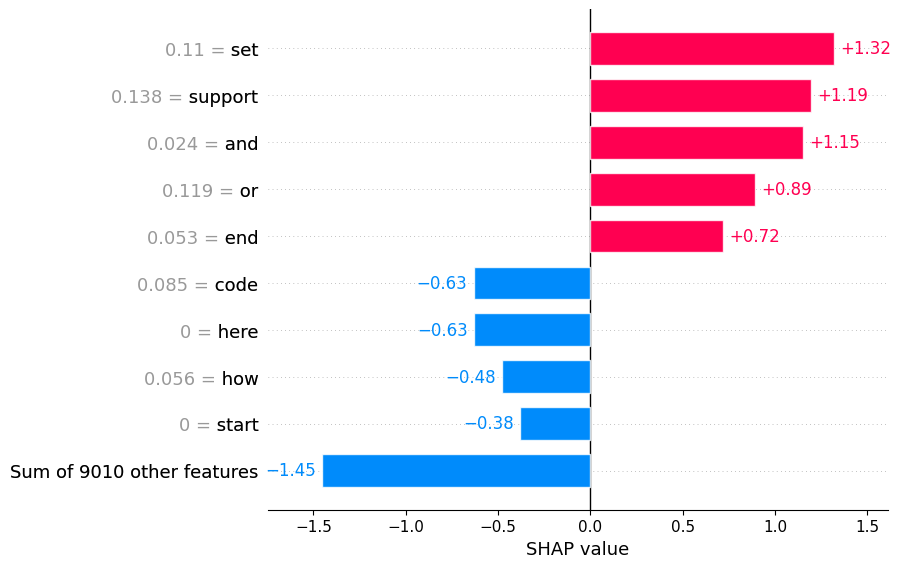


Original content of incorrectly classified sample 768 (index 11897 in the original dataset):
Input:  Create a class for thank-you notes. Output:  A class for thank-you notes will be created. Input:  Using the class, create an object and assign it to a variable. Output:  An object will be created using the class and it will then be assigned to a variable. Input:  Ask the user the name of the person he or she is sending the thank-you note to. Output:  An input function asking the user to type the name of the recipient will be assigned to a variable. Input:  Change the name of the thank-you note object to the name that the user gave. Output:  The thank-you note name will be changed to the name that the user gave. Input:  Display the thank-you note Output:  One print statement will display the thank-you note object.


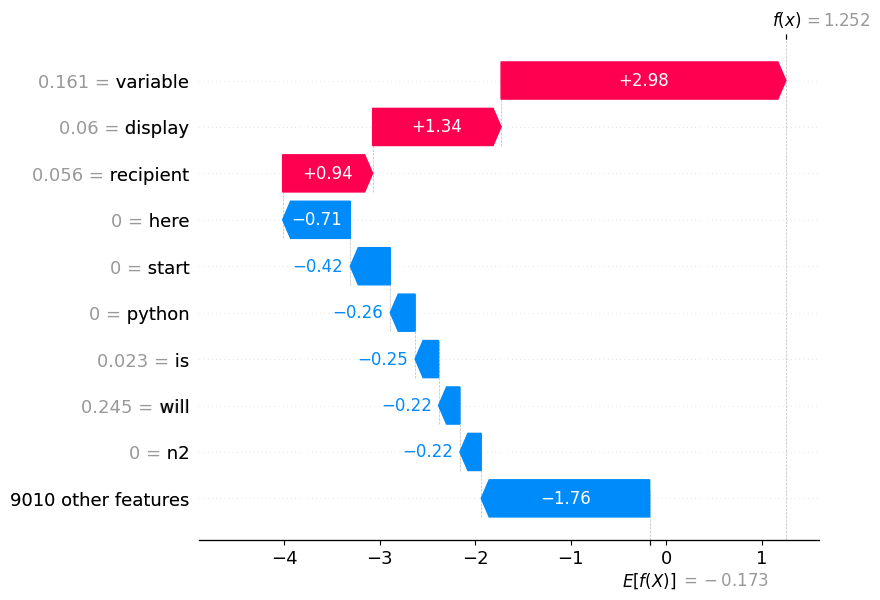

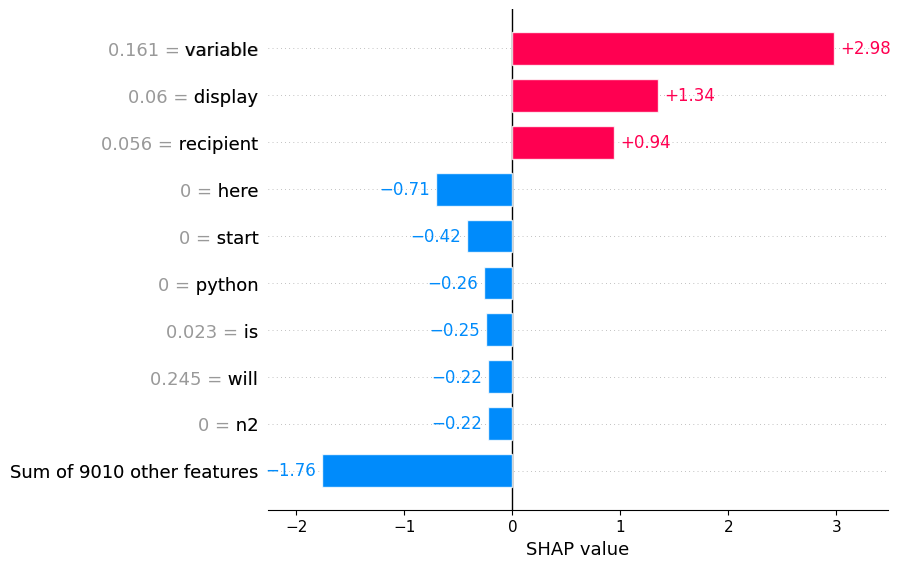


Original content of incorrectly classified sample 1207 (index 10471 in the original dataset):
1. Startup 2. Prepare for cleaning the vehicle, you can do this by getting a bucket and filling it with water and soap, make sure to also have a sponge within the mix. 3. Start by using the water hose to rinse down your vehicle starting from the roof. You'll start by taking your sponge that is soaked in soap and you'll begin rubbing the top of the car, rubbing hard to try to remove any dirt or grime on the room, then finish with a clean rinse from the hose. 4. Start focusing the water hoses stream on the car's exterior body. Use the hose to spray down any dirt or wet marks on the body of the car. 5. Begin washing the tires. Take your sponge and run hard on the tires removing any grime or dirt on the rim or wheel itself.  6. Drying your vehicle. You do this by taking a clean rag and rubbing and wiping away all wet spots on the car making it dry.


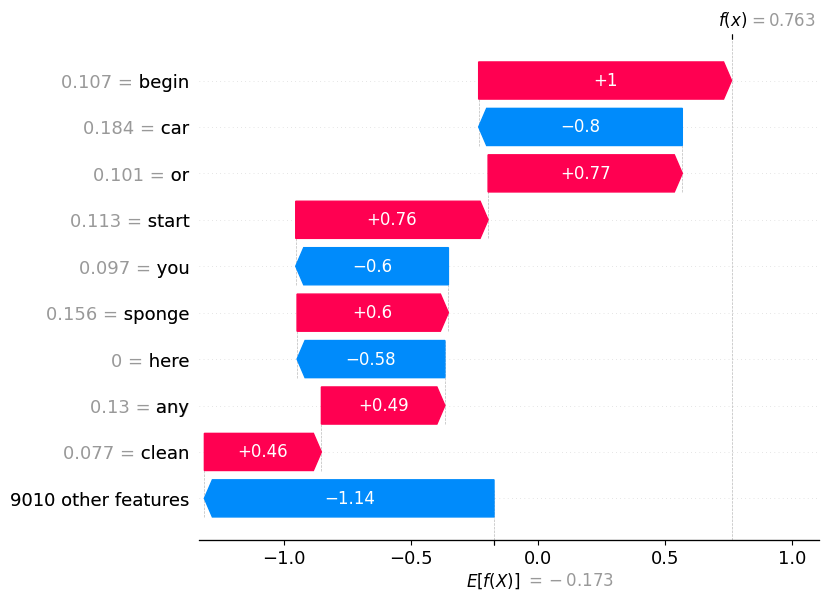

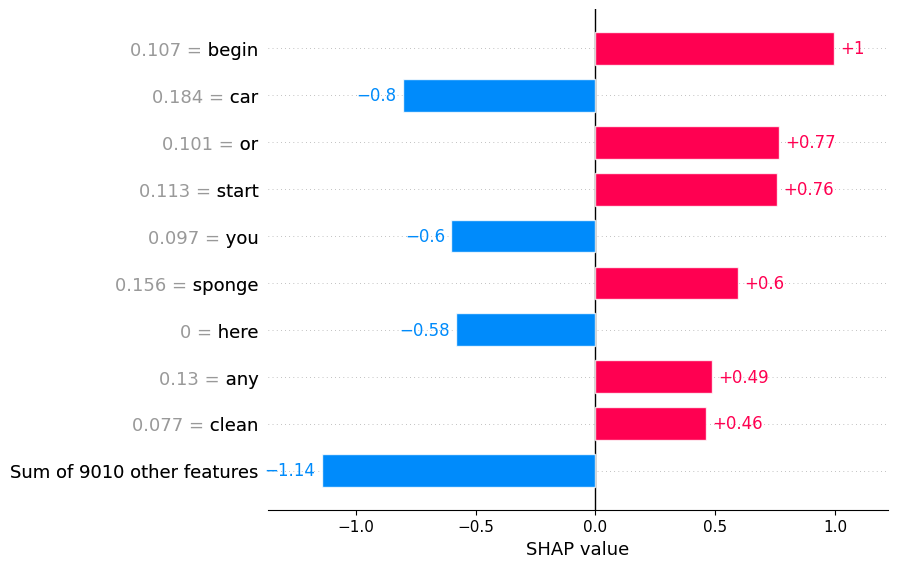


Original content of incorrectly classified sample 1233 (index 13985 in the original dataset):
1:check if food bowl is full 2:if food bowl is empty, have it continue if full, stop here 3:Grab dog food 4:fill bowl with dog food 5:call dog over for food


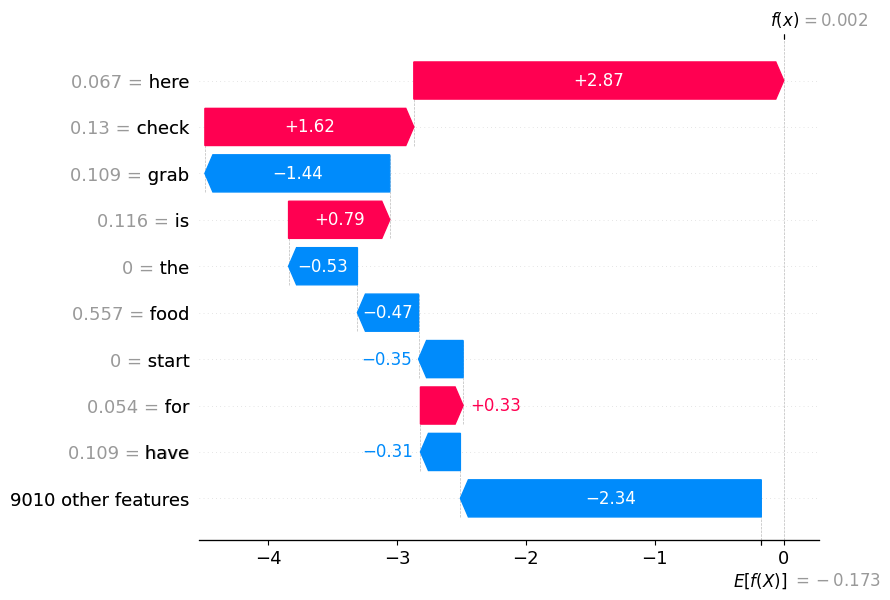

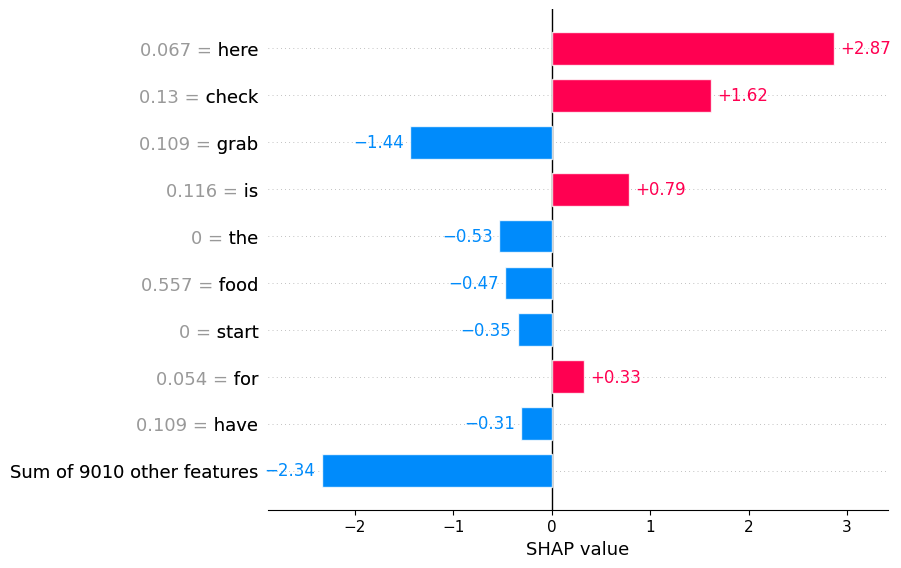


Original content of incorrectly classified sample 1414 (index 8629 in the original dataset):
1. Get your toothbrush, toothpaste, and a cup of water  2. Open the toothpaste and apply a small amount to the toothbrush  3. Wet the toothbrush with water  4. Brush teeth in circular motion for 2 minutes, making sure to reach all areas  5. Rinse mouth and toothbrush with water


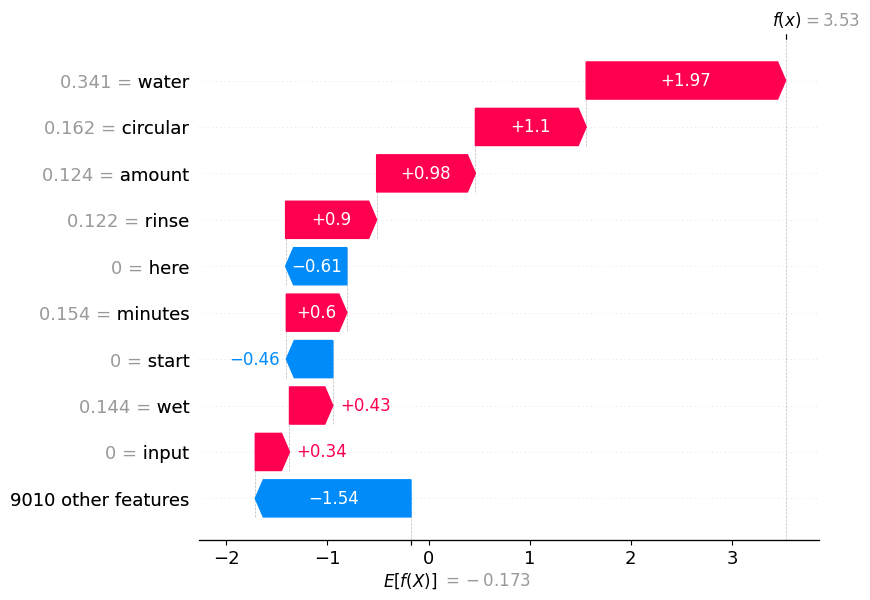

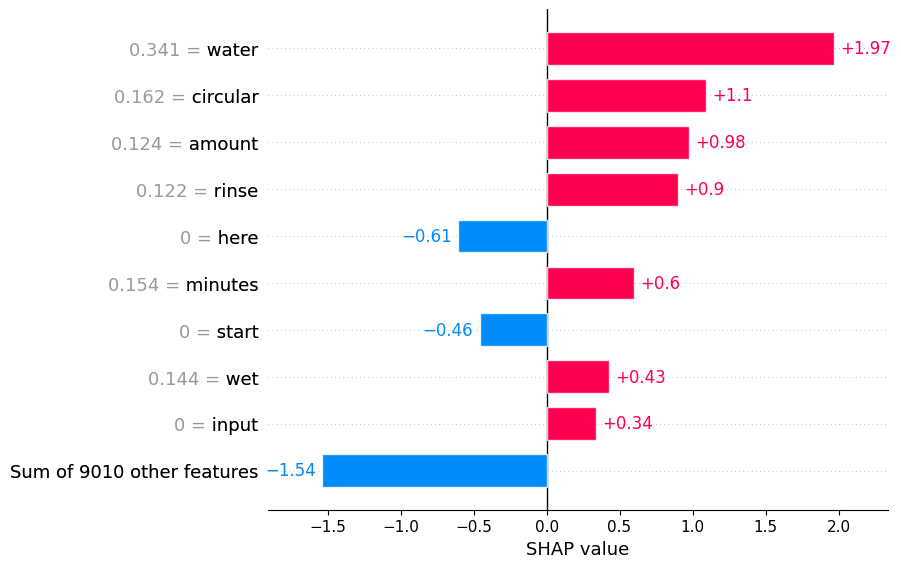


Original content of incorrectly classified sample 1691 (index 8410 in the original dataset):
Initialize: walk into your bathroom and inspect your teeth in the mirror. Inputs: after inspecting your teeth in the mirror, get a toothpaste bottle and an actual toothpaste from a cabinet in the bathroom.  Action: Remove the cover of the toothpaste and squeeze some toothpaste out of it to be 'pasted' upon the tooth portion of the toothbrush.  Process: gently place the toothbrush along the margins and surface of your teeth, with the toothpaste coming into contact with it, and move the toothbrush in a manner such that it is moving from one side of your teeth to the other, covering each tooth completely.  Result: Properly spit out the toothpaste from your mouth after a good deal of toothbrushing, and then gargle your mouth to spit out any remaining contents inside of the mouth, and finally look at your teeth in the mirror to see how clean it is!


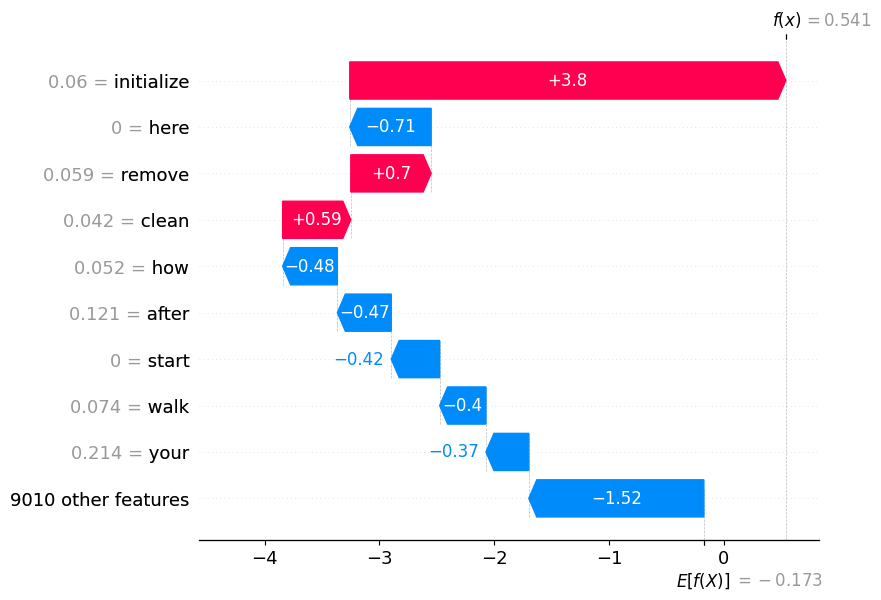

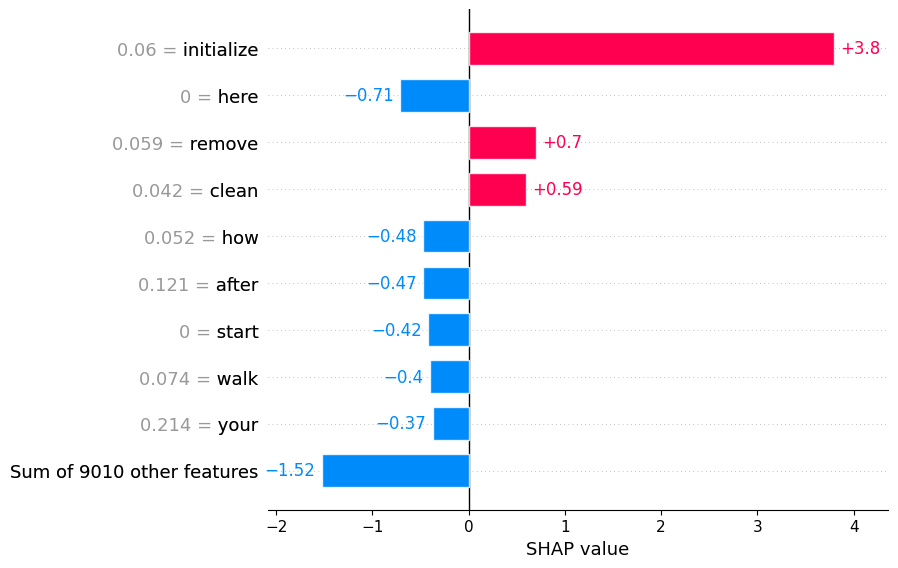


Original content of incorrectly classified sample 1818 (index 10624 in the original dataset):
Define MAIN function:         Set a variable drawersClean to false         Set a variable sheetsClean to false         Set drawersDone to 0         Set sheetsDone to 0         Get input for the total # of sheets on the bed, set it to sheetNum         Get input for the total # of drawers in the room's cabinets, set it to drawerNum         Vacuum the floor         Create a while loop to repeat until drawersClean is true                  Clean out a drawer in one of the cabinets                  Add 1 to drawersDone                  If drawersDone equals to drawerNum then                              Set drawersClean to true          Create a while loop to repeat until sheetsClean is true                  Put a sheet on the bed and tuck it in'                  Add 1 to sheetsDone                  If drawersDone equals to sheetNum then                              Set sheetsClean to true Execute 

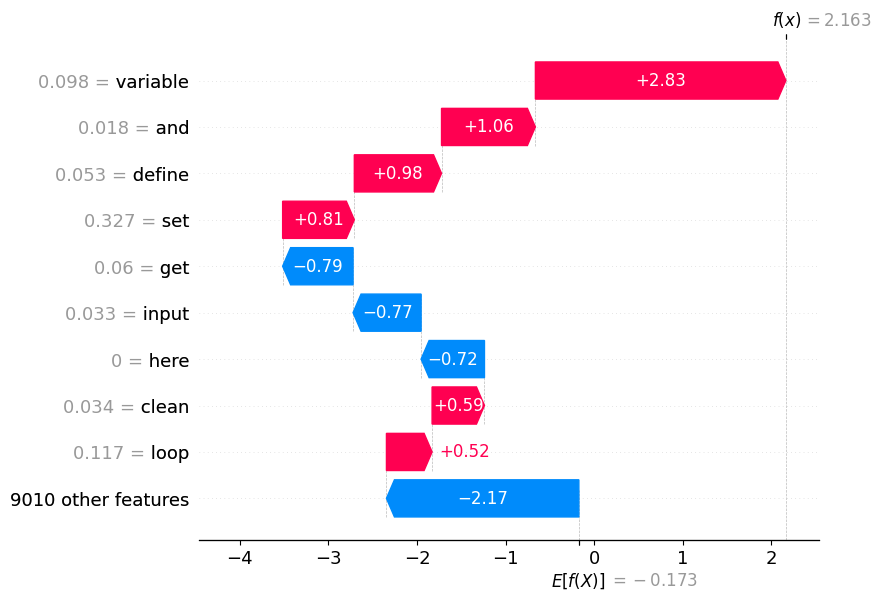

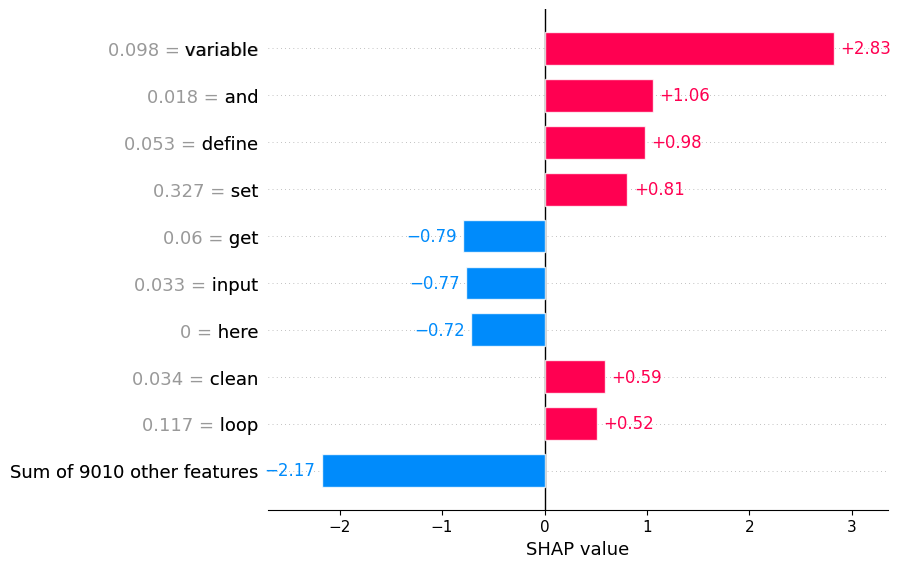


Original content of incorrectly classified sample 2168 (index 12271 in the original dataset):
Pseudocode to Clean My Room: Part One, Organization: 1. Assess the room  2. Begin organizing the messiness of the room Part Two Begin Cleaning: 3. Pick up objects and place them in the correct places 4. Do any laundry or extra cleaning necessary  5. Vacuum the room


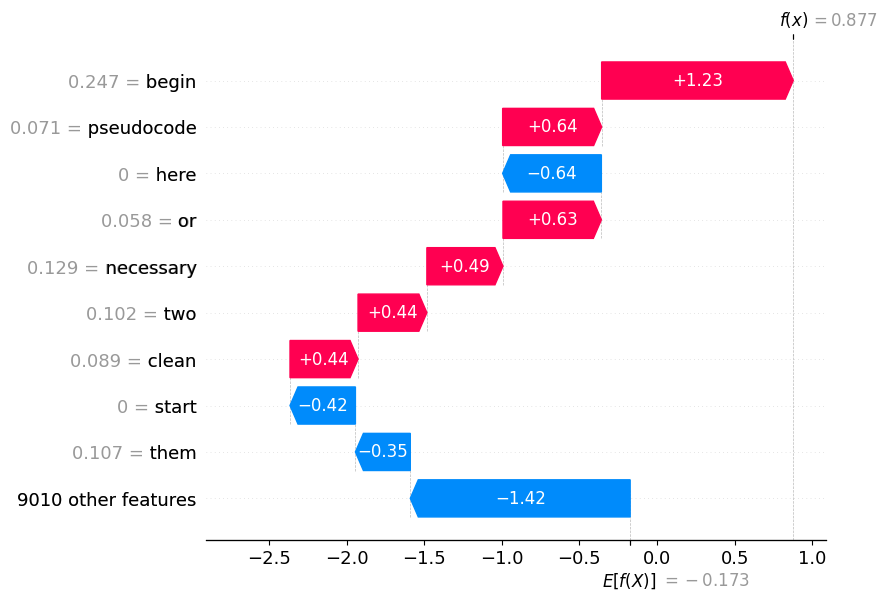

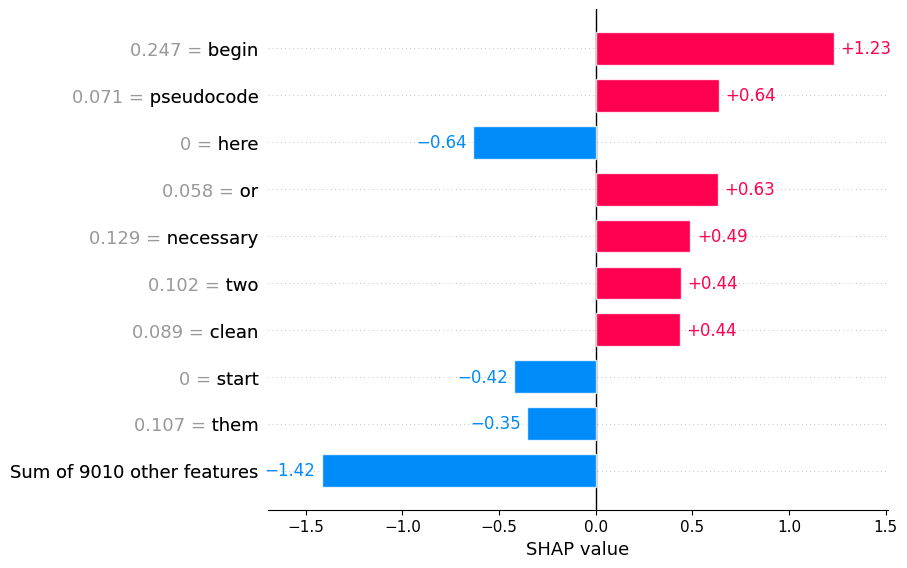


Original content of incorrectly classified sample 2186 (index 6572 in the original dataset):
Prepare a bowl and spoon  Assemble cereal, milk, and optional toppings from the pantry/fridge Pour the desired amount of cereal  Optional: Add toppings  Pour the desired amount of milk over cereal and toppings  Place spoon in bowl


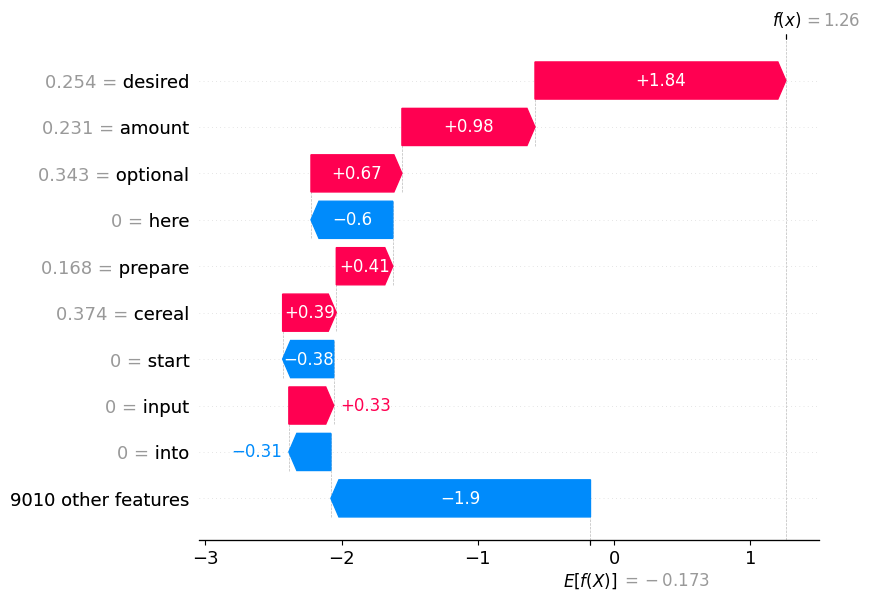

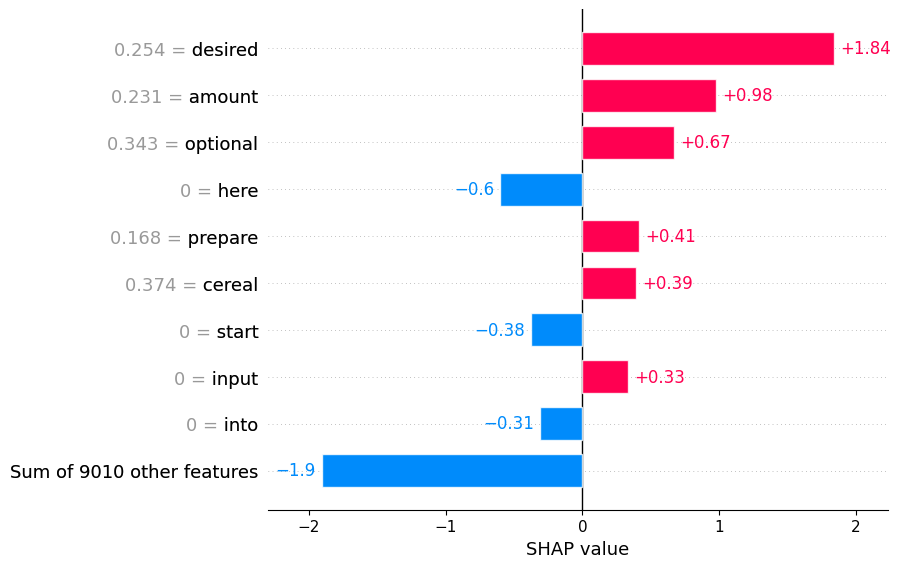


Original content of incorrectly classified sample 2345 (index 11427 in the original dataset):
Start print: Step one rinse off all sides of the car with hose print: Step two apply soapy water to all sides of the car. print: step three rinse the car with water print: step four repeat steps one-three until the car is sparkling clean print: step five dry off the car with a towel and a quick ride around the block End


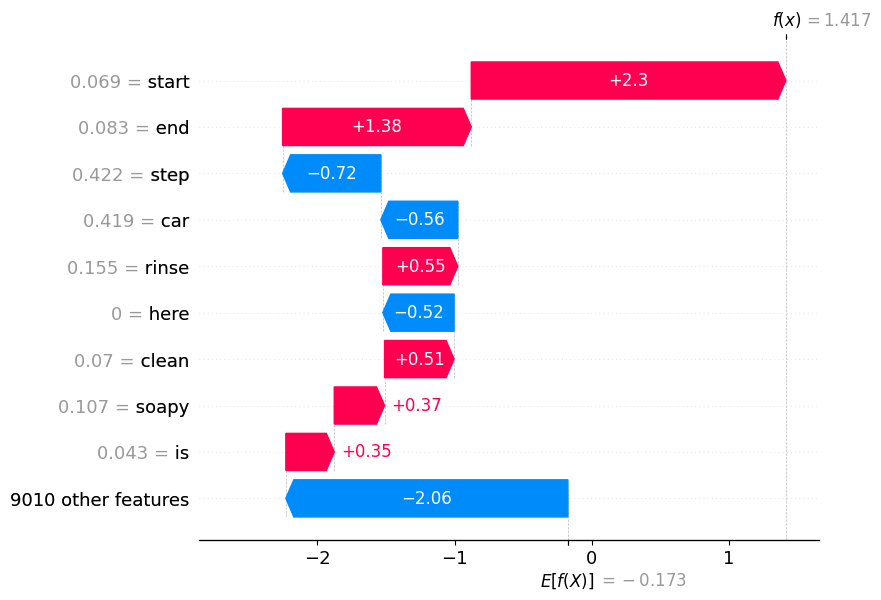

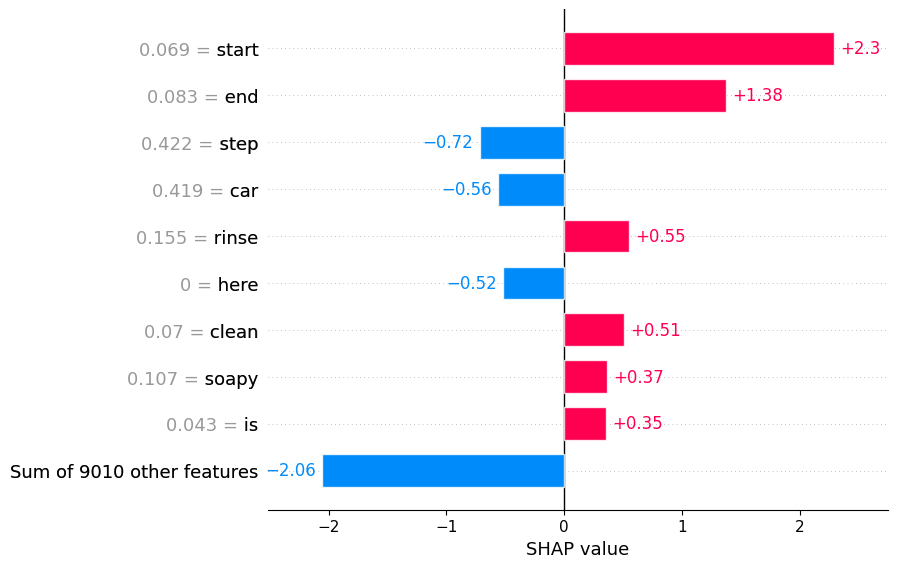


Original content of incorrectly classified sample 2359 (index 8354 in the original dataset):
Get the necessary ingredients from the fridge or pantry: two slices of bread, a jar of peanut butter, and a jar of jelly. Place the two pieces of bread on a plate next to each other. Using a knife, spread the peanut butter on one slice of bread. Using a knife again, spread the jelly on the other slice of bread. Place one slice of bread on top of the other so that both the peanut butter and jelly are in between the bread. Enjoy the sandwich.


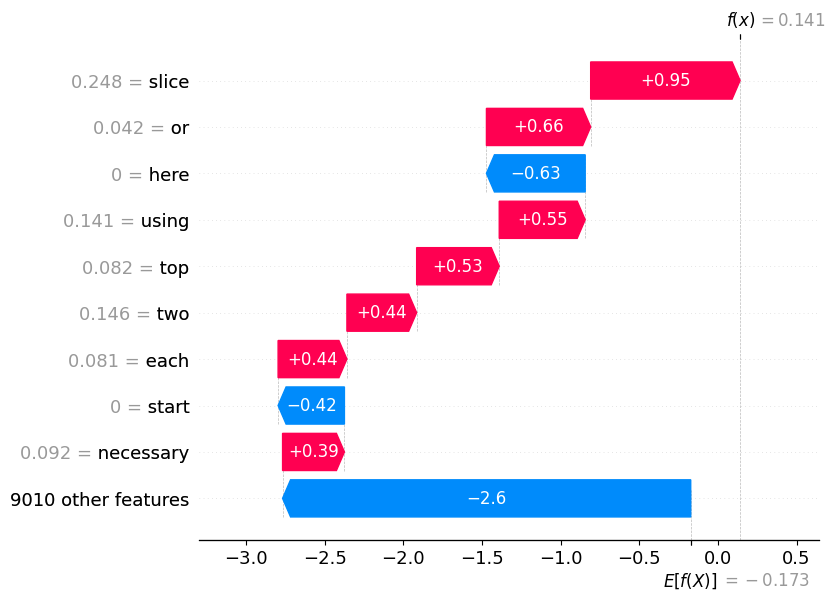

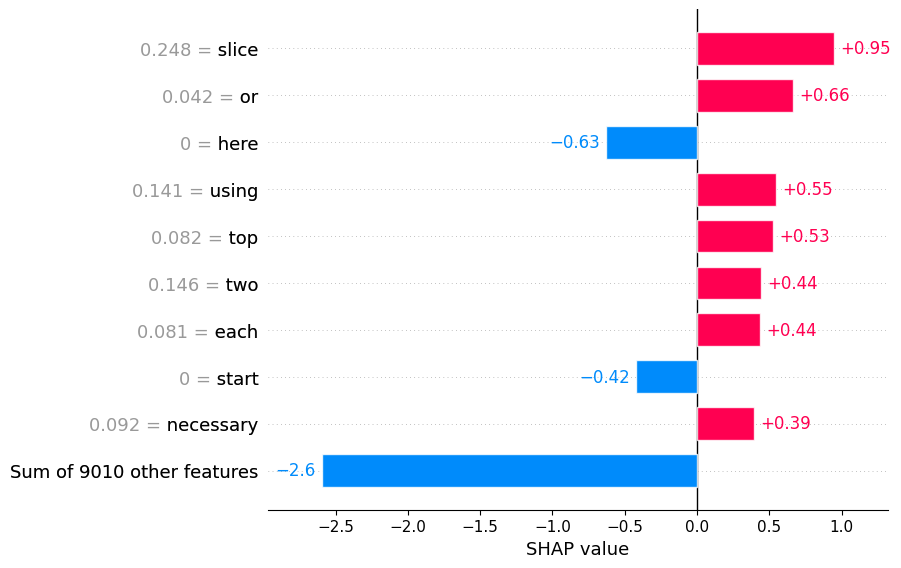


Original content of incorrectly classified sample 2612 (index 7484 in the original dataset):
Start the cleaning process Pick up any trash and throw it in the garbage Gather any dirty clothes and place them in the laundry basket Throw the bedsheets into the washer Organize items on the vanity and put them back in their designated places Vacuum or sweep the floor to remove any dust or dirt


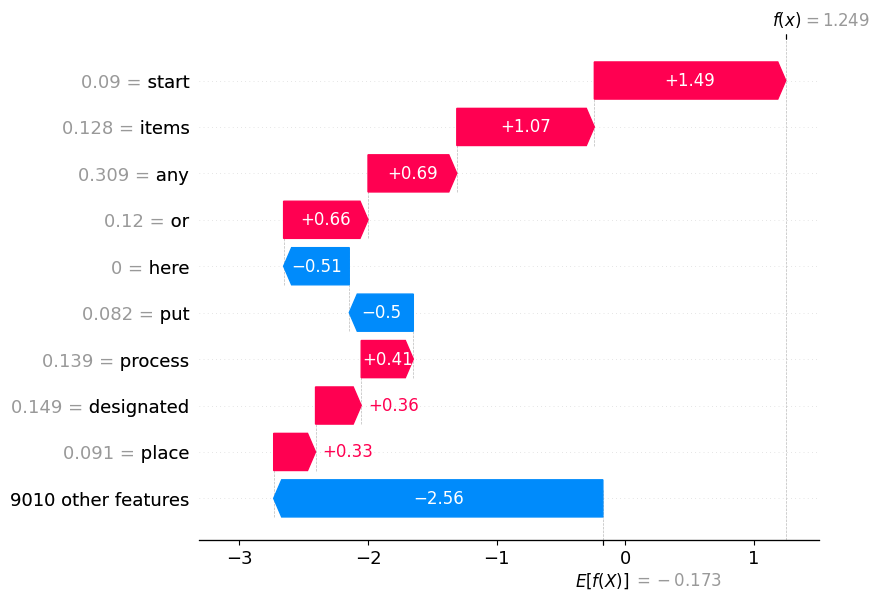

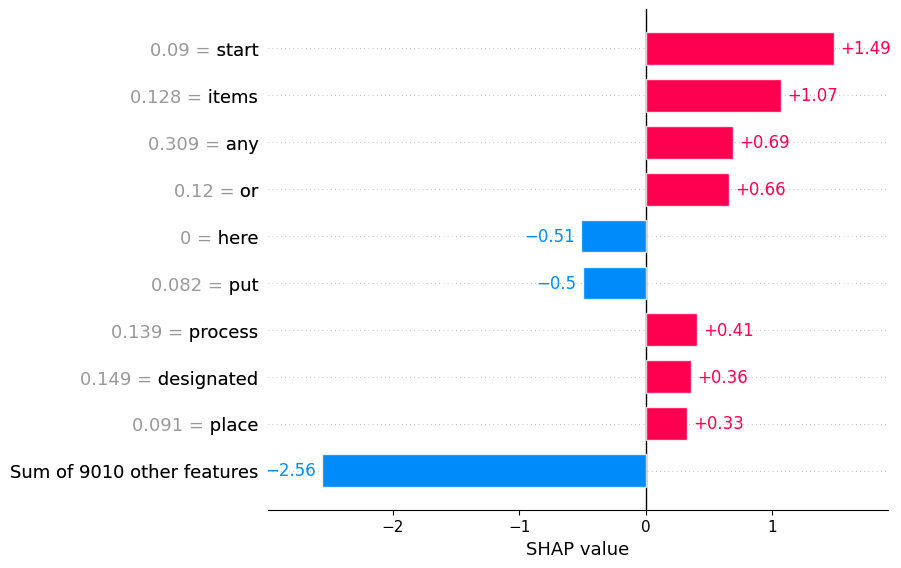


Original content of incorrectly classified sample 2640 (index 7346 in the original dataset):
Obtain all necessary supplies, such as a bucket, soap, sponge, and hose. Rinse the car with the hose to remove any dirt or debris. Fill the bucket with soapy water and use the sponge to wash the car, working from top to bottom. Rinse the soap off the car with the hose. Dry the car with a clean towel or cloth.


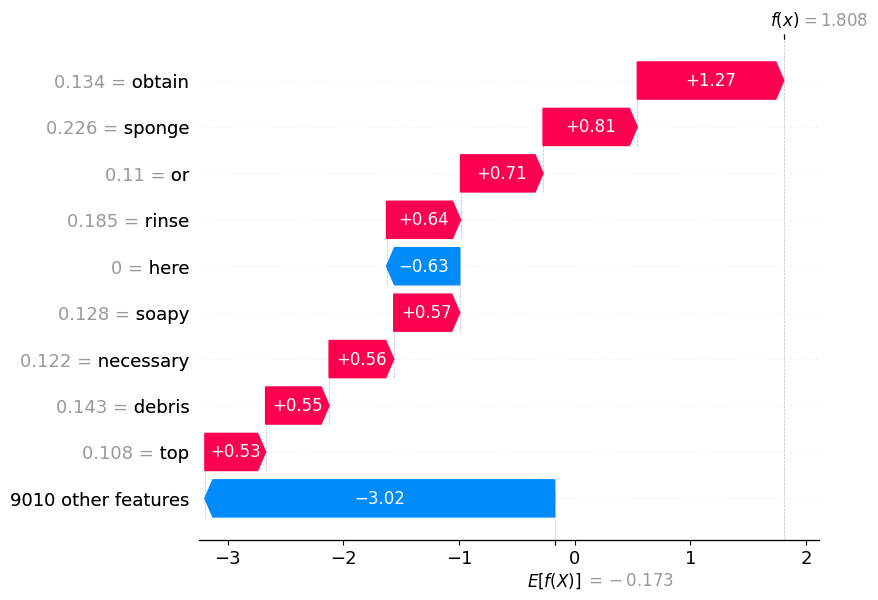

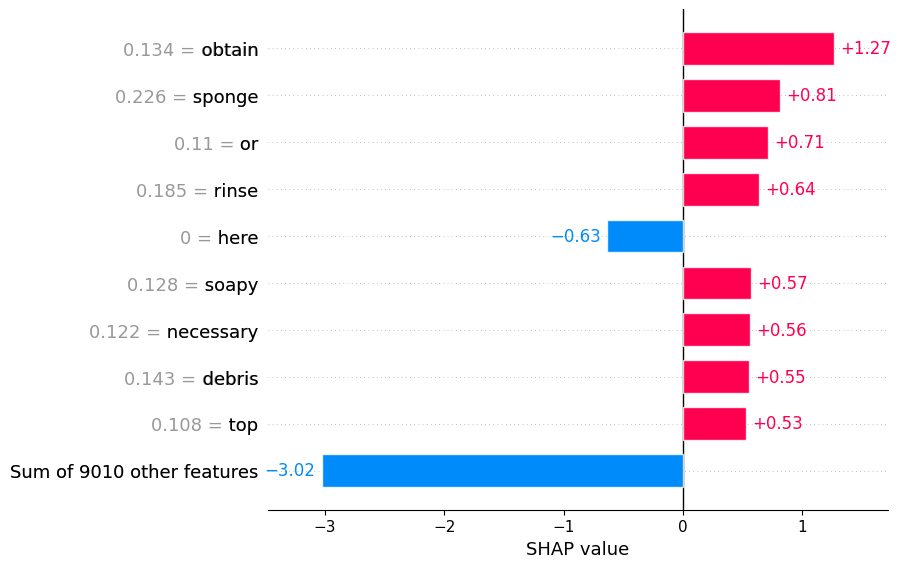

In [105]:
import shap
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# 读取数据
file_path = 'all_answer.xlsx'
data = pd.read_excel(file_path)

# 确保没有缺失值
data = data.dropna(subset=[data.columns[0], data.columns[1]])

# 准备特征和目标变量
X_text = data.iloc[:, 0]  # 第一列为文本数据
y = data.iloc[:, 1]  # 第二列为标签

# 保留原始文本
original_texts = X_text.tolist()

# 文本向量化
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_text)

# 分割训练集和测试集，同时保留原始文本和索引
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, list(range(len(original_texts))), test_size=0.2, random_state=42)

# 初始化并训练 XGBoost 模型
xgb_model = single_models['XGBoost']
# 如果模型已经训练好，可以跳过训练步骤
# xgb_model.fit(X_train, y_train)

# 使用 XGBoost 模型进行预测
y_pred = xgb_model.predict(X_test)

# 找出标签为0但被错误分类为1的样本索引
incorrect_indices = [i for i in range(len(y_test)) if y_test.iloc[i] == 0 and y_pred[i] == 1]

# 使用 XGBoost 模型的解释器
explainer = shap.TreeExplainer(xgb_model)

# 计算 SHAP 值
shap_values = explainer.shap_values(X_test)

# 获取特征名称
feature_names = vectorizer.get_feature_names_out()

# 创建 SHAP Explanation 对象
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test.toarray(),
    feature_names=feature_names
)

# 输出错误分类样本的信息并绘制 SHAP 瀑布图
for sample_index in incorrect_indices:
    original_index = test_indices[sample_index]
    print(f"\nOriginal content of incorrectly classified sample {sample_index} (index {original_index} in the original dataset):")
    print(original_texts[original_index])
    
    # 提取并输出特征名称及其对应的 SHAP 值
    # print("\nFeatures and their corresponding SHAP values:")
    # shap_values_sample = shap_explanation.values[sample_index]
    # for feature_name, shap_value in zip(feature_names, shap_values_sample):
    #     if shap_value != 0:
    #         print(f"{feature_name}: {shap_value}")

    # 绘制 SHAP 值的瀑布图
    shap.plots.waterfall(shap_explanation[sample_index])
    # visualize the first prediction's explanation with a force plot
    # shap.plots.force(shap_explanation[sample_index])
    shap.plots.bar(shap_explanation[sample_index])



## 分析不同题型的关键词
## 两类，第一种是前面9道题
## 第二类是最后的程序题

In [77]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

# Make sure you have the punkt package
nltk.download('punkt')

# Load the Excel file
file_path = 'all_answer.xlsx'
data = pd.read_excel(file_path)

# 确保没有缺失值
data = data.dropna(subset=[data.columns[0]])

# Extract the first column
first_column = data.iloc[:, 0]

# Split the data into the required lists
gpt3_5 = first_column[:2100].tolist()
gpt_4 = first_column[2100:4200].tolist()
gpt_d = first_column[4200:6300].tolist()
stu = first_column[6300:].tolist()

# Function to calculate average sentence count, average word count, and FKL grade level
def calculate_flesch_kincaid_grade(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    syllables = sum([len([char for char in word if char in 'aeiouAEIOU']) for word in words])
    
    num_sentences = len(sentences)
    num_words = len(words)
    
    if num_sentences == 0 or num_words == 0:
        return 0
    
    ASL = num_words / num_sentences  # Average Sentence Length
    ASW = syllables / num_words  # Average Syllables per Word
    
    return 0.39 * ASL + 11.8 * ASW - 15.59

def calculate_metrics(text_list):
    total_sentences = 0
    total_words = 0
    total_fkl = 0
    count = len(text_list)
    
    for text in text_list:
        sentences = sent_tokenize(text)
        words = word_tokenize(text)
        total_sentences += len(sentences)
        total_words += len(words)
        total_fkl += calculate_flesch_kincaid_grade(text)
    
    avg_sentences = total_sentences / count
    avg_words = total_words / count
    avg_fkl = total_fkl / count
    
    return avg_sentences, avg_words, avg_fkl

# Calculate metrics for each list
metrics_gpt3_5 = calculate_metrics(gpt3_5)
metrics_gpt_4 = calculate_metrics(gpt_4)
metrics_gpt_d = calculate_metrics(gpt_d)
metrics_stu = calculate_metrics(stu)

# Print the results
print("Metrics for gpt3_5:")
print("Average Sentences:", metrics_gpt3_5[0])
print("Average Words:", metrics_gpt3_5[1])
print("Average FKL Grade Level:", metrics_gpt3_5[2])

print("\nMetrics for gpt_4:")
print("Average Sentences:", metrics_gpt_4[0])
print("Average Words:", metrics_gpt_4[1])
print("Average FKL Grade Level:", metrics_gpt_4[2])

print("\nMetrics for gpt_d:")
print("Average Sentences:", metrics_gpt_d[0])
print("Average Words:", metrics_gpt_d[1])
print("Average FKL Grade Level:", metrics_gpt_d[2])

print("\nMetrics for stu:")
print("Average Sentences:", metrics_stu[0])
print("Average Words:", metrics_stu[1])
print("Average FKL Grade Level:", metrics_stu[2])


[nltk_data] Downloading package punkt to /Users/liuzifeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Metrics for gpt3_5:
Average Sentences: 6.8619047619047615
Average Words: 128.27
Average FKL Grade Level: 7.688738292991018

Metrics for gpt_4:
Average Sentences: 7.516666666666667
Average Words: 131.84190476190477
Average FKL Grade Level: 8.887403265135356

Metrics for gpt_d:
Average Sentences: 6.016190476190476
Average Words: 130.52952380952382
Average FKL Grade Level: 7.848918483534428

Metrics for stu:
Average Sentences: 2.6220230473751602
Average Words: 45.54750320102433
Average FKL Grade Level: 10.60703676712237


In [78]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import textstat

# Ensure you have the punkt package
nltk.download('punkt')

# Load the Excel file
file_path = 'all_answer.xlsx'
data = pd.read_excel(file_path)

# Extract the first column and convert to string
first_column = data.iloc[:, 0].astype(str)

# Split the data into the required lists
gpt3_5 = first_column[:2100].tolist()
gpt_4 = first_column[2100:4200].tolist()
gpt_d = first_column[4200:6300].tolist()
stu = first_column[6300:].tolist()

# Function to calculate average sentence count, average word count, and FKL grade level
def calculate_metrics(text_list):
    total_sentences = 0
    total_words = 0
    total_fkl = 0
    count = len(text_list)
    
    for text in text_list:
        sentences = sent_tokenize(text)
        words = word_tokenize(text)
        total_sentences += len(sentences)
        total_words += len(words)
        total_fkl += textstat.flesch_kincaid_grade(text)
    
    avg_sentences = total_sentences / count
    avg_words = total_words / count
    avg_fkl = total_fkl / count
    
    return avg_sentences, avg_words, avg_fkl

# Calculate metrics for each list
metrics_gpt3_5 = calculate_metrics(gpt3_5)
metrics_gpt_4 = calculate_metrics(gpt_4)
metrics_gpt_d = calculate_metrics(gpt_d)
metrics_stu = calculate_metrics(stu)

# Print the results
print("Metrics for gpt3_5:")
print("Average Sentences:", metrics_gpt3_5[0])
print("Average Words:", metrics_gpt3_5[1])
print("Average FKL Grade Level:", metrics_gpt3_5[2])

print("\nMetrics for gpt_4:")
print("Average Sentences:", metrics_gpt_4[0])
print("Average Words:", metrics_gpt_4[1])
print("Average FKL Grade Level:", metrics_gpt_4[2])

print("\nMetrics for gpt_d:")
print("Average Sentences:", metrics_gpt_d[0])
print("Average Words:", metrics_gpt_d[1])
print("Average FKL Grade Level:", metrics_gpt_d[2])

print("\nMetrics for stu:")
print("Average Sentences:", metrics_stu[0])
print("Average Words:", metrics_stu[1])
print("Average FKL Grade Level:", metrics_stu[2])


[nltk_data] Downloading package punkt to /Users/liuzifeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Metrics for gpt3_5:
Average Sentences: 6.8619047619047615
Average Words: 128.27
Average FKL Grade Level: 7.574047619047638

Metrics for gpt_4:
Average Sentences: 7.516666666666667
Average Words: 131.84190476190477
Average FKL Grade Level: 7.706761904761899

Metrics for gpt_d:
Average Sentences: 6.016190476190476
Average Words: 130.52952380952382
Average FKL Grade Level: 8.50285714285715

Metrics for stu:
Average Sentences: 2.6164348602781677
Average Words: 45.394028327166005
Average FKL Grade Level: 8.848666581600089


In [79]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import textstat

# Ensure you have the punkt package
nltk.download('punkt')

# Load the Excel file
file_path = 'all_answer.xlsx'
data = pd.read_excel(file_path)

# Extract the first column and convert to string
first_column = data.iloc[:, 0].astype(str)

# Split the data into the required lists
gpt3_5 = first_column[:2100].tolist()
gpt_4 = first_column[2100:4200].tolist()
gpt_d = first_column[4200:6300].tolist()

# Function to calculate average sentence count, average word count, and FKL grade level
def calculate_metrics(text_list):
    total_sentences = 0
    total_words = 0
    total_fkl = 0
    count = len(text_list)
    
    for text in text_list:
        sentences = sent_tokenize(text)
        words = word_tokenize(text)
        total_sentences += len(sentences)
        total_words += len(words)
        total_fkl += textstat.flesch_kincaid_grade(text)
    
    avg_sentences = total_sentences / count
    avg_words = total_words / count
    avg_fkl = total_fkl / count
    
    return avg_sentences, avg_words, avg_fkl

# Function to calculate metrics for each question
def calculate_question_metrics(model_data):
    question_metrics = []
    for i in range(21):
        question_data = model_data[i*100:(i+1)*100]
        avg_sentences, avg_words, avg_fkl = calculate_metrics(question_data)
        question_metrics.append((avg_sentences, avg_words, avg_fkl))
    return question_metrics

# Calculate metrics for each question for each model
metrics_gpt3_5 = calculate_question_metrics(gpt3_5)
metrics_gpt_4 = calculate_question_metrics(gpt_4)
metrics_gpt_d = calculate_question_metrics(gpt_d)

# Convert the results to DataFrame for better readability
df_gpt3_5 = pd.DataFrame(metrics_gpt3_5, columns=['Average Sentences', 'Average Words', 'Average FKL Grade Level'])
df_gpt_4 = pd.DataFrame(metrics_gpt_4, columns=['Average Sentences', 'Average Words', 'Average FKL Grade Level'])
df_gpt_d = pd.DataFrame(metrics_gpt_d, columns=['Average Sentences', 'Average Words', 'Average FKL Grade Level'])

# Display the DataFrames
print("Metrics for gpt3_5:")
print(df_gpt3_5)

print("\nMetrics for gpt_4:")
print(df_gpt_4)

print("\nMetrics for gpt_d:")
print(df_gpt_d)


[nltk_data] Downloading package punkt to /Users/liuzifeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Metrics for gpt3_5:
    Average Sentences  Average Words  Average FKL Grade Level
0                9.74          78.57                    5.192
1                5.23         154.82                    7.985
2                9.15         107.98                    4.935
3                4.30         152.57                    9.480
4               10.69         118.94                    7.013
5                4.15         153.95                   11.215
6               10.56          94.50                    3.992
7                5.18         153.89                    7.676
8               10.83         101.56                    4.996
9                8.78          98.72                    5.074
10               7.78          64.31                    5.037
11               4.23         154.45                   10.791
12               5.21         152.92                    7.864
13              10.01         105.68                    7.803
14               9.34          73.17              

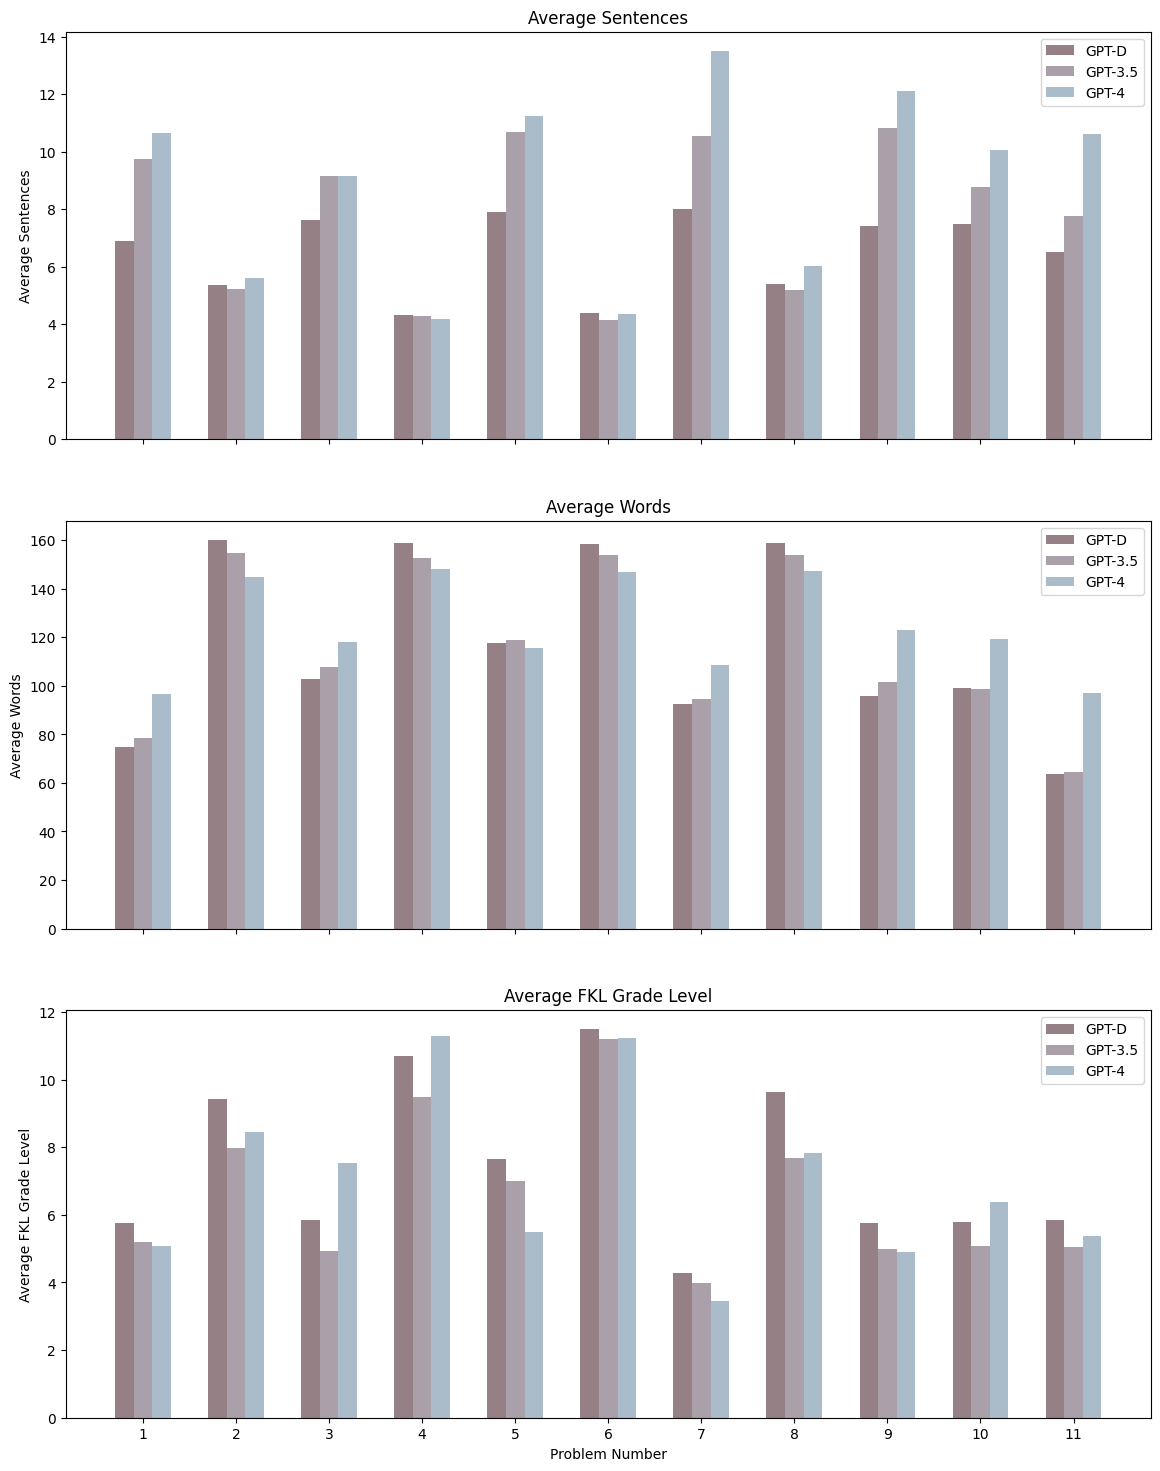

In [97]:
# Select the data for the first 11 questions (0-10)
df_gpt3_5_first_11 = df_gpt3_5.iloc[:11]
df_gpt_4_first_11 = df_gpt_4.iloc[:11]
df_gpt_d_first_11 = df_gpt_d.iloc[:11]

# Plotting the bar charts in one plot
fig, ax = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

x = range(1, 12)  # Questions 1 to 11

# Plot for Average Sentences
ax[0].bar([i - 0.2 for i in x], df_gpt_d_first_11['Average Sentences'], width=0.2, label='GPT-D', color='#684A52', alpha=0.7)
ax[0].bar(x, df_gpt3_5_first_11['Average Sentences'], width=0.2, label='GPT-3.5', color='#857885', alpha=0.7)
ax[0].bar([i + 0.2 for i in x], df_gpt_4_first_11['Average Sentences'], width=0.2, label='GPT-4', color='#87A0B2', alpha=0.7)
ax[0].set_ylabel('Average Sentences')
ax[0].set_title('Average Sentences')
ax[0].legend()

# Plot for Average Words
ax[1].bar([i - 0.2 for i in x], df_gpt_d_first_11['Average Words'], width=0.2, label='GPT-D', color='#684A52', alpha=0.7)
ax[1].bar(x, df_gpt3_5_first_11['Average Words'], width=0.2, label='GPT-3.5', color='#857885', alpha=0.7)
ax[1].bar([i + 0.2 for i in x], df_gpt_4_first_11['Average Words'], width=0.2, label='GPT-4', color='#87A0B2', alpha=0.7)
ax[1].set_ylabel('Average Words')
ax[1].set_title('Average Words')
ax[1].legend()

# Plot for Average FKL Grade Level
ax[2].bar([i - 0.2 for i in x], df_gpt_d_first_11['Average FKL Grade Level'], width=0.2, label='GPT-D', color='#684A52', alpha=0.7)
ax[2].bar(x, df_gpt3_5_first_11['Average FKL Grade Level'], width=0.2, label='GPT-3.5', color='#857885', alpha=0.7)
ax[2].bar([i + 0.2 for i in x], df_gpt_4_first_11['Average FKL Grade Level'], width=0.2, label='GPT-4', color='#87A0B2', alpha=0.7)
ax[2].set_ylabel('Average FKL Grade Level')
ax[2].set_title('Average FKL Grade Level')
ax[2].set_xlabel('Problem Number')
ax[2].legend()

for axis in ax:
    axis.set_xticks(x)
    axis.set_xticklabels(x)
    
plt.show()

In [98]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import textstat
# import ace_tools as tools; 

# Ensure you have the punkt package
nltk.download('punkt')

# Load the Excel file
file_path = '../all_data.xlsx'
stud = pd.read_excel(file_path)

# Filter data where question type is 'essay'
essay_data = stud[stud['question type'] == 'essay'][['question text', 'student answer']]

# Function to calculate metrics for a list of answers
def calculate_metrics(text_list):
    total_sentences = 0
    total_words = 0
    total_fkl = 0
    count = len(text_list)
    
    for text in text_list:
        sentences = sent_tokenize(text)
        words = word_tokenize(text)
        total_sentences += len(sentences)
        total_words += len(words)
        total_fkl += textstat.flesch_kincaid_grade(text)
    
    avg_sentences = total_sentences / count if count > 0 else 0
    avg_words = total_words / count if count > 0 else 0
    avg_fkl = total_fkl / count if count > 0 else 0
    
    return avg_sentences, avg_words, avg_fkl

# Group by question text and calculate metrics for each group
results = []
for question_text, group in essay_data.groupby('question text'):
    student_answers = group['student answer'].dropna().tolist()  # Drop NaNs and convert to list
    avg_sentences, avg_words, avg_fkl = calculate_metrics(student_answers)
    results.append({ 'avg_sentences': avg_sentences, 'avg_words': avg_words, 'avg_fkl': avg_fkl}) # 'question text': question_text,

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)
print(results_df)
# Display the results
# tools.display_dataframe_to_user(name="Essay Question Metrics", dataframe=results_df)


[nltk_data] Downloading package punkt to /Users/liuzifeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                        question text  avg_sentences  \
0   (01.05 HC)<object:standard:it-prg.fop.24.05><b...       3.631957   
1   (01.05 HC)<object:standard:it-prg.fop.24.05><b...       3.834244   
2   (01.05 HC)<object:standard:it-prg.fop.24.05><b...       3.634752   
3   (01.05 HC)<object:standard:it-prg.fop.24.06><b...       3.777778   
4   (01.05 HC)<object:standard:it-prg.fop.24.06><b...       6.170599   
5   (01.05 HC)<object:standard:it-prg.fop.24.06><b...       5.545455   
6   (01.05 HC)<object:standard:it-prg.fop.24.06><b...       6.323105   
7   (01.05 HC)<object:standard:it-prg.fop.24.06><b...       5.272727   
8   (01.05 HC)<object:standard:it-prg.fop.24.06><b...       6.235955   
9   (01.05 MC)<object:standard:it-prg.fop.24.05><b...       4.431090   
10  (01.05 MC)<object:standard:it-prg.fop.24.05><b...       4.134467   
11  (01.05 MC)<object:standard:it-prg.fop.24.05><b...       5.107198   
12  (06.03 MC)<object:standard:it-prg.fop.24.05><b...       3.82

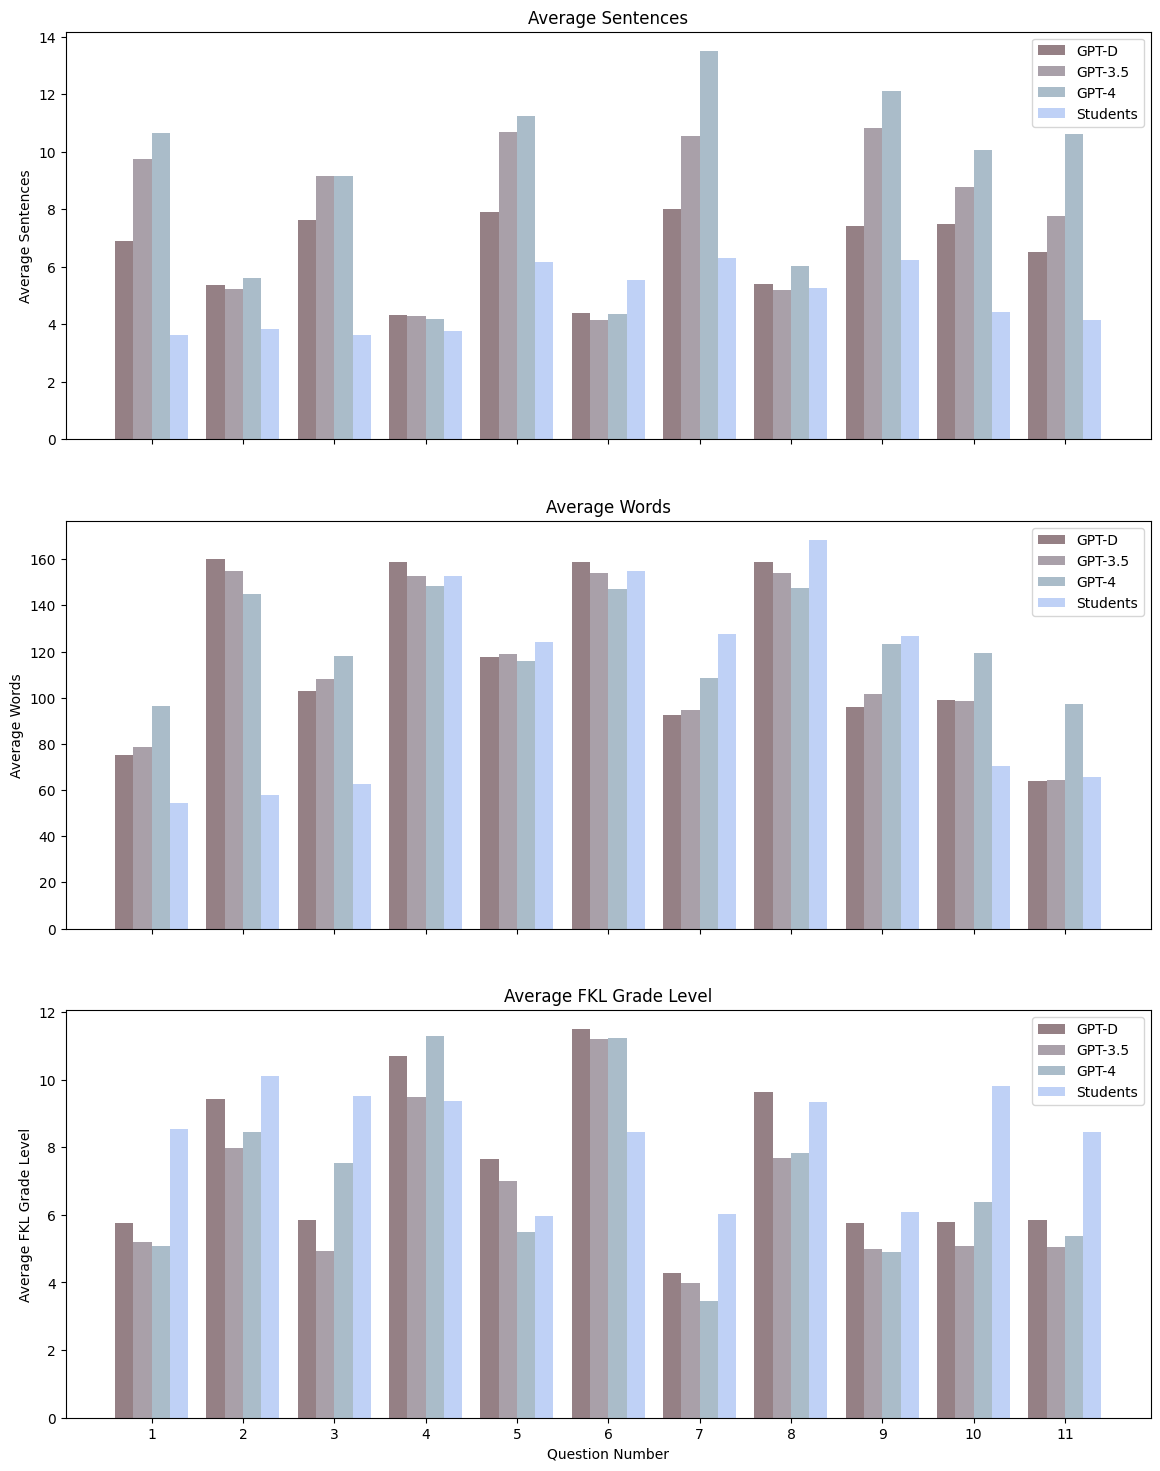

In [100]:
# Select the data for the first 11 questions (0-10)
first_11_questions = results_df.iloc[:11]

# GPT metrics from previous calculations
df_gpt3_5_first_11 = df_gpt3_5.iloc[:11]
df_gpt_4_first_11 = df_gpt_4.iloc[:11]
df_gpt_d_first_11 = df_gpt_d.iloc[:11]

# Plotting the bar charts in one plot
fig, ax = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

x = range(1, 12)  # Questions 1 to 11

# Plot for Average Sentences
ax[0].bar([i - 0.3 for i in x], df_gpt_d_first_11['Average Sentences'], width=0.2, label='GPT-D', color='#684A52', alpha=0.7)
ax[0].bar([i - 0.1 for i in x], df_gpt3_5_first_11['Average Sentences'], width=0.2, label='GPT-3.5', color='#857885', alpha=0.7)
ax[0].bar([i + 0.1 for i in x], df_gpt_4_first_11['Average Sentences'], width=0.2, label='GPT-4', color='#87A0B2', alpha=0.7)
ax[0].bar([i + 0.3 for i in x], first_11_questions['avg_sentences'], width=0.2, label='Students', color='#A4BEF3', alpha=0.7)
ax[0].set_ylabel('Average Sentences')
ax[0].set_title('Average Sentences')
ax[0].legend()

# Plot for Average Words
ax[1].bar([i - 0.3 for i in x], df_gpt_d_first_11['Average Words'], width=0.2, label='GPT-D', color='#684A52', alpha=0.7)
ax[1].bar([i - 0.1 for i in x], df_gpt3_5_first_11['Average Words'], width=0.2, label='GPT-3.5', color='#857885', alpha=0.7)
ax[1].bar([i + 0.1 for i in x], df_gpt_4_first_11['Average Words'], width=0.2, label='GPT-4', color='#87A0B2', alpha=0.7)
ax[1].bar([i + 0.3 for i in x], first_11_questions['avg_words'], width=0.2, label='Students', color='#A4BEF3', alpha=0.7)
ax[1].set_ylabel('Average Words')
ax[1].set_title('Average Words')
ax[1].legend()

# Plot for Average FKL Grade Level
ax[2].bar([i - 0.3 for i in x], df_gpt_d_first_11['Average FKL Grade Level'], width=0.2, label='GPT-D', color='#684A52', alpha=0.7)
ax[2].bar([i - 0.1 for i in x], df_gpt3_5_first_11['Average FKL Grade Level'], width=0.2, label='GPT-3.5', color='#857885', alpha=0.7)
ax[2].bar([i + 0.1 for i in x], df_gpt_4_first_11['Average FKL Grade Level'], width=0.2, label='GPT-4', color='#87A0B2', alpha=0.7)
ax[2].bar([i + 0.3 for i in x], first_11_questions['avg_fkl'], width=0.2, label='Students', color='#A4BEF3', alpha=0.7)
ax[2].set_ylabel('Average FKL Grade Level')
ax[2].set_title('Average FKL Grade Level')
ax[2].set_xlabel('Question Number')
ax[2].legend()

# Ensure all subplots have the same x-axis labels
for axis in ax:
    axis.set_xticks(x)
    axis.set_xticklabels(x)

plt.show()


In [112]:
import pandas as pd
import nltk
from nltk.metrics import edit_distance
import numpy as np

# Ensure you have the punkt package
nltk.download('punkt')

# Load the Excel file
file_path = 'all_answer.xlsx'
data = pd.read_excel(file_path)

# Ensure no missing values
data = data.dropna(subset=[data.columns[0]])

# Extract the first column
first_column = data.iloc[:, 0]

# Split the data into the required lists
gpt3_5 = first_column[:100].tolist()
gpt_4 = first_column[2100:2200].tolist()
gpt_d = first_column[4200:4300].tolist()
stu = first_column[6300:6400].tolist()

# Function to calculate Levenshtein similarity
def levenshtein_similarity(s1, s2):
    distance = edit_distance(s1, s2)
    return 1 - distance / max(len(s1), len(s2))

# Function to calculate average similarity between two lists
def average_similarity(list1, list2):
    similarities = []
    for s1 in list1:
        for s2 in list2:
            similarities.append(levenshtein_similarity(s1, s2))
    return np.mean(similarities)

# Calculate average similarities between each pair of groups
sim_gpt3_5_gpt_4 = average_similarity(gpt3_5, gpt_4)
sim_gpt3_5_gpt_d = average_similarity(gpt3_5, gpt_d)
sim_gpt3_5_stu = average_similarity(gpt3_5, stu)
sim_gpt_4_gpt_d = average_similarity(gpt_4, gpt_d)
sim_gpt_4_stu = average_similarity(gpt_4, stu)
sim_gpt_d_stu = average_similarity(gpt_d, stu)

# Print the results
print(f"Average similarity between GPT-3.5 and GPT-4: {sim_gpt3_5_gpt_4:.4f}")
print(f"Average similarity between GPT-3.5 and GPT-D: {sim_gpt3_5_gpt_d:.4f}")
print(f"Average similarity between GPT-3.5 and Students: {sim_gpt3_5_stu:.4f}")
print(f"Average similarity between GPT-4 and GPT-D: {sim_gpt_4_gpt_d:.4f}")
print(f"Average similarity between GPT-4 and Students: {sim_gpt_4_stu:.4f}")
print(f"Average similarity between GPT-D and Students: {sim_gpt_d_stu:.4f}")


[nltk_data] Downloading package punkt to /Users/liuzifeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Average similarity between GPT-3.5 and GPT-4: 0.3186
Average similarity between GPT-3.5 and GPT-D: 0.4286
Average similarity between GPT-3.5 and Students: 0.2175
Average similarity between GPT-4 and GPT-D: 0.3084
Average similarity between GPT-4 and Students: 0.1910
Average similarity between GPT-D and Students: 0.2153
